In [1]:
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import subprocess #run R code from subprocess
import numpy as np
from os import listdir # get dir list
from os.path import isfile, join # get dir list


import concurrent.futures
import time
import pickle
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Meta-base analysis

## Ranking

### Algorithm Distributions

#### With Hyper parameters

In [2]:
metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset') }
noHyperCols = ['test_f1_macro_mean_AENN-5',
       'test_f1_macro_mean_edgeBoostFilter-15', 'test_f1_macro_mean_PRISM','test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5','test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']
metabasesRankingNoHyper = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset')[noHyperCols], 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset')[noHyperCols], 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset')[noHyperCols],
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset')[noHyperCols] }

In [3]:
DTCols = metabasesRanking['DT'].iloc[:,97:].columns
cols = ['EDB5','EDB20', 'HARF85','HRF', 'EDB15',  'ORB3','GE9', 'AENN7',
        'HARF75', 'ORB19','AENN11', 'AENN9','ORB11', 'PRISM','GE3', 'GE7',
        'ORB15', 'DCF','EDB10', 'HARF80','AENN3', 'HARF90','ORB7', 'HARF70',
        'GE5', 'AENN5','GE11']
for i in metabasesRanking:
    metabasesRanking[i] = metabasesRanking[i][DTCols]
    metabasesRanking[i].columns = cols


In [4]:
#Build Ranks
def buildRanks(metabases):
    ranks = {}
    for metabase in metabases:
        ranks[metabase] = pd.DataFrame() 
        # metabases[i]
        for i, value in enumerate(metabases[metabase].index):
            ranks[metabase] = ranks[metabase].append(metabases[metabase].iloc[i].rank(method = 'dense', ascending = False))
    return ranks

# ranks to position ranks

def ranksToPositionRanks(ranks):
    positionsRanks = {}
    
    for rank in ranks:
        positionsRanks[rank] = pd.DataFrame()
        for i in ranks[rank].columns:
            df_temp = pd.DataFrame(ranks[rank][i].value_counts()).sort_index().T
            positionsRanks[rank] = positionsRanks[rank].append(df_temp)
        positionsRanks[rank] = positionsRanks[rank].fillna(0)
    return positionsRanks


In [6]:
display(metabasesRanking['KNN'])
ranks['KNN']

EDB5     EDB20    HARF85       HRF  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.598837  0.946688  0.880442  1.000000   
1004_synthetic_control_10_1.csv.gz  0.706023  0.992051  0.946303  0.990938   
1004_synthetic_control_10_2.csv.gz  0.590378  0.984000  0.878816  1.000000   
1004_synthetic_control_10_3.csv.gz  0.859904  0.951626  0.933944  1.000000   
1004_synthetic_control_10_4.csv.gz  0.554560  0.982119  0.772660  1.000000   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.747525  0.842756  0.778320  0.765990   
997_balance-scale_5_6.csv.gz        0.728268  0.809213  0.741535  0.721590   
997_balance-scale_5_7.csv.gz        0.757928  0.838384  0.746436  0.760346   
997_balance-scale_5_8.csv.gz        0.746133  0.830678  0.763675  0.766489   
997_balance-scale_5_9.csv.gz        0.751801  0.794313  0.746291  0.744428   

                                       EDB15      ORB3       GE9     AENN7  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.878234  1.000000  1.000000  0.988713   
1004_synthetic_control_10_1.csv.gz  0.677480  1.000000  1.000000  0.995953   
1004_synthetic_control_10_2.csv.gz  0.751198  1.000000  1.000000  0.990017   
1004_synthetic_control_10_3.csv.gz  0.951843  1.000000  0.994000  0.995705   
1004_synthetic_control_10_4.csv.gz  0.983090  1.000000  1.000000  0.996529   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.793981  0.821038  0.746618  0.929649   
997_balance-scale_5_6.csv.gz        0.769384  0.810761  0.726451  0.919024   
997_balance-scale_5_7.csv.gz        0.801174  0.826968  0.772662  0.904481   
997_balance-scale_5_8.csv.gz        0.830678  0.808457  0.766597  0.922800   
997_balance-scale_5_9.csv.gz        0.794313  0.000000  0.755112  0.926442   

                                      HARF75     ORB19  ...       DCF  \
Dataset                                                 ...             
1004_synthetic_control_10_0.csv.gz  0.980010  1.000000  ...  0.996590   
1004_synthetic_control_10_1.csv.gz  0.978043  1.000000  ...  1.000000   
1004_synthetic_control_10_2.csv.gz  1.000000  1.000000  ...  1.000000   
1004_synthetic_control_10_3.csv.gz  0.983130  1.000000  ...  1.000000   
1004_synthetic_control_10_4.csv.gz  0.989771  1.000000  ...  1.000000   
...                                      ...       ...  ...       ...   
997_balance-scale_5_5.csv.gz        0.774616  0.811944  ...  0.820322   
997_balance-scale_5_6.csv.gz        0.746373  0.770505  ...  0.799606   
997_balance-scale_5_7.csv.gz        0.776585  0.810345  ...  0.800506   
997_balance-scale_5_8.csv.gz        0.781805  0.808457  ...  0.816251   
997_balance-scale_5_9.csv.gz        0.775479  0.794271  ...  0.804494   

                                       EDB10    HARF80     AENN3    HARF90  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.916210  0.961103  0.978341  0.650766   
1004_synthetic_control_10_1.csv.gz  0.698051  0.954708  0.966712  0.812369   
1004_synthetic_control_10_2.csv.gz  0.592129  0.958894  0.970060  0.659186   
1004_synthetic_control_10_3.csv.gz  0.841483  0.968975  0.963917  0.888054   
1004_synthetic_control_10_4.csv.gz  0.694544  0.964192  0.996529  0.674009   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.793981  0.771836  0.884225  0.758025   
997_balance-scale_5_6.csv.gz        0.740048  0.751646  0.884067  0.736532   
997_balance-scale_5_7.csv.gz        0.752374  0.753846  0.882883  0.748482   
997_balance-scale_5_8.csv.gz        0.792152  0.778154  0.886479  0.740773   
997_balance-scale_5_9.csv.gz        0.752570  0.742669  0.902929  0.723528   

                                        ORB7 

EDB5  EDB20  HARF85   HRF  EDB15  ORB3  \
1004_synthetic_control_10_0.csv.gz  17.0   10.0    14.0   1.0   15.0   1.0   
1004_synthetic_control_10_1.csv.gz  15.0    5.0    12.0   6.0   17.0   1.0   
1004_synthetic_control_10_2.csv.gz  17.0    7.0    12.0   1.0   14.0   1.0   
1004_synthetic_control_10_3.csv.gz  17.0   13.0    15.0   1.0   12.0   1.0   
1004_synthetic_control_10_4.csv.gz  14.0    6.0    11.0   1.0    5.0   1.0   
...                                  ...    ...     ...   ...    ...   ...   
997_balance-scale_5_5.csv.gz        19.0    6.0    13.0  16.0   10.0   7.0   
997_balance-scale_5_6.csv.gz        21.0    7.0    16.0  24.0   12.0   6.0   
997_balance-scale_5_7.csv.gz        17.0    6.0    24.0  15.0   10.0   7.0   
997_balance-scale_5_8.csv.gz        20.0    6.0    17.0  16.0    6.0   8.0   
997_balance-scale_5_9.csv.gz        13.0    5.0    14.0  16.0    5.0  22.0   

                                     GE9  AENN7  HARF75  ORB19  ...   DCF  \
1004_synthetic_control_10_0.csv.gz   1.0    5.0     6.0    1.0  ...   2.0   
1004_synthetic_control_10_1.csv.gz   1.0    3.0     8.0    1.0  ...   1.0   
1004_synthetic_control_10_2.csv.gz   1.0    6.0     1.0    1.0  ...   1.0   
1004_synthetic_control_10_3.csv.gz   4.0    3.0     8.0    1.0  ...   1.0   
1004_synthetic_control_10_4.csv.gz   1.0    2.0     4.0    1.0  ...   1.0   
...                                  ...    ...     ...    ...  ...   ...   
997_balance-scale_5_5.csv.gz        21.0    2.0    14.0    9.0  ...   8.0   
997_balance-scale_5_6.csv.gz        22.0    3.0    15.0   11.0  ...   9.0   
997_balance-scale_5_7.csv.gz        13.0    3.0    12.0    9.0  ...  11.0   
997_balance-scale_5_8.csv.gz        15.0    1.0    12.0    8.0  ...   7.0   
997_balance-scale_5_9.csv.gz        10.0    1.0     8.0    6.0  ...   4.0   

                                    EDB10  HARF80  AENN3  HARF90  ORB7  \
1004_synthetic_control_10_0.csv.gz   13.0     9.0    7.0    16.0   1.0   
1004_synthetic_control_10_1.csv.gz   16.0    11.0    9.0    14.0   1.0   
1004_synthetic_control_10_2.csv.gz   16.0    10.0    9.0    15.0   1.0   
1004_synthetic_control_10_3.csv.gz   18.0     9.0   11.0    16.0   1.0   
1004_synthetic_control_10_4.csv.gz   12.0    10.0    2.0    13.0   1.0   
...                                   ...     ...    ...     ...   ...   
997_balance-scale_5_5.csv.gz         10.0    15.0    5.0    18.0   7.0   
997_balance-scale_5_6.csv.gz         17.0    13.0    5.0    18.0   8.0   
997_balance-scale_5_7.csv.gz         21.0    20.0    5.0    22.0   8.0   
997_balance-scale_5_8.csv.gz         10.0    13.0    5.0    21.0   8.0   
997_balance-scale_5_9.csv.gz         12.0    17.0    3.0    20.0  21.0   

                                    HARF70   GE5  AENN5  GE11  
1004_synthetic_control_10_0.csv.gz     6.0   8.0    7.0   1.0  
1004_synthetic_control_10_1.csv.gz     4.0   7.0    9.0   1.0  
1004_synthetic_control_10_2.csv.gz     1.0   8.0    9.0   2.0  
1004_synthetic_control_10_3.csv.gz     6.0   5.0   11.0   2.0  
1004_synthetic_control_10_4.csv.gz     3.0   7.0    2.0   1.0  
...                                    ...   ...    ...   ...  
997_balance-scale_5_5.csv.gz          11.0  22.0    4.0  20.0  
997_balance-scale_5_6.csv.gz          10.0  20.0    4.0  19.0  
997_balance-scale_5_7.csv.gz          19.0  23.0    4.0  16.0  
997_balance-scale_5_8.csv.gz          11.0  19.0    4.0  18.0  
997_balance-scale_5_9.csv.gz           7.0  18.0    2.0   9.0  

[10740 rows x 27 columns]

DT


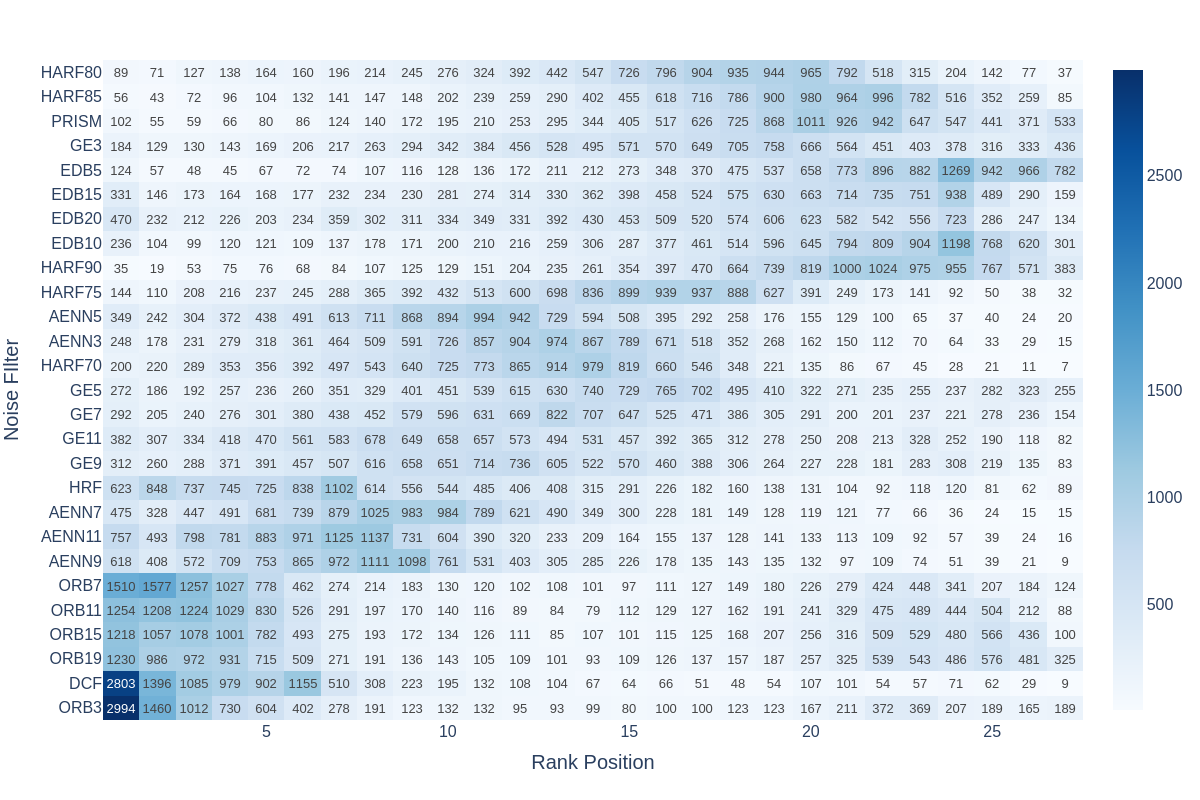

RF


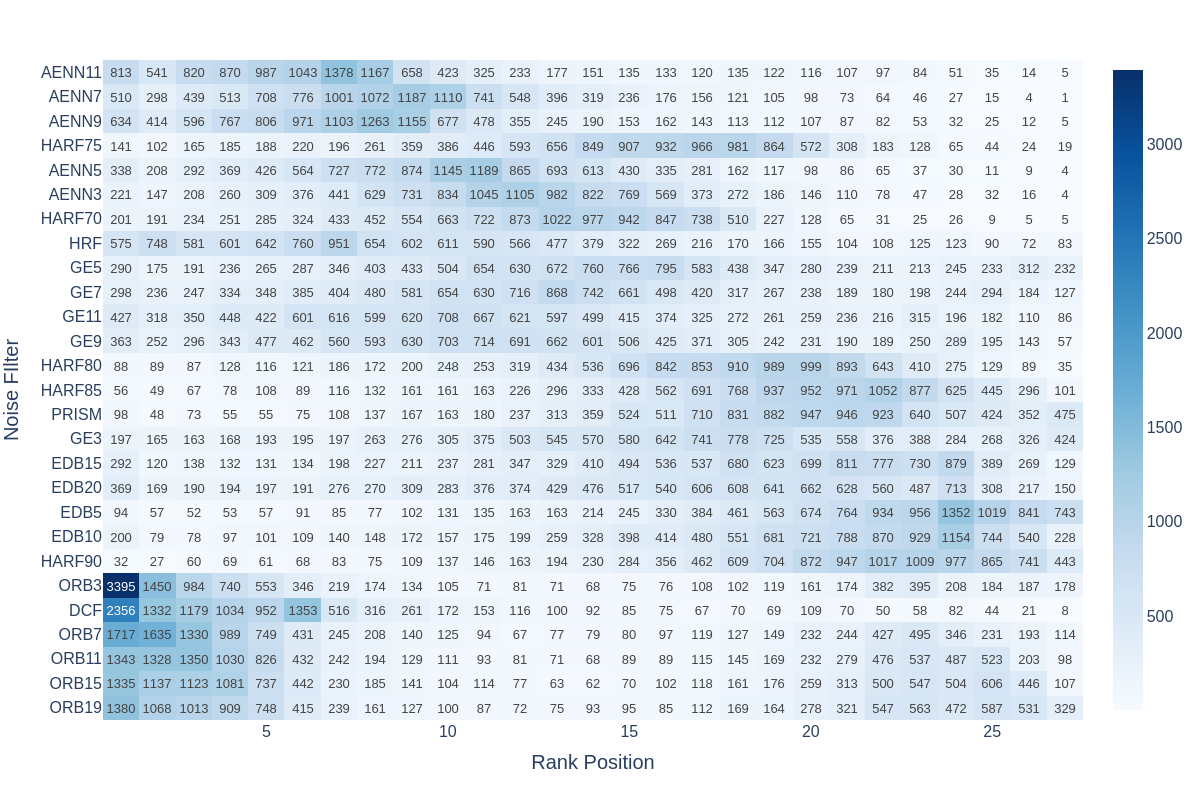

KNN


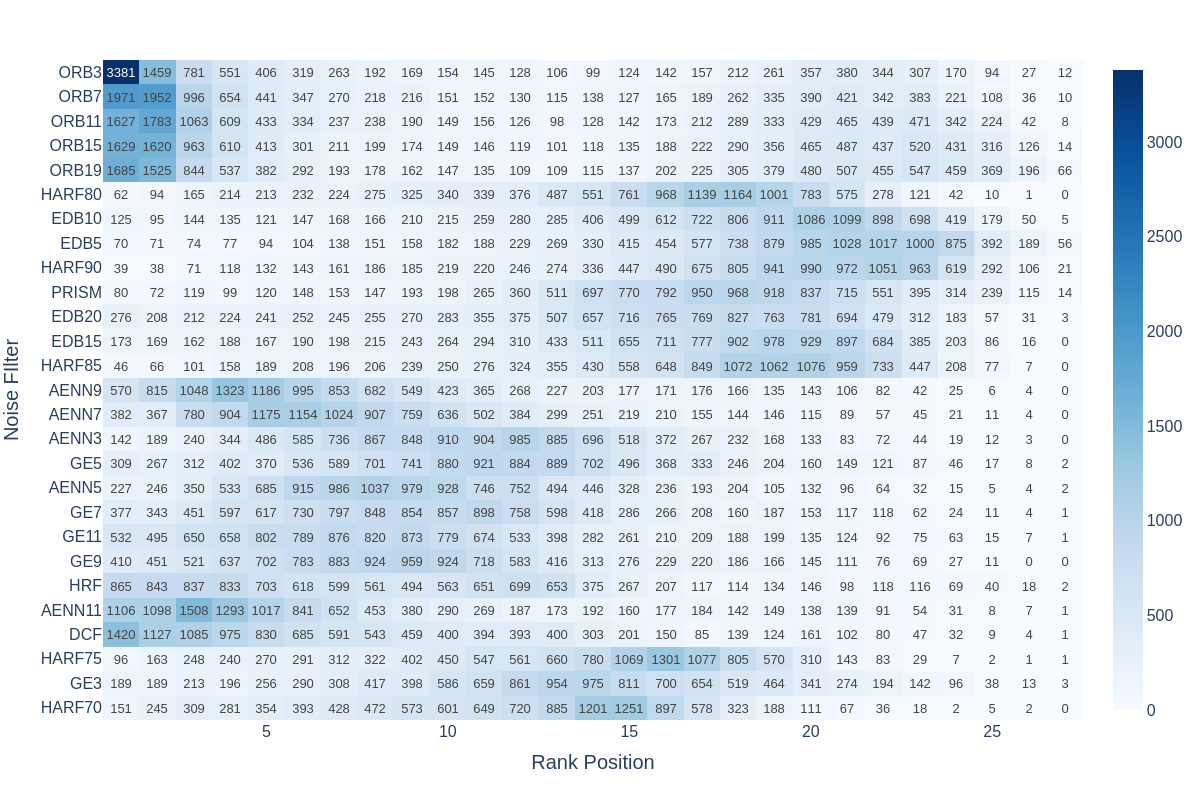

SVM


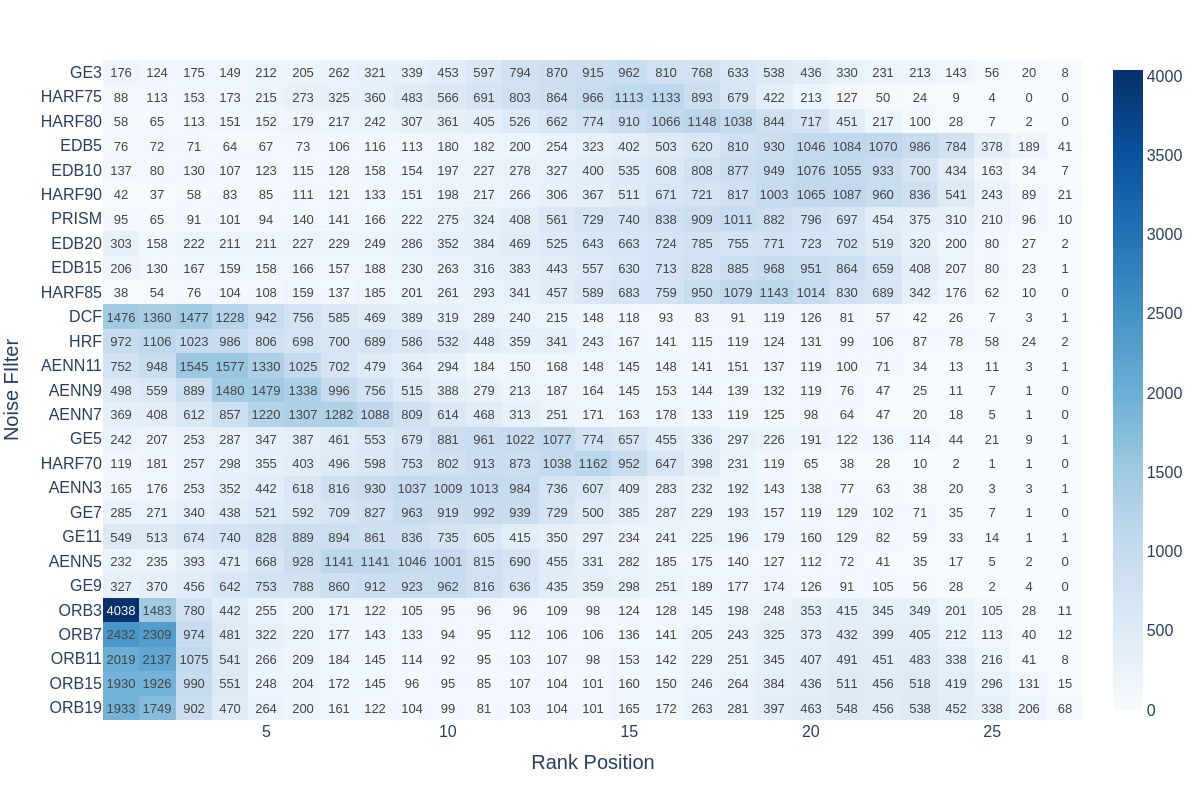

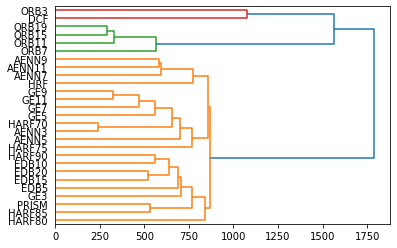

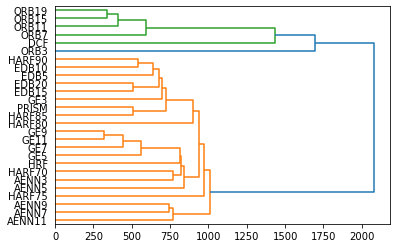

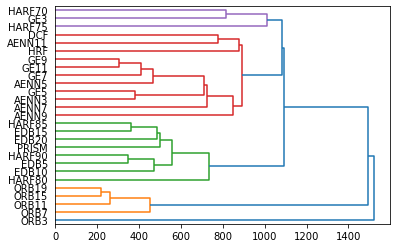

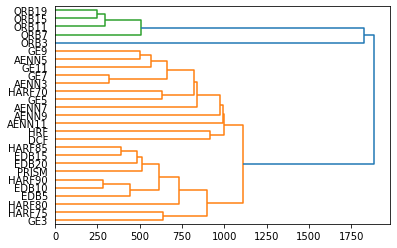

In [5]:
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt


if os.path.isfile('PickleVars/08 - AnalyzeResults/ranks.p'):
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'rb')
    ranks = pickle.load(file)
    file.close()
else:
    ranks = buildRanks(metabasesRanking)
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'wb')
    pickle.dump(ranks, file)
    file.close()

if os.path.isfile('PickleVars/08 - AnalyzeResults/postionsRanks.p'):
    file = open('PickleVars/08 - AnalyzeResults/postionsRanks.p', 'rb')
    postionsRanks = pickle.load(file)
    file.close()
else:
    postionsRanks = ranksToPositionRanks(ranks)
    file = open('PickleVars/08 - AnalyzeResults/postionsRanks.p', 'wb')
    pickle.dump(postionsRanks, file)
    file.close()

for i in postionsRanks:

    Z = hierarchy.linkage(postionsRanks[i])
    plt.figure()
    dn = hierarchy.dendrogram(Z, orientation='right', labels=postionsRanks[i].index)
    order = dn['ivl']
    print(i)
    fig = px.imshow(postionsRanks[i].loc[order], text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Blues)
    fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Noise FIlter",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Rank Position",
            titlefont=dict(size=20),
        ),
        showlegend=False,
        font=dict(
            size=16,
        )
    )
    fig.show(renderer="png", width=1200,
        height=800)

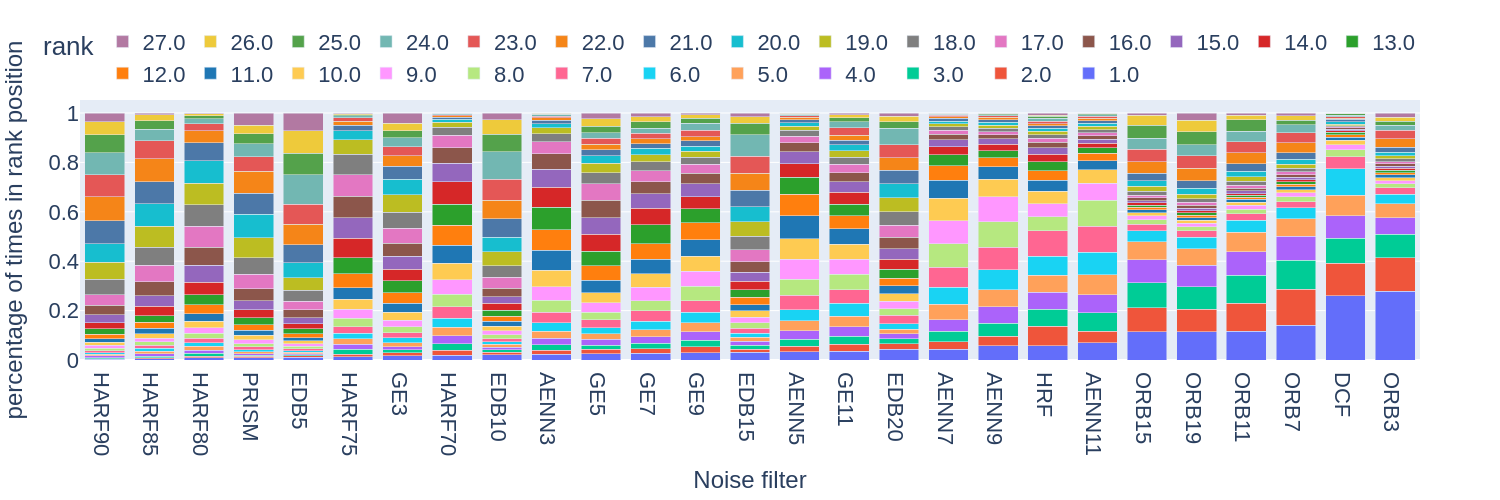

In [136]:
# rprc = postionsRanksCopy.loc[['ORB11', 'PRISM', 'AENN5', 'DCF', 'HRF', 'EDB15', 'GE5', 'HARF70']]
((postionsRanksCopy/10740).T)

import plotly.graph_objects as go
colorset = px.colors.qualitative.Plotly.copy() 
colorset =  colorset + px.colors.qualitative.D3
colorset = colorset +px.colors.qualitative.T10
# colorset.append(px.colors.qualitative.Light24[5])
colorset

x=(postionsRanksCopy/10740).sort_values(by=1.0).T.columns
fig = go.Figure()
for ind, val in enumerate((postionsRanksCopy/10740).sort_values(by=1.0).T):
    fig.add_trace(go.Bar(   x=x,
                            y=(postionsRanksCopy/10740).sort_values(by=1.0).T.iloc[ind].values, 
                            name=(postionsRanksCopy/10740).sort_values(by=1.0).T.index[ind],
                            marker_color = colorset[ind]))
# fig.add_trace(go.Bar(x=x, y=(postionsRanksCopy/10740).T.iloc[1].values, name='2'))


# # fig = go.Figure(go.Bar(x=x, y=[2,5,1,9], name='Montreal'))
# fig.add_trace(go.Bar(x=x, y=[1, 4, 9, 16], name='Ottawa'))
# fig.add_trace(go.Bar(x=x, y=[6, 8, 4.5, 8], name='Toronto'))

fig.update_layout(barmode='stack')
fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        legend_title="rank",
        yaxis=dict(
            title_text="percentage of times in rank position",
            titlefont=dict(size=24),
        ),
        xaxis=dict(
            title_text="Noise filter",
            titlefont=dict(size=24),
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
        font=dict(
            size=22,
        )
        # showlegend=False
        
    )
fig.show(renderer="png", width=1500,
        height=500)

0
1
2
3
4
5
6
7


In [93]:
colorset = px.colors.qualitative.Dark24.copy() 
colorset.append(px.colors.qualitative.Light24[1])
colorset.append(px.colors.qualitative.Light24[3])
colorset.append(px.colors.qualitative.Light24[5])
colorset
postionsRanksCopy = postionsRanks['DT'].copy()
postionsRanksCopy.iloc[0]
fig = go.Figure()
for ind, val in enumerate(rprc.T):
    fig.add_trace(go.Scatter(
        x=rprc.columns,
        y=rprc.iloc[ind].values,
        name = rprc.index[ind], # Style name/legend entry with html tags
        line_shape='linear',
    ))

fig.show(width=1000,
        height=500)

DT


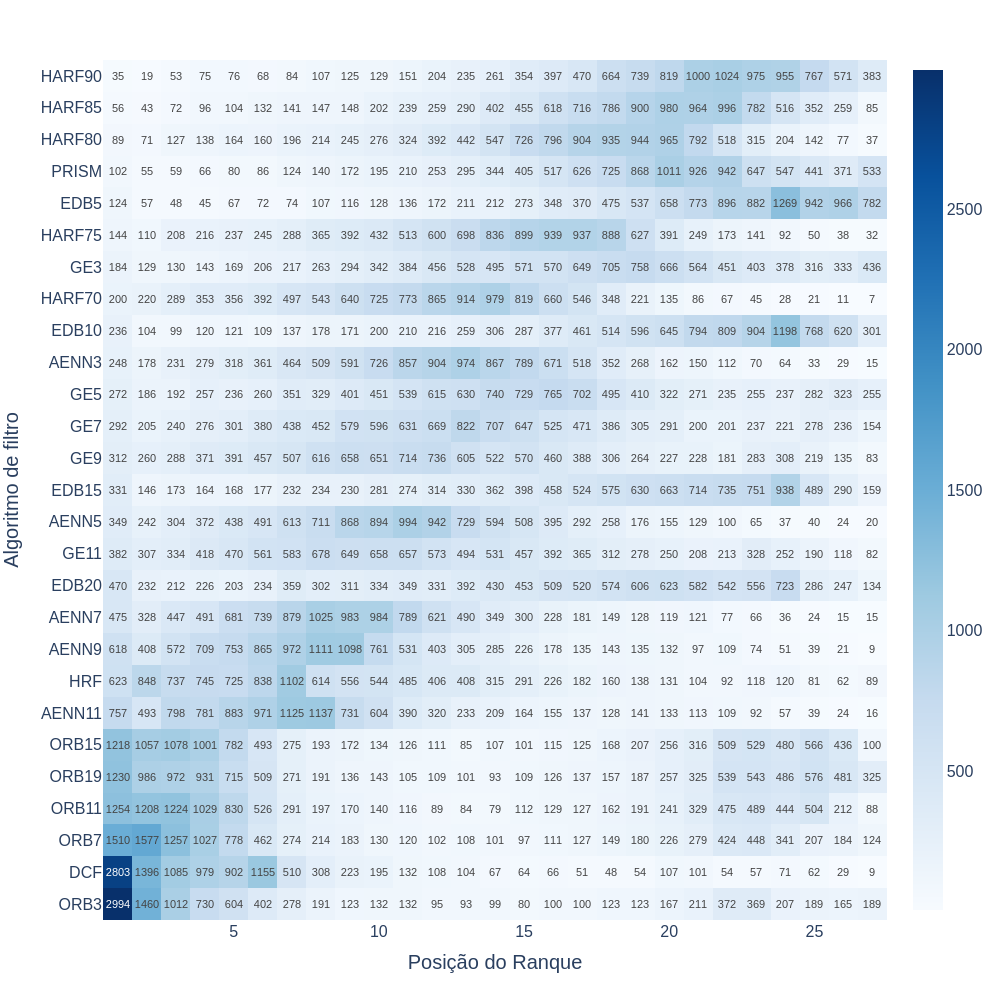

RF


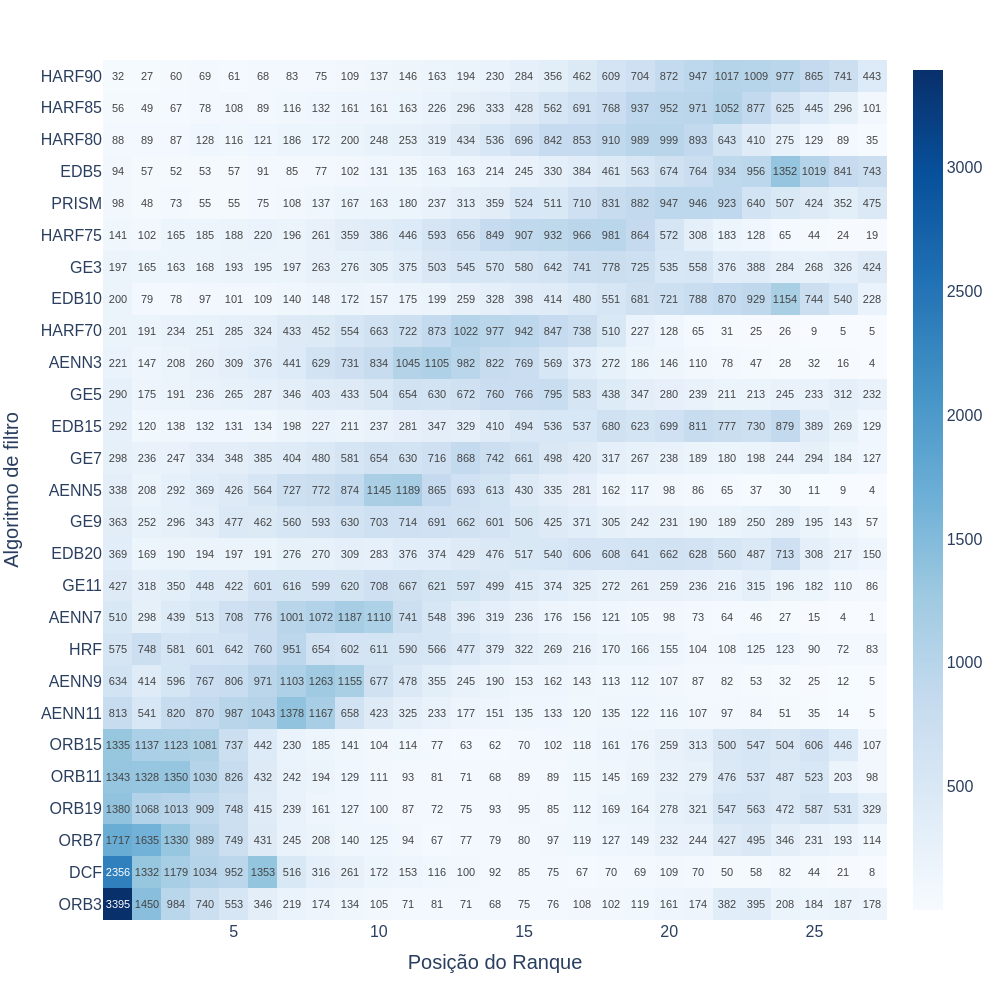

KNN


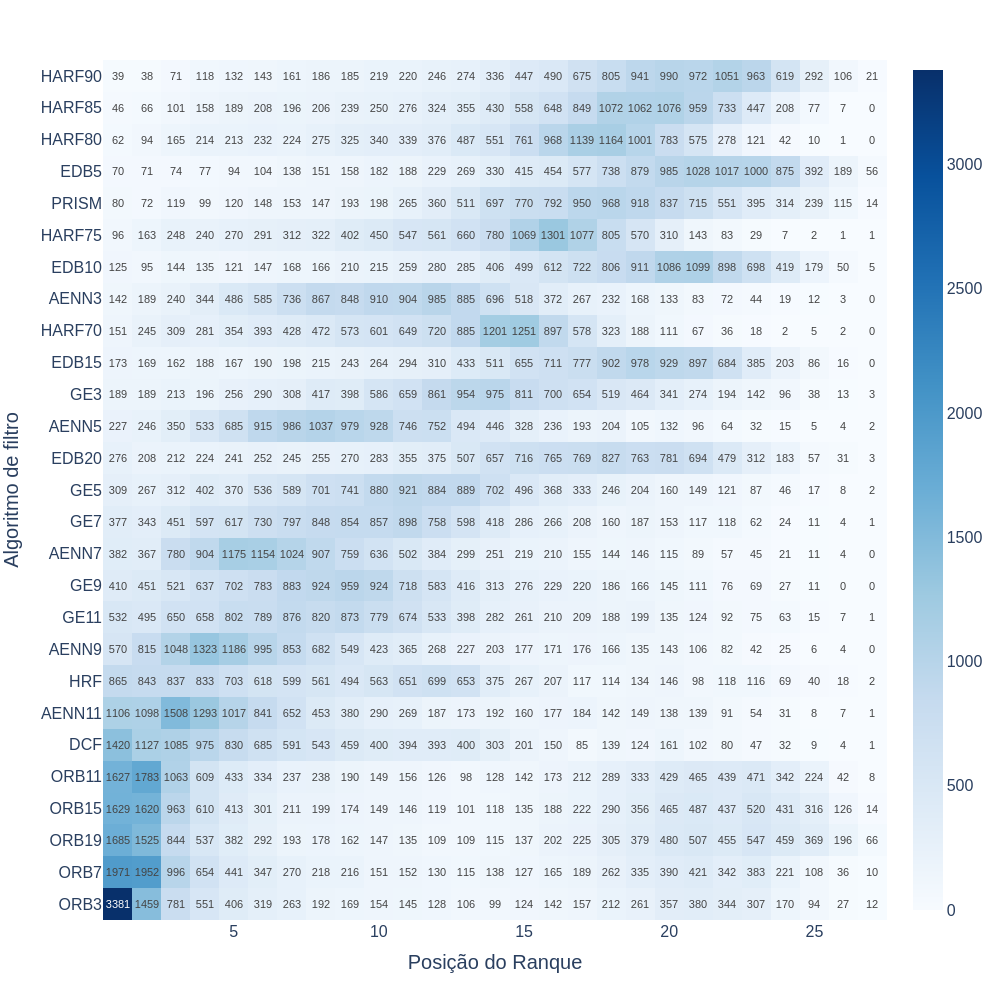

SVM


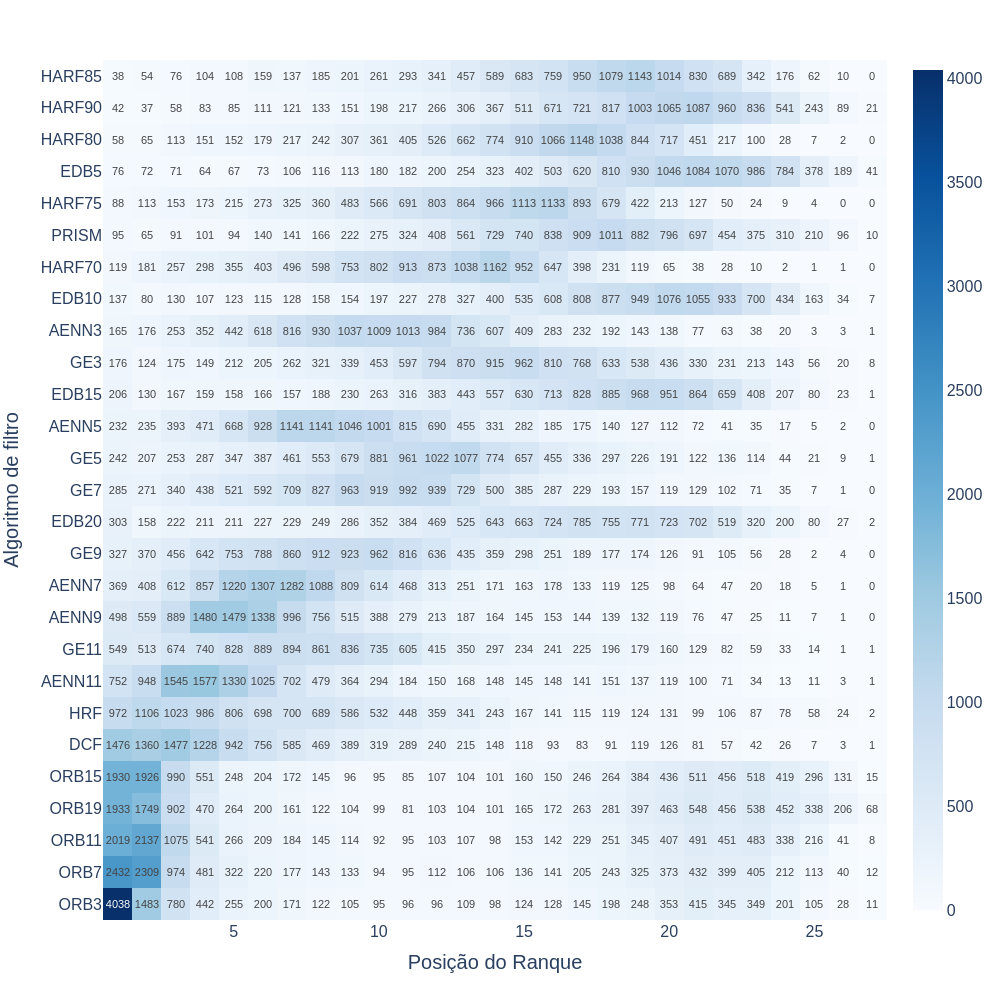

In [6]:
if os.path.isfile('PickleVars/08 - AnalyzeResults/ranks.p'):
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'rb')
    ranks = pickle.load(file)
    file.close()
else:
    ranks = buildRanks(metabasesRanking)
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'wb')
    pickle.dump(ranks, file)
    file.close()

if os.path.isfile('PickleVars/08 - AnalyzeResults/postionsRanks.p'):
    file = open('PickleVars/08 - AnalyzeResults/postionsRanks.p', 'rb')
    postionsRanks = pickle.load(file)
    file.close()
else:
    postionsRanks = ranksToPositionRanks(ranks)
    file = open('PickleVars/08 - AnalyzeResults/postionsRanks.p', 'wb')
    pickle.dump(postionsRanks, file)
    file.close()
    
for i in postionsRanks:
    print(i)
    fig = px.imshow(postionsRanks[i].sort_values(by=[1.0], ascending =True), text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Blues)
    fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Algoritmo de filtro",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Posição do Ranque",
            titlefont=dict(size=20),
        ),
        showlegend=False,
        font=dict(
            size=16,
        )
    )
    fig.show(renderer="png", width=1000,
        height=1000)
    # display(postionsRanks[i])

#### Without HyperParameters

In [11]:
noHyperCols = ['test_f1_macro_mean_AENN-5',
       'test_f1_macro_mean_edgeBoostFilter-15', 'test_f1_macro_mean_PRISM','test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5','test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']
# metabasesRankingNoHyper = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset')[noHyperCols], 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset')[noHyperCols], 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset')[noHyperCols] }
metabasesRankingNoHyper = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset')[noHyperCols], 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset')[noHyperCols], 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset')[noHyperCols],
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset')[noHyperCols] }
cols = [ 'AENN', 'EDB', 'PRISM', 'HARF', 'GE',  'DCF', 'HRF','ORB']
       #  ['GE', 'AENN', 'HARF', 'Edge', 'PRISM', 'Hybrid',  'ORBoost', 'Dynamic']
       #  [ 'AENN', 'Edge', 'PRISM', 'HARF', 'GE',  'Dynamic', 'Hybrid','ORBoost']
for i in metabasesRankingNoHyper:
    metabasesRankingNoHyper[i].columns = cols
    metabasesRankingNoHyper[i] = metabasesRankingNoHyper[i][['GE', 'AENN', 'HARF', 'EDB', 'PRISM', 'HRF',  'ORB', 'DCF']]

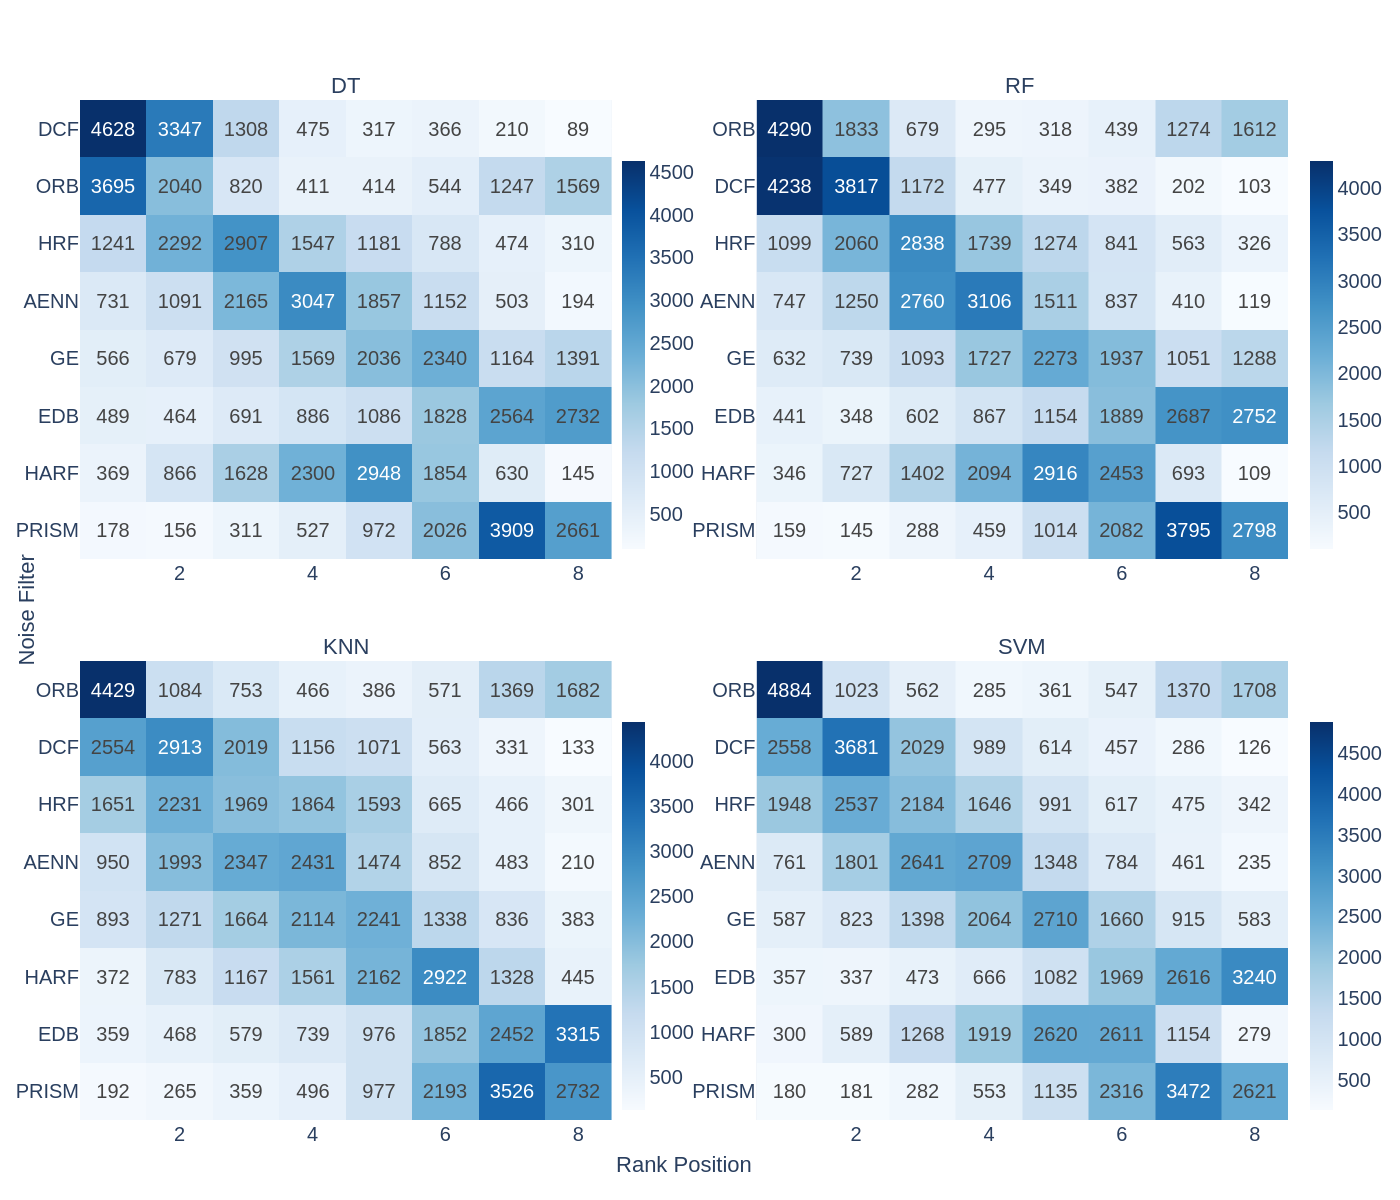

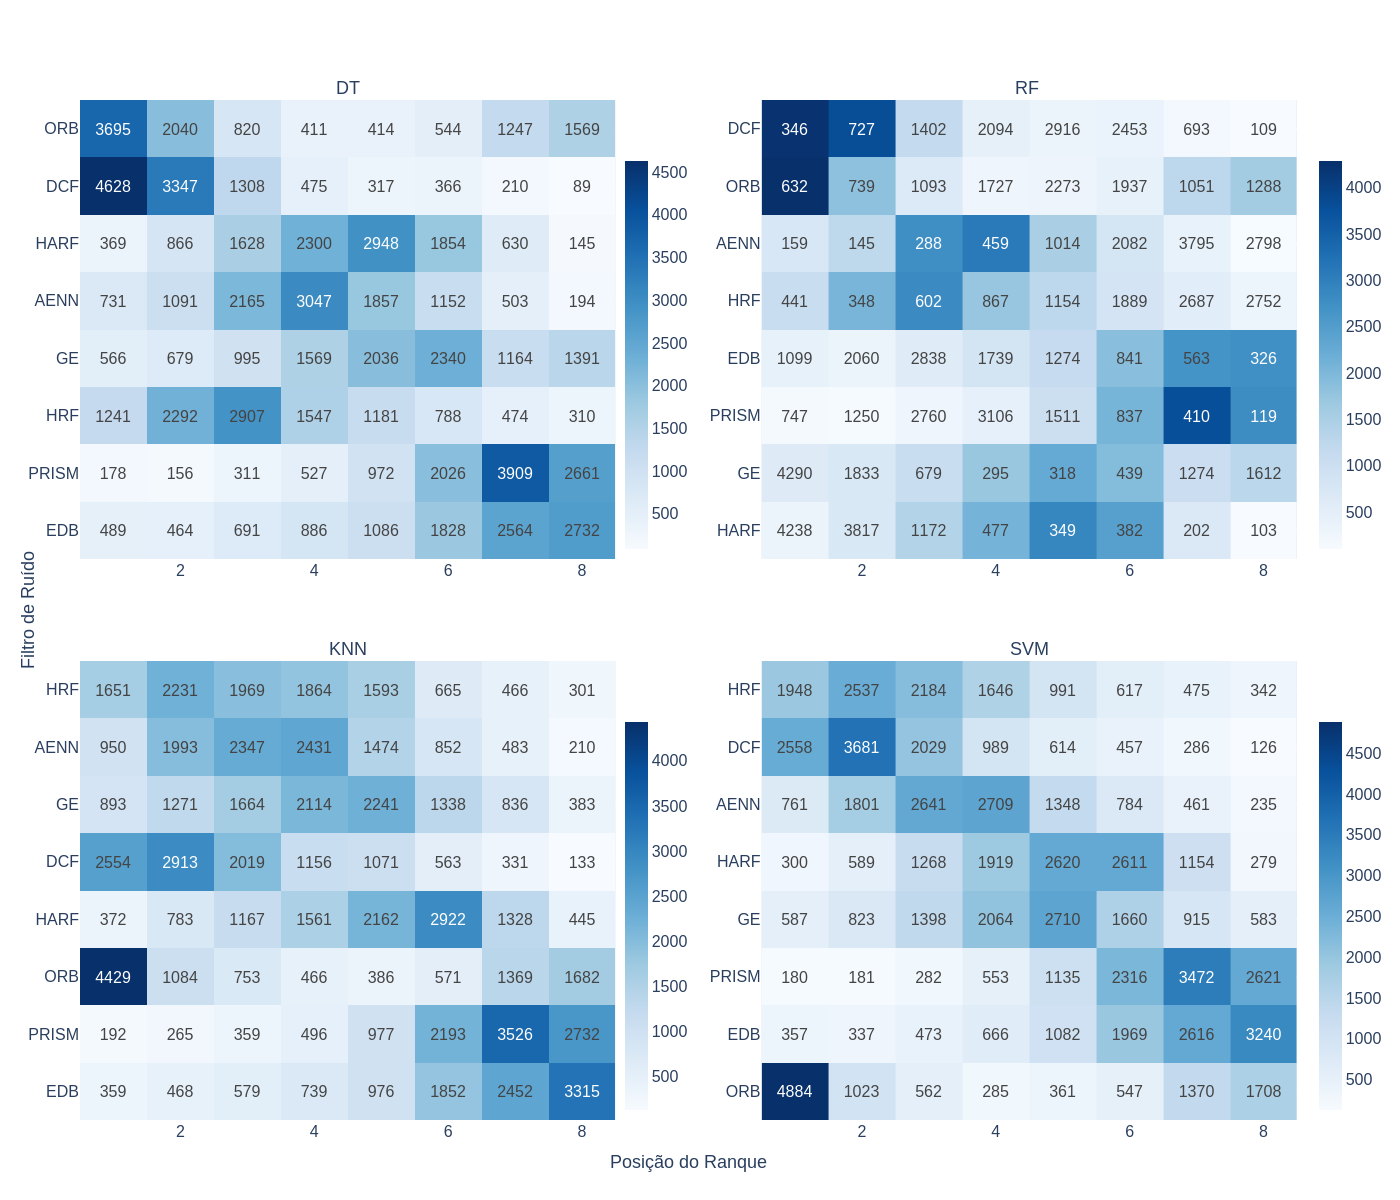

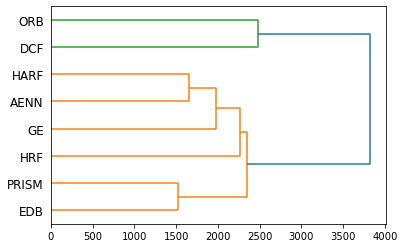

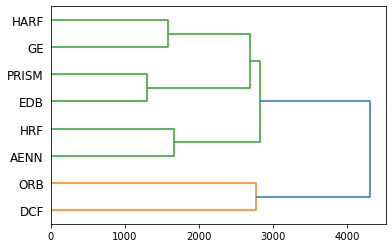

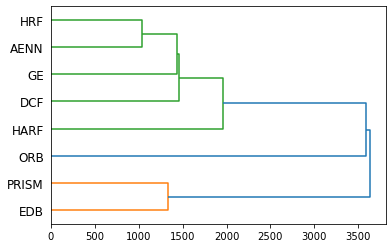

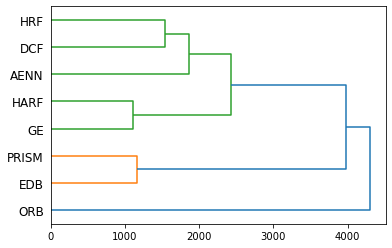

In [37]:
if os.path.isfile('PickleVars/08 - AnalyzeResults/ranksNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/ranksNoHyper.p', 'rb')
    ranksNoHyper = pickle.load(file)
    file.close()
else:
    ranksNoHyper = buildRanks(metabasesRankingNoHyper)
    file = open('PickleVars/08 - AnalyzeResults/ranksNoHyper.p', 'wb')
    pickle.dump(ranks, file)
    file.close()

if os.path.isfile('PickleVars/08 - AnalyzeResults/postionsRanksNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/postionsRanksNoHyper.p', 'rb')
    postionsRanksNoHyper = pickle.load(file)
    file.close()
else:
    postionsRanksNoHyper = ranksToPositionRanks(ranksNoHyper)
    file = open('PickleVars/08 - AnalyzeResults/postionsRanksNoHyper.p', 'wb')
    pickle.dump(postionsRanksNoHyper, file)
    file.close()


# ranksNoHyper = buildRanks(metabasesRankingNoHyper)
# postionsRanksNoHyper = ranksToPositionRanks(ranksNoHyper)
# for i in postionsRanksNoHyper:
#     fig = px.imshow(postionsRanksNoHyper[i], text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Blues)
#     fig.update_layout(
#         autosize=False,
#         width=800,
#         height=1000,
#         yaxis=dict(
#             title_text="Algoritmo de filtro",
#             titlefont=dict(size=20),
#         ),
#         xaxis=dict(
#             title_text="Posição do Rank",
#             titlefont=dict(size=20),
#         ),
#         showlegend=False
#     )
#     fig.show(renderer="png", width=600,
#         height=600)
#     # display(postionsRanks[i])
fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.1,
                    horizontal_spacing=0.12,
                    x_title='Rank Position',
                    y_title='Noise Filter',
                    subplot_titles=('DT',  'RF ', 
                                    'KNN', 'SVM'))
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}
row= 1
col = 1
count =1
for i in postionsRanksNoHyper:

    
    fig.add_trace(go.Heatmap(df_to_plotly(postionsRanksNoHyper[i].sort_values(by=[1.0], ascending =True)), coloraxis=f'coloraxis{count}', 
        text = postionsRanksNoHyper[i].sort_values(by=[1.0], ascending =True).values.tolist(), texttemplate="%{text}"),
        col = col, row= row)
    # fig.add_trace(go.Image(df_to_plotly(postionsRanksNoHyper[i]), coloraxis=f'coloraxis{count}'), col = col, row= row)
    # fig = px.imshow()
    # fig.update_layout(
    #     autosize=False,
    #     width=800,
    #     height=1000,
    #     yaxis=dict(
    #         title_text="Algoritmo de filtro",
    #         titlefont=dict(size=20),
    #     ),
    #     xaxis=dict(
    #         title_text="Posição do Rank",
    #         titlefont=dict(size=20),
    #     ),
    #     showlegend=False
    # )
    count +=1
    col +=1
    if col > 2:
        row+=1
        col = 1
fig.update_layout(width=700, height=400,
                  coloraxis1=dict(colorscale='Blues', colorbar_x=0.44, colorbar_y= .75, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis2=dict(colorscale='Blues', colorbar_x=1.01, colorbar_y= .75, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis3=dict(colorscale='Blues', colorbar_x=0.44, colorbar_y= .2, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis4=dict(colorscale='Blues', colorbar_x=1.01, colorbar_y= .2, colorbar_len=0.4, colorbar_thickness=23),
                  annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=22,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=20,
        )
                  )
fig.show(renderer="png", width=1400,
        height=1200)
    # display(postionsRanks[i])

fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.1,
                    horizontal_spacing=0.12,
                    x_title='Posição do Ranque',
                    y_title='Filtro de Ruído',
                    subplot_titles=('DT',  'RF ', 
                                    'KNN', 'SVM'))
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}
row= 1
col = 1
count =1
for i in postionsRanksNoHyper:

    Z = hierarchy.linkage(postionsRanksNoHyper[i])
    plt.figure()
    dn = hierarchy.dendrogram(Z, orientation='right', labels=postionsRanksNoHyper[i].index)
    order = dn['ivl']
    if i == 'RF':
        fig.add_trace(go.Heatmap(df_to_plotly(postionsRanksNoHyper[i].loc[order[::-1]]), coloraxis=f'coloraxis{count}', 
            text = postionsRanksNoHyper[i].loc[order].values.tolist(), texttemplate="%{text}"),
            col = col, row= row)
    else:
        fig.add_trace(go.Heatmap(df_to_plotly(postionsRanksNoHyper[i].loc[order]), coloraxis=f'coloraxis{count}', 
            text = postionsRanksNoHyper[i].loc[order].values.tolist(), texttemplate="%{text}"),
            col = col, row= row)
    # fig.add_trace(go.Image(df_to_plotly(postionsRanksNoHyper[i]), coloraxis=f'coloraxis{count}'), col = col, row= row)
    # fig = px.imshow()
    # fig.update_layout(
    #     autosize=False,
    #     width=800,
    #     height=1000,
    #     yaxis=dict(
    #         title_text="Algoritmo de filtro",
    #         titlefont=dict(size=20),
    #     ),
    #     xaxis=dict(
    #         title_text="Posição do Rank",
    #         titlefont=dict(size=20),
    #     ),
    #     showlegend=False
    # )
    count +=1
    col +=1
    if col > 2:
        row+=1
        col = 1
fig.update_layout(width=700, height=400,
                  coloraxis1=dict(colorscale='Blues', colorbar_x=0.44, colorbar_y= .75, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis2=dict(colorscale='Blues', colorbar_x=1.01, colorbar_y= .75, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis3=dict(colorscale='Blues', colorbar_x=0.44, colorbar_y= .2, colorbar_len=0.4, colorbar_thickness=23),
                  coloraxis4=dict(colorscale='Blues', colorbar_x=1.01, colorbar_y= .2, colorbar_len=0.4, colorbar_thickness=23),
                  annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=18,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        )
                  )
fig.show(renderer="png", width=1400,
        height=1200)
    # display(postionsRanks[i])

## Gain produced by algorithm

In [6]:
noFilterResults = pd.read_csv('Results/NoisyDatasets_resultsDT.csv.zip', index_col='Unnamed: 0')
noFilterResults = noFilterResults.rename(columns={'test_f1_macro_mean': 'noFilter-f1'})
noFilterResults.index.name='Dataset'
noFilterResults['noFilter-f1'].sort_index()

Dataset
1004_synthetic_control_10_0.csv.gz    0.560598
1004_synthetic_control_10_1.csv.gz    0.584493
1004_synthetic_control_10_2.csv.gz    0.523056
1004_synthetic_control_10_3.csv.gz    0.603713
1004_synthetic_control_10_4.csv.gz    0.514328
                                        ...   
997_balance-scale_5_5.csv.gz          0.502763
997_balance-scale_5_6.csv.gz          0.531294
997_balance-scale_5_7.csv.gz          0.495785
997_balance-scale_5_8.csv.gz          0.462676
997_balance-scale_5_9.csv.gz          0.473048
Name: noFilter-f1, Length: 10740, dtype: float64

In [7]:
# metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset') }
metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset') }
DTCols = metabasesRanking['DT'].iloc[:,97:].columns

cols = ['EDB5','EDB20', 'HARF85','HRF', 'EDB15',  'ORB3','GE9', 'AENN7',
        'HARF75', 'ORB19','AENN11', 'AENN9','ORB11', 'PRISM','GE3', 'GE7',
        'ORB15', 'DCF','EDB10', 'HARF80','AENN3', 'HARF90','ORB7', 'HARF70',
        'GE5', 'AENN5','GE11']
for i in metabasesRanking:
    metabasesRanking[i] = metabasesRanking[i][DTCols]
    metabasesRanking[i].columns = cols

for i in metabasesRanking:
    noFilterResults = pd.read_csv(f'Results/NoisyDatasets_results{i}.csv.zip', index_col='Unnamed: 0')
    noFilterResults = noFilterResults.rename(columns={'test_f1_macro_mean': 'noFilterResults'})
    noFilterResults.index.name='Dataset'
    metabasesRanking[i]['noFilterResults'] = noFilterResults['noFilterResults'].sort_index()

In [15]:
metabasesRanking['KNN']

EDB5     EDB20    HARF85       HRF  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.598837  0.946688  0.880442  1.000000   
1004_synthetic_control_10_1.csv.gz  0.706023  0.992051  0.946303  0.990938   
1004_synthetic_control_10_2.csv.gz  0.590378  0.984000  0.878816  1.000000   
1004_synthetic_control_10_3.csv.gz  0.859904  0.951626  0.933944  1.000000   
1004_synthetic_control_10_4.csv.gz  0.554560  0.982119  0.772660  1.000000   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.747525  0.842756  0.778320  0.765990   
997_balance-scale_5_6.csv.gz        0.728268  0.809213  0.741535  0.721590   
997_balance-scale_5_7.csv.gz        0.757928  0.838384  0.746436  0.760346   
997_balance-scale_5_8.csv.gz        0.746133  0.830678  0.763675  0.766489   
997_balance-scale_5_9.csv.gz        0.751801  0.794313  0.746291  0.744428   

                                       EDB15      ORB3       GE9     AENN7  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.878234  1.000000  1.000000  0.988713   
1004_synthetic_control_10_1.csv.gz  0.677480  1.000000  1.000000  0.995953   
1004_synthetic_control_10_2.csv.gz  0.751198  1.000000  1.000000  0.990017   
1004_synthetic_control_10_3.csv.gz  0.951843  1.000000  0.994000  0.995705   
1004_synthetic_control_10_4.csv.gz  0.983090  1.000000  1.000000  0.996529   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.793981  0.821038  0.746618  0.929649   
997_balance-scale_5_6.csv.gz        0.769384  0.810761  0.726451  0.919024   
997_balance-scale_5_7.csv.gz        0.801174  0.826968  0.772662  0.904481   
997_balance-scale_5_8.csv.gz        0.830678  0.808457  0.766597  0.922800   
997_balance-scale_5_9.csv.gz        0.794313  0.000000  0.755112  0.926442   

                                      HARF75     ORB19  ...     EDB10  \
Dataset                                                 ...             
1004_synthetic_control_10_0.csv.gz  0.980010  1.000000  ...  0.916210   
1004_synthetic_control_10_1.csv.gz  0.978043  1.000000  ...  0.698051   
1004_synthetic_control_10_2.csv.gz  1.000000  1.000000  ...  0.592129   
1004_synthetic_control_10_3.csv.gz  0.983130  1.000000  ...  0.841483   
1004_synthetic_control_10_4.csv.gz  0.989771  1.000000  ...  0.694544   
...                                      ...       ...  ...       ...   
997_balance-scale_5_5.csv.gz        0.774616  0.811944  ...  0.793981   
997_balance-scale_5_6.csv.gz        0.746373  0.770505  ...  0.740048   
997_balance-scale_5_7.csv.gz        0.776585  0.810345  ...  0.752374   
997_balance-scale_5_8.csv.gz        0.781805  0.808457  ...  0.792152   
997_balance-scale_5_9.csv.gz        0.775479  0.794271  ...  0.752570   

                                      HARF80     AENN3    HARF90      ORB7  \
Dataset                                                                      
1004_synthetic_control_10_0.csv.gz  0.961103  0.978341  0.650766  1.000000   
1004_synthetic_control_10_1.csv.gz  0.954708  0.966712  0.812369  1.000000   
1004_synthetic_control_10_2.csv.gz  0.958894  0.970060  0.659186  1.000000   
1004_synthetic_control_10_3.csv.gz  0.968975  0.963917  0.888054  1.000000   
1004_synthetic_control_10_4.csv.gz  0.964192  0.996529  0.674009  1.000000   
...                                      ...       ...       ...       ...   
997_balance-scale_5_5.csv.gz        0.771836  0.884225  0.758025  0.821038   
997_balance-scale_5_6.csv.gz        0.751646  0.884067  0.736532  0.801386   
997_balance-scale_5_7.csv.gz        0.753846  0.882883  0.748482  0.814224   
997_balance-scale_5_8.csv.gz        0.778154  0.886479  0.740773  0.808457   
997_balance-scale_5_9.csv.gz        0.742669  0.902929  0.723528  0.160000   

                                      HARF70 

In [8]:
gain = {}
for i in metabasesRanking:
    gain[i] = metabasesRanking[i].sub(metabasesRanking[i]['noFilterResults'], axis=0)
    gain[i].drop('noFilterResults', axis = 1, inplace = True)


In [13]:
def displayGainChart(gain):
    fig = go.Figure()
    for i in gain:
        if i == 'DT':
            fig.add_trace(go.Bar(
                x = gain[i].sum().sort_values(ascending=False).index,
                y = gain[i].sum().sort_values(ascending=False).values,
                name = i
            ))
        else:
            fig.add_trace(go.Bar(
                x = gain[i].sum().index,
                y = gain[i].sum().values,
                name = i
            ))
    fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        legend_title="Base-Learner",
        yaxis=dict(
            title_text="Soma do ganho dos algoritmos",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Filtro de Ruído",
            titlefont=dict(size=20),
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
        font=dict(
            size=18,
        )
        # showlegend=False
        
    )
    fig.show(renderer="png", width=1300,
            height=700)
    
def displayGainChartMean(gain):
    fig = go.Figure()
    for i in gain:
        if i == 'DT':
            fig.add_trace(go.Bar(
                x = gain[i].sum().sort_values(ascending=False).index,
                y = gain[i].sum().sort_values(ascending=False).values,
                name = i,
            ))
        else:
            fig.add_trace(go.Bar(
                x = gain[i].sum().index,
                y = gain[i].sum().values,
                name = i
            ))
    fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        legend_title="Base-Learner",
        yaxis=dict(
            title_text="Total F1-Score gain",
            titlefont=dict(size=24),
        ),
        xaxis=dict(
            title_text="Noise filter",
            titlefont=dict(size=24),
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
        font=dict(
            size=22,
        )
        # showlegend=False
        
    )
    fig.show(renderer="png", width=1300,
            height=600)

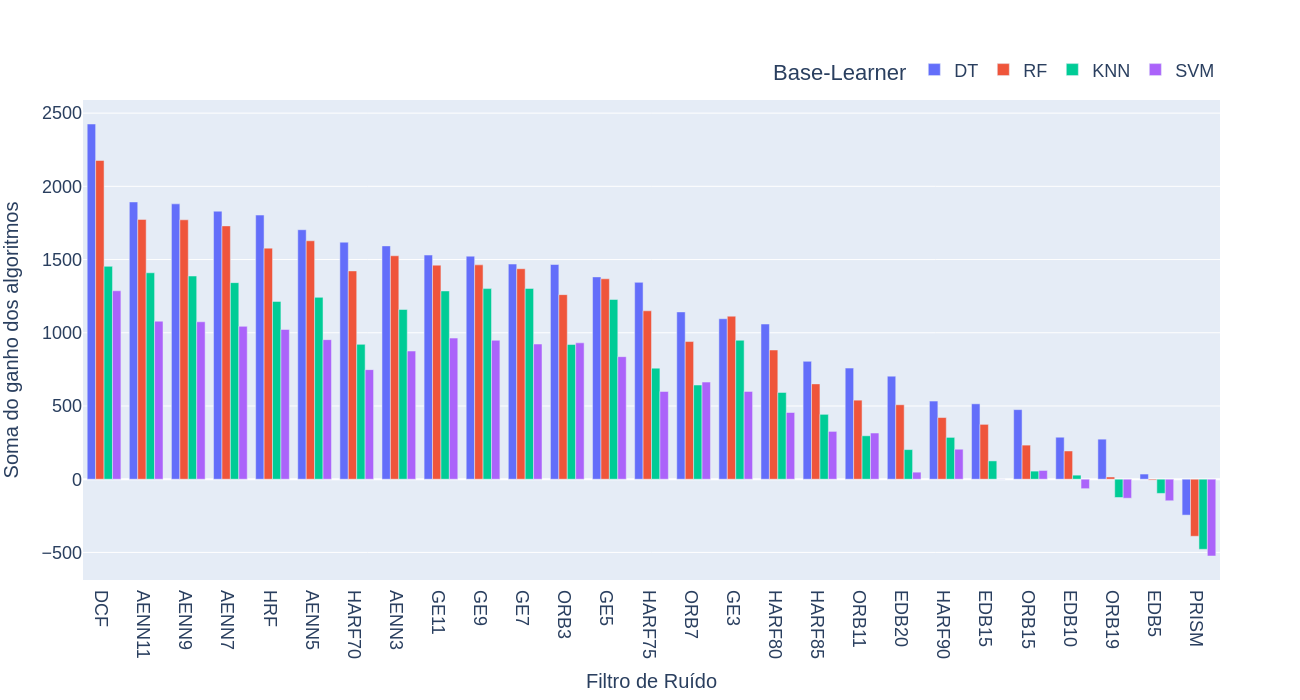

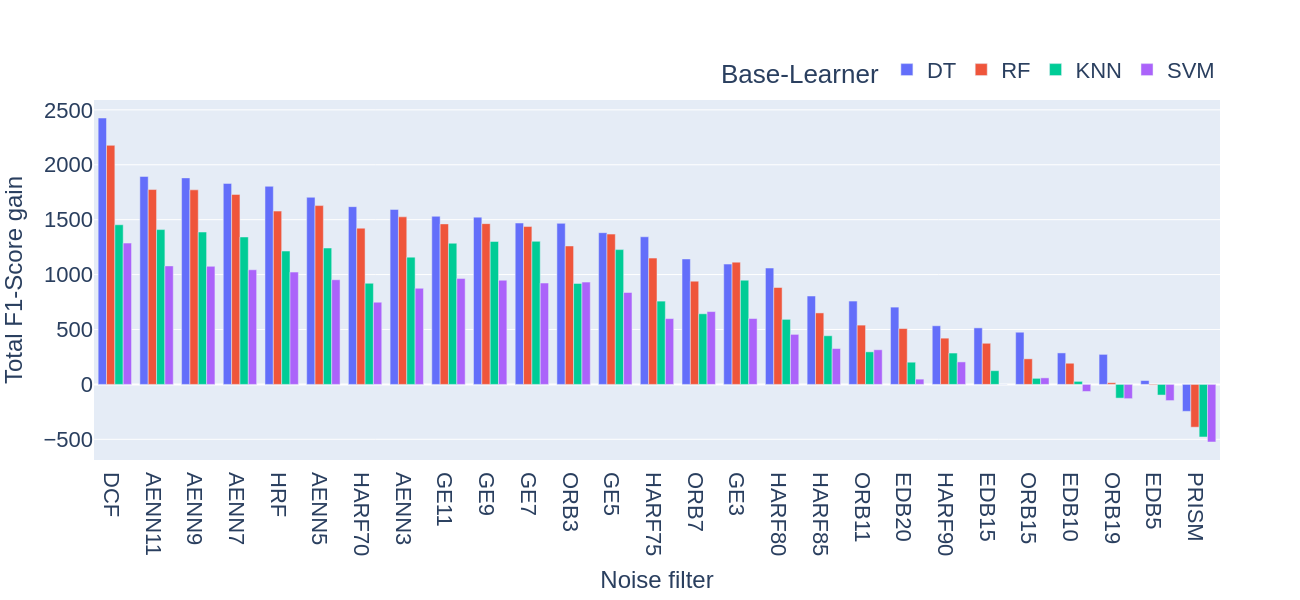

In [14]:
displayGainChart(gain)
displayGainChartMean(gain)

In [41]:
display(gainNoHyper['DT'].mean().values)
gainNoHyper['DT'].std().values


array([ 0.1586346 ,  0.04793819, -0.02284138,  0.15070191,  0.12863707,
        0.22586088,  0.16795044,  0.07066013])

array([0.14827746, 0.19433235, 0.25179744, 0.12709006, 0.14859102,
       0.20353496, 0.21825198, 0.35400392])

0.7228874953167193

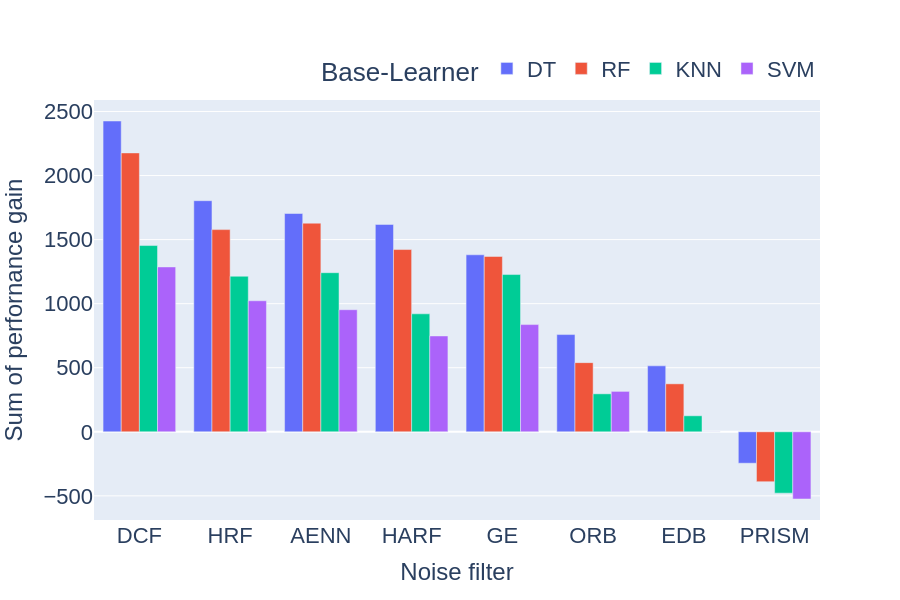

In [26]:
gainNoHyper = {}
for i in metabasesRanking:
    gainNoHyper[i] = metabasesRanking[i].sub(metabasesRanking[i]['noFilterResults'], axis=0)
    gainNoHyper[i].drop('noFilterResults', axis = 1, inplace = True)
for i in gain:
    gainNoHyper[i] = gainNoHyper[i][[ 'AENN5', 'EDB15', 'PRISM', 'HARF70', 'GE5',  'DCF', 'HRF','ORB11']]
    gainNoHyper[i].columns = [ 'AENN', 'EDB', 'PRISM', 'HARF', 'GE',  'DCF', 'HRF','ORB']
    gainNoHyper[i]
displayGainChartMean(gainNoHyper)

In [32]:
(gain['DT'] > 0)['DCF'].value_counts()[True]

10015

In [15]:
effectsOnF1 = {}
for i in gain:
    quantity = {}
    for column in gain[i].columns:
        positivo = (gain[i] > 0)[column].value_counts()[True]
        negativo = (gain[i] < 0)[column].value_counts()[True]
        neutro = 10740 -positivo - negativo
        quantity[column] = [positivo, negativo, neutro]
    
    effectsOnF1[i] = pd.DataFrame.from_dict(quantity, orient='index', columns=['Positivo', 'Negativo', 'Neutro'])

DT
RF
KNN
SVM


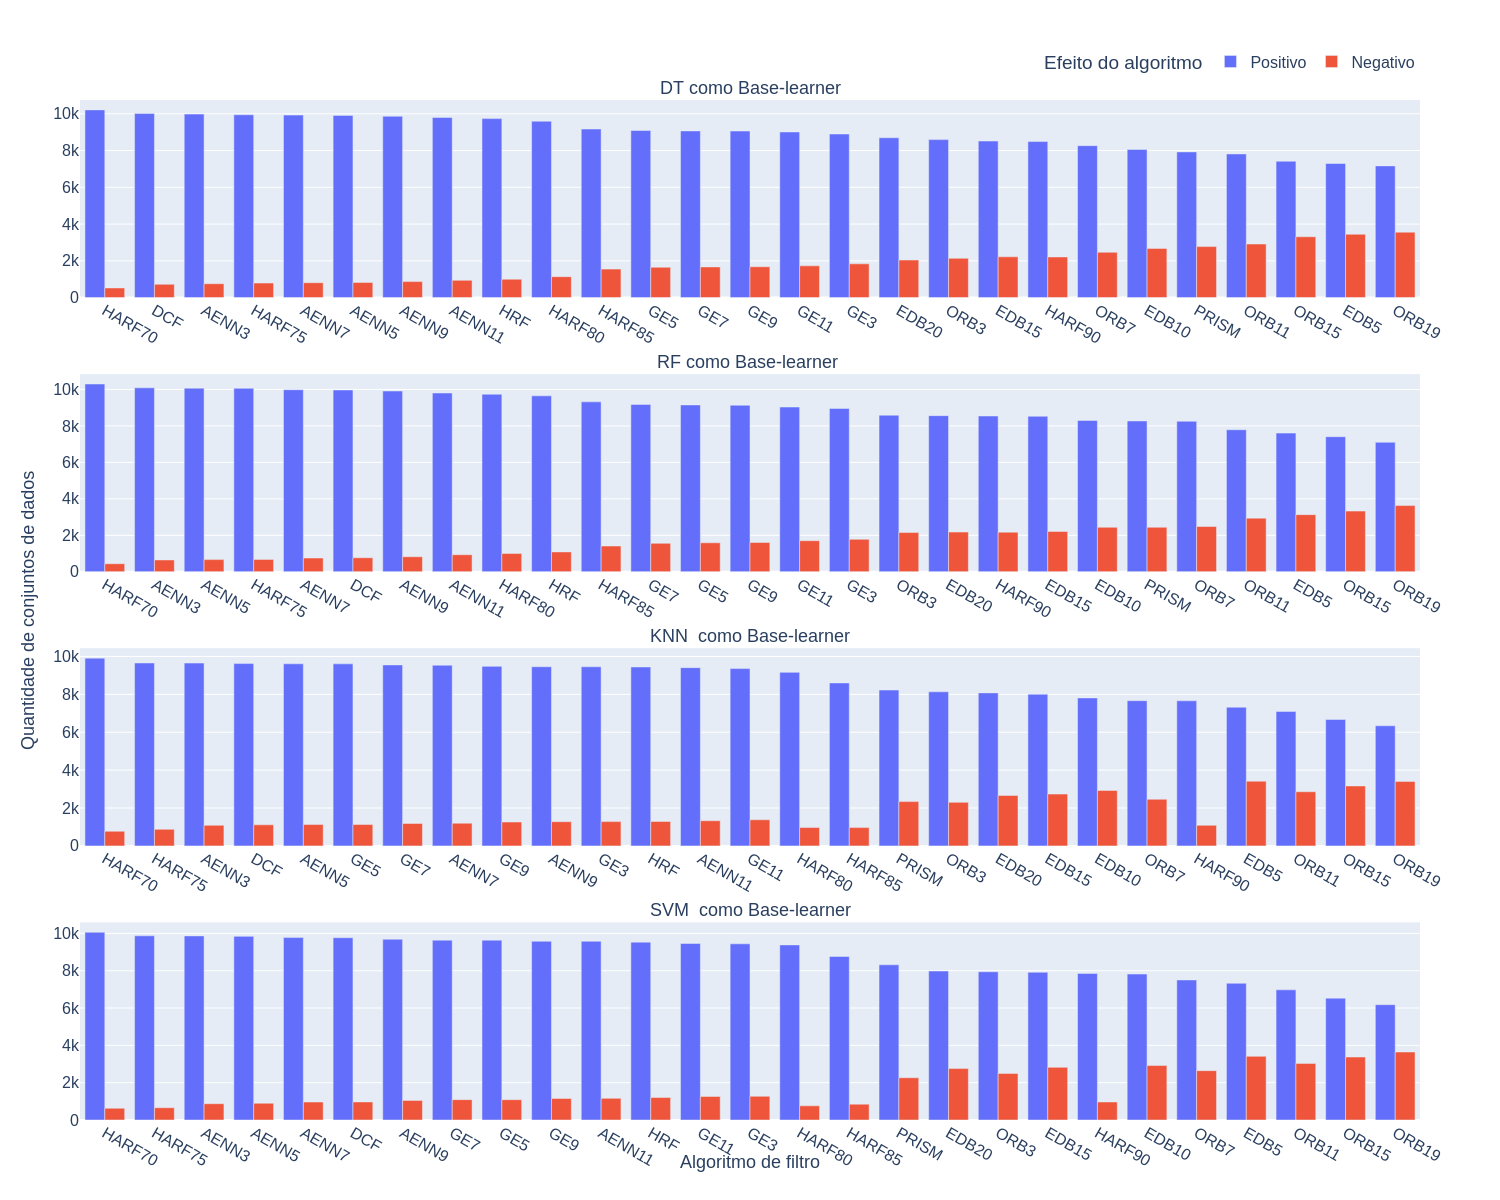

In [16]:
effectsOnF1['DT']
fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.075,
                    horizontal_spacing=0.085,
                    x_title='Algoritmo de filtro',
                    y_title='Quantidade de conjuntos de dados',
                    subplot_titles=('DT como Base-learner',  'RF como Base-learner ', 
                                    'KNN  como Base-learner', 'SVM  como Base-learner'))
row = 1
for i in effectsOnF1:
    print(i)
    effectsOnF1[i].sort_values(by=['Positivo'], ascending=False, inplace = True)
    # fig = go.Figure()
    if row == 1:
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Positivo'].values,
            name = 'Positivo',
            marker_color = plotly.colors.qualitative.Plotly[0]
        ), row=row, col=1)
    
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Negativo'].values,
            name = 'Negativo',
            marker_color = plotly.colors.qualitative.Plotly[1]
        ), row=row, col=1)
    else:
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Positivo'].values,
            name = 'Positivo',
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[0]
        ), row=row, col=1)
    
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Negativo'].values,
            name = 'Negativo',
            marker_color = plotly.colors.qualitative.Plotly[1],
            showlegend=False,
        ), row=row, col=1)

    row +=1
# fig.update_layout(
#     autosize=False,
#     yaxis=dict(
#         title_text="Quantidade de datasets",
#         titlefont=dict(size=20),
#     ),
#     xaxis=dict(
#         title_text="Algoritmo de filtro",
#         titlefont=dict(size=20),
#     ),

    
# )

fig.update_layout(
    legend_title="Efeito do algoritmo",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=18,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        ),
        yaxis = dict(
            tickfont = dict(size=16)),
        xaxis = dict(
            tickfont = dict(size=16))
        )
fig.show(renderer="png", width=1500,
        height=1200)

In [74]:
total_effect.sort_values(by='Positivo',ascending=False)

Positivo  Negativo  Neutro
HARF70     40490      2367     103
AENN3      39595      3365       0
HARF75     39542      3001     417
AENN5      39444      3516       0
DCF        39387      3573       0
AENN7      39234      3725       1
AENN9      38932      4026       2
AENN11     38596      4362       2
HRF        38369      4585       6
HARF80     37883      3870    1207
GE5        37494      5452      14
GE7        37445      5507       8
GE9        37255      5695      10
GE11       36871      6075      14
GE3        36760      6169      31
HARF85     35859      4777    2324
EDB20      33324      9636       0
ORB3       33264      9087     609
EDB15      32972      9988       0
PRISM      32747      9819     394
HARF90     32551      6435    3974
EDB10      31996     10964       0
ORB7       31694     10056    1210
ORB11      29684     11752    1524
EDB5       29549     13411       0
ORB15      28030     13177    1753
ORB19      26794     14243    1923

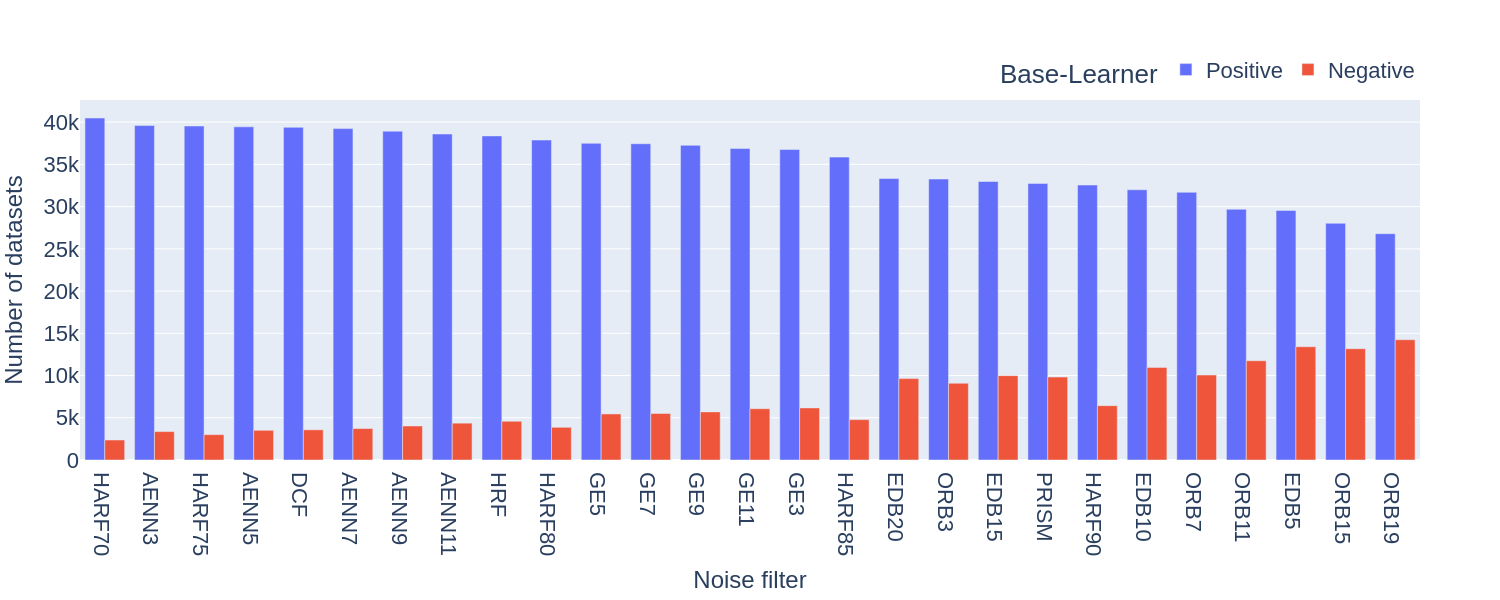

In [78]:
total_effect = effectsOnF1['DT'] + effectsOnF1['RF'] + effectsOnF1['KNN'] + effectsOnF1['SVM']
total_effect = total_effect.sort_values(by='Positivo',ascending=False)
fig = go.Figure()        
fig.add_trace(go.Bar(
    x = total_effect.index,
    y = total_effect['Positivo'].values,
    name = 'Positive',
    marker_color = plotly.colors.qualitative.Plotly[0]
))

fig.add_trace(go.Bar(
    x = total_effect.index,
    y = total_effect['Negativo'].values,
    name = 'Negative',
    marker_color = plotly.colors.qualitative.Plotly[1]
))
fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
    legend_title="Base-Learner",
    yaxis=dict(
        title_text="Number of datasets",
        titlefont=dict(size=24),
    ),
    xaxis=dict(
        title_text="Noise filter",
        titlefont=dict(size=24),
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ),
    font=dict(
        size=22,
    )
    # showlegend=False
    
)
fig.show(renderer="png", width=1500,
        height=600)


DT
RF
KNN
SVM


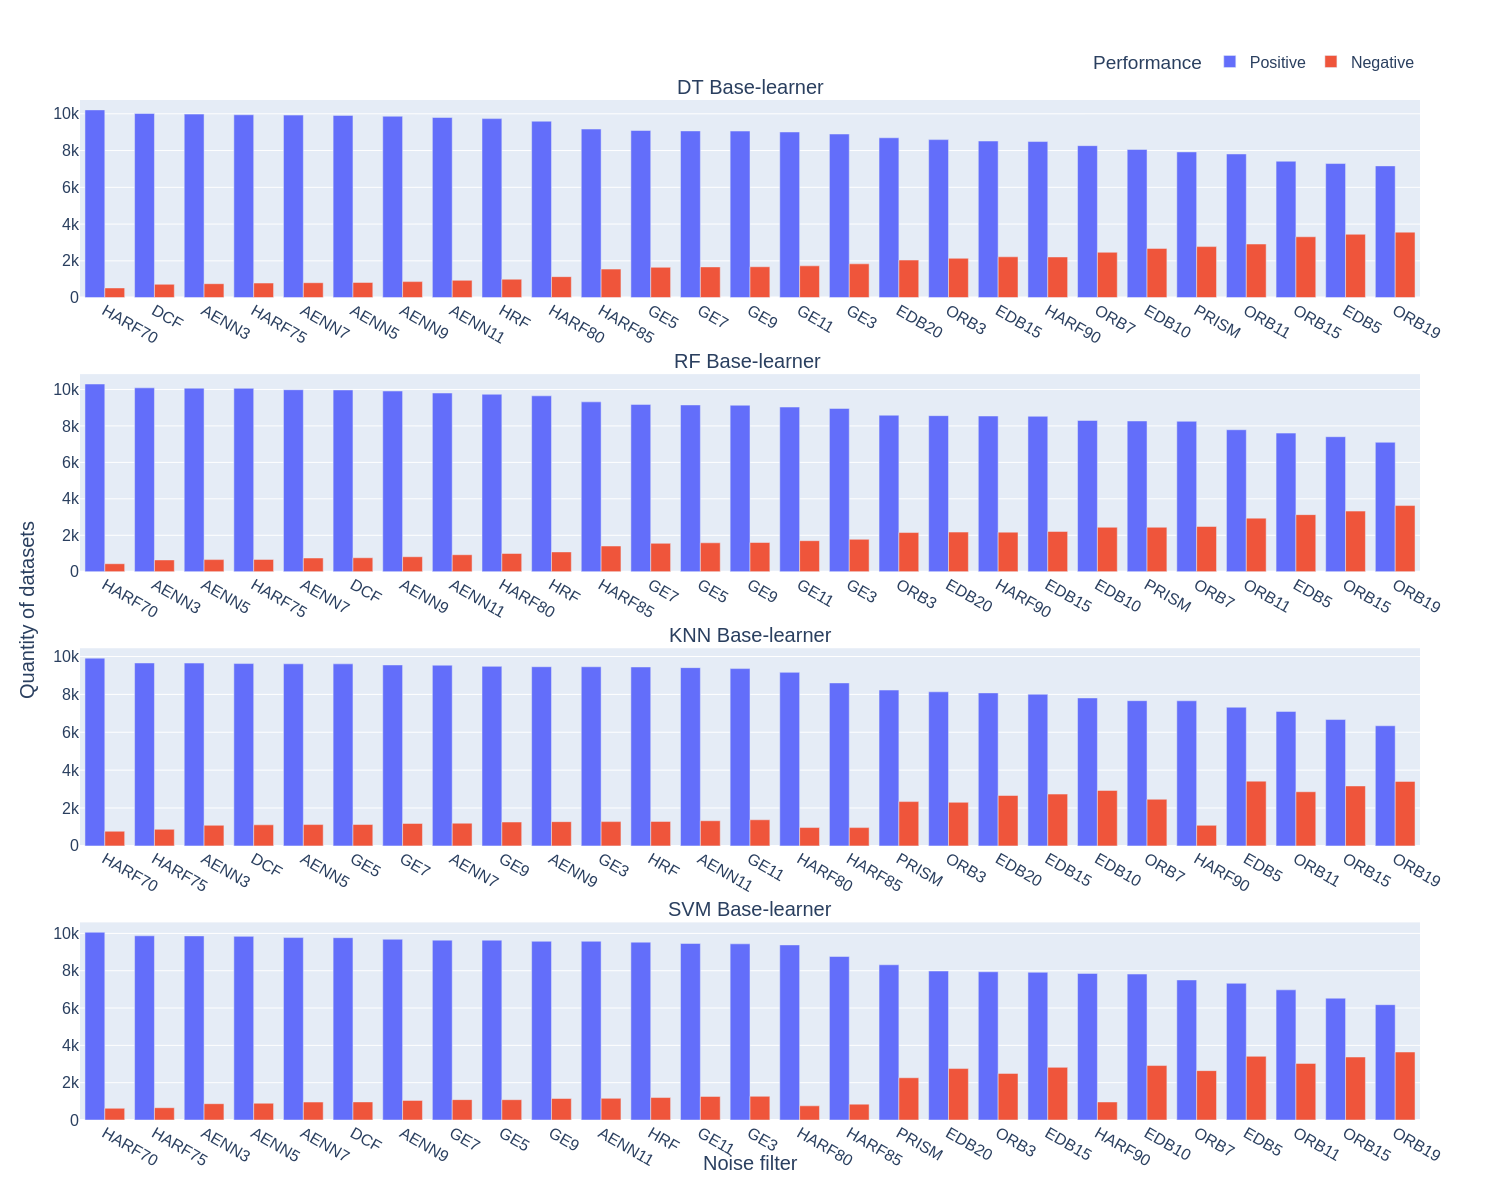

In [17]:
# effectsOnF1['DT'].T[[ 'AENN5', 'EDB15', 'PRISM', 'HARF70', 'GE5',  'DCF', 'HRF','ORB11']].T
effectsOnF1NoHyper = effectsOnF1.copy()


for i in effectsOnF1NoHyper:
     # effectsOnF1NoHyper[i].columns = ['Positive', 'Negative', 'Neutro']
     effectsOnF1NoHyper[i] = effectsOnF1NoHyper[i].T[[ 'AENN5', 'EDB15', 'PRISM', 'HARF70', 'GE5',  'DCF', 'HRF','ORB11']]
     effectsOnF1NoHyper[i].columns = [ 'AENN', 'EDB', 'PRISM', 'HARF', 'GE',  'DCF', 'HRF','ORB']
     effectsOnF1NoHyper[i] = effectsOnF1NoHyper[i].T

fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.075,
                    horizontal_spacing=0.085,
                    x_title='Noise filter',
                    y_title='Quantity of datasets',
                    subplot_titles=('DT Base-learner',  'RF Base-learner ', 
                                    'KNN Base-learner', 'SVM Base-learner'))
row = 1
for i in effectsOnF1:
    print(i)
    effectsOnF1[i].sort_values(by=['Positivo'], ascending=False, inplace = True)
    # fig = go.Figure()
    if row == 1:
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Positivo'].values,
            name = 'Positive',
            marker_color = plotly.colors.qualitative.Plotly[0]
        ), row=row, col=1)
    
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Negativo'].values,
            name = 'Negative',
            marker_color = plotly.colors.qualitative.Plotly[1]
        ), row=row, col=1)
    else:
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Positivo'].values,
            name = 'Positive',
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[0]
        ), row=row, col=1)
    
        fig.add_trace(go.Bar(
            x = effectsOnF1[i].index,
            y = effectsOnF1[i]['Negativo'].values,
            name = 'Negative',
            marker_color = plotly.colors.qualitative.Plotly[1],
            showlegend=False,
        ), row=row, col=1)

    row +=1
# fig.update_layout(
#     autosize=False,
#     yaxis=dict(
#         title_text="Quantidade de datasets",
#         titlefont=dict(size=20),
#     ),
#     xaxis=dict(
#         title_text="Algoritmo de filtro",
#         titlefont=dict(size=20),
#     ),

    
# )

fig.update_layout(
    legend_title="Performance",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        ),
        yaxis = dict(
            tickfont = dict(size=16)),
        xaxis = dict(
            tickfont = dict(size=16))
        )
fig.show(renderer="png", width=1500,
        height=1200)

## Multiple Classifier (tree like)

In [55]:
pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]

test_f1_macro_mean_edgeBoostFilter-5  \
Dataset                                                                    
1004_synthetic_control_10_0.csv.gz                              0.586866   
1004_synthetic_control_10_1.csv.gz                              0.629127   
1004_synthetic_control_10_2.csv.gz                              0.580363   
1004_synthetic_control_10_3.csv.gz                              0.729294   
1004_synthetic_control_10_4.csv.gz                              0.574948   
...                                                                  ...   
997_balance-scale_5_5.csv.gz                                    0.485540   
997_balance-scale_5_6.csv.gz                                    0.510978   
997_balance-scale_5_7.csv.gz                                    0.535679   
997_balance-scale_5_8.csv.gz                                    0.516522   
997_balance-scale_5_9.csv.gz                                    0.498464   

                                    test_f1_macro_mean_edgeBoostFilter-20  \
Dataset                                                                     
1004_synthetic_control_10_0.csv.gz                               0.932846   
1004_synthetic_control_10_1.csv.gz                               0.957985   
1004_synthetic_control_10_2.csv.gz                               0.952054   
1004_synthetic_control_10_3.csv.gz                               0.840657   
1004_synthetic_control_10_4.csv.gz                               0.908058   
...                                                                   ...   
997_balance-scale_5_5.csv.gz                                     0.558748   
997_balance-scale_5_6.csv.gz                                     0.697462   
997_balance-scale_5_7.csv.gz                                     0.650123   
997_balance-scale_5_8.csv.gz                                     0.584064   
997_balance-scale_5_9.csv.gz                                     0.565422   

                                    test_f1_macro_mean_HARF-85  \
Dataset                                                          
1004_synthetic_control_10_0.csv.gz                    0.814147   
1004_synthetic_control_10_1.csv.gz                    0.831395   
1004_synthetic_control_10_2.csv.gz                    0.767520   
1004_synthetic_control_10_3.csv.gz                    0.862629   
1004_synthetic_control_10_4.csv.gz                    0.714637   
...                                                        ...   
997_balance-scale_5_5.csv.gz                          0.594710   
997_balance-scale_5_6.csv.gz                          0.586650   
997_balance-scale_5_7.csv.gz                          0.561552   
997_balance-scale_5_8.csv.gz                          0.658640   
997_balance-scale_5_9.csv.gz                          0.568354   

                                    test_f1_macro_mean_hybridRepairFilter  \
Dataset                                                                     
1004_synthetic_control_10_0.csv.gz                               0.936453   
1004_synthetic_control_10_1.csv.gz                               0.900882   
1004_synthetic_control_10_2.csv.gz                               0.959666   
1004_synthetic_control_10_3.csv.gz                               0.962733   
1004_synthetic_control_10_4.csv.gz                               0.921440   
...                                                                   ...   
997_balance-scale_5_5.csv.gz                                     0.597701   
997_balance-scale_5_6.csv.gz                                     0.586908   
997_balance-scale_5_7.csv.gz                                     0.611043   
997_balance-scale_5_8.csv.gz                                     0.586391   
997_balance-scale_5_9.csv.gz                                     0.643201   

                                    test_f1_macro_mean_edgeBoostFilter-15  \
Dataset                                                                     
1004_synthetic_control_10_0.cs

### With Hyper parameters

In [56]:
# metabasesMultipleClass = {'DT': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_KNN.csv.zip', index_col='Dataset') }
metabasesMultipleClass = {'DT': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_KNN.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_SVM.csv.zip', index_col='Dataset') }

for i in metabasesMultipleClass:
    metabasesMultipleClass[i]['BestType'].replace('Distance', 'Distância', inplace=True)
    metabasesMultipleClass[i]['BestType'].replace('Voting', 'Votação', inplace=True)
    metabasesMultipleClass[i]['BestEnsambleAlgo'].replace('ORBoost', 'ORB', inplace=True)
    metabasesMultipleClass[i]['BestEnsambleAlgo'].replace('Edge', 'EDB', inplace=True)
    metabasesMultipleClass[i]['BestVotingAlgo'].replace('Dynamic', 'DCF', inplace=True)
    metabasesMultipleClass[i]['BestVotingAlgo'].replace('Hybrid', 'HRF', inplace=True)

# def displayChartAlgoDistribution(metabasesMultipleClass, columnsName):
#     fig = go.Figure()
#     for i in metabasesMultipleClass:
#         fig.add_trace(go.Bar(
#         x = metabasesMultipleClass[i][columnsName].value_counts().index,
#         y = metabasesMultipleClass[i][columnsName].value_counts().values,
#         name= f'{i}'
#         ))
#     fig.update_layout(
#         autosize=False,
#         width=800,
#         height=1000,
#         legend_title="Base-Learner",
#         legend=dict(
#         orientation="h",
#         yanchor="bottom",
#         y=1.02,
#         xanchor="right",
#         x=1
#         ),
#         yaxis=dict(
#             title_text="Quantidade de datasets",
#             titlefont=dict(size=20),
#         ),
#         xaxis=dict(
#             title_text="Algoritmo",
#             titlefont=dict(size=20),
#         ),
#     )
#     fig.show(renderer="png", width=600,
#             height=400)

In [71]:
def displayChartAlgoDistribution(metabasesMultipleClass):
    fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.095,
                    x_title='Algoritmo de filtro',
                    y_title='Quantidade de datasets',
                    subplot_titles=('Distribuição tipo de Algoritmo',  'Distribuição algoritmo de Votação', 
                                    'Distribuição algoritmo de Ensemble', 'Distribuição algoritmo de Distância'))
    row = 1
    col = 1
    for j in ['BestType', 'BestVotingAlgo', 'BestEnsambleAlgo', 'BestDistanceAlgo']:
        count = 0
        for i in metabasesMultipleClass:
            fig.add_trace(go.Bar(
            x = metabasesMultipleClass[i][j].value_counts().index,
            y = metabasesMultipleClass[i][j].value_counts().values,
            name= f'{i}',
            marker_color = plotly.colors.qualitative.Plotly[count],
            showlegend=(row == 1 and col == 1),
            ),
            col = col,
            row = row)
            count +=1
        col +=1
        if col > 2:
            row+=1
            col = 1
    # fig.update_layout(
    #     autosize=False,
    #     width=800,
    #     height=1000,
    #     legend_title="Base-Learner",
    #     legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1
    #     ),
    #     yaxis=dict(
    #         title_text="Quantidade de datasets",
    #         titlefont=dict(size=20),
    #     ),
    #     xaxis=dict(
    #         title_text="Algoritmo",
    #         titlefont=dict(size=20),
    #     ),
    # )
    fig.update_layout(
    legend_title="Base-Learner",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=18,
        ),
        yaxis = dict(
            tickfont = dict(size=18)),
        xaxis = dict(
            tickfont = dict(size=18))
    )
    fig.show(renderer="png", width=1300,
            height=900)

def displayChartAlgoDistributionEnglish(metabasesMultipleClass):
    fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.095,
                    x_title='Noise filter',
                    y_title='Quantity of datasets',
                    subplot_titles=('Filter type',  'Voting filter', 
                                    'Ensemble filter', 'Distance filter'))
    row = 1
    col = 1
    for j in ['BestType', 'BestVotingAlgo', 'BestEnsambleAlgo', 'BestDistanceAlgo']:
        count = 0
        for i in metabasesMultipleClass:
            fig.add_trace(go.Bar(
            x = metabasesMultipleClass[i][j].replace('Distância', 'Distance').replace('Votação', 'Voting').value_counts().index,
            y = metabasesMultipleClass[i][j].replace('Distância', 'Distance').replace('Votação', 'Voting').value_counts().values,
            name= f'{i}',
            marker_color = plotly.colors.qualitative.Plotly[count],
            showlegend=(row == 1 and col == 1),
            ),
            col = col,
            row = row)
            count +=1
        col +=1
        if col > 2:
            row+=1
            col = 1
    # fig.update_layout(
    #     autosize=False,
    #     width=800,
    #     height=1000,
    #     legend_title="Base-Learner",
    #     legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1
    #     ),
    #     yaxis=dict(
    #         title_text="Quantidade de datasets",
    #         titlefont=dict(size=20),
    #     ),
    #     xaxis=dict(
    #         title_text="Algoritmo",
    #         titlefont=dict(size=20),
    #     ),
    # )
    fig.update_layout(
    legend_title="Base-Learner",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=20,
        ),
        yaxis = dict(
            tickfont = dict(size=20)),
        xaxis = dict(
            tickfont = dict(size=20))
    )
    fig.show(renderer="png", width=1050,
            height=750)

#### Best Algo type distributions

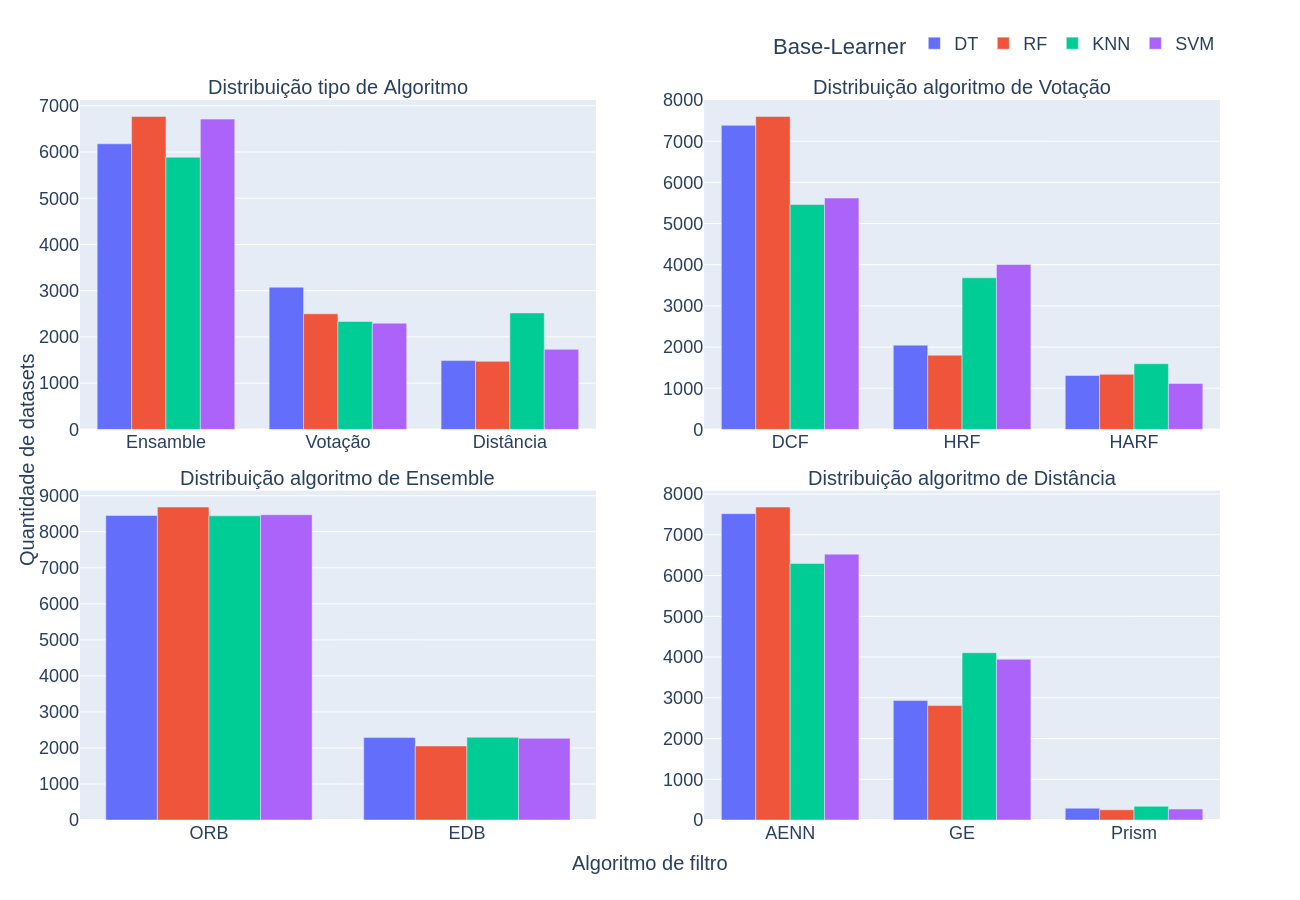

In [69]:
displayChartAlgoDistribution(metabasesMultipleClass)

### Without hyper parameters

In [57]:
# metabasesMultipleClassNoHyper = {'DT': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_DT_NoHyper.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_RF_NoHyper.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_KNN_NoHyper.csv.zip', index_col='Dataset') }
metabasesMultipleClassNoHyper = {'DT': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_DT_NoHyper.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_RF_NoHyper.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_KNN_NoHyper.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/metabases_Multiple_Classifiers/Metabase_SVM_NoHyper.csv.zip', index_col='Dataset') }

for i in metabasesMultipleClassNoHyper:
    metabasesMultipleClassNoHyper[i]['BestType'].replace('Distance', 'Distância', inplace=True)
    metabasesMultipleClassNoHyper[i]['BestType'].replace('Voting', 'Votação', inplace=True)
    metabasesMultipleClassNoHyper[i]['BestEnsambleAlgo'].replace('ORBoost', 'ORB', inplace=True)
    metabasesMultipleClassNoHyper[i]['BestEnsambleAlgo'].replace('Edge', 'EDB', inplace=True)
    metabasesMultipleClassNoHyper[i]['BestVotingAlgo'].replace('Dynamic', 'DCF', inplace=True)
    metabasesMultipleClassNoHyper[i]['BestVotingAlgo'].replace('Hybrid', 'HRF', inplace=True)

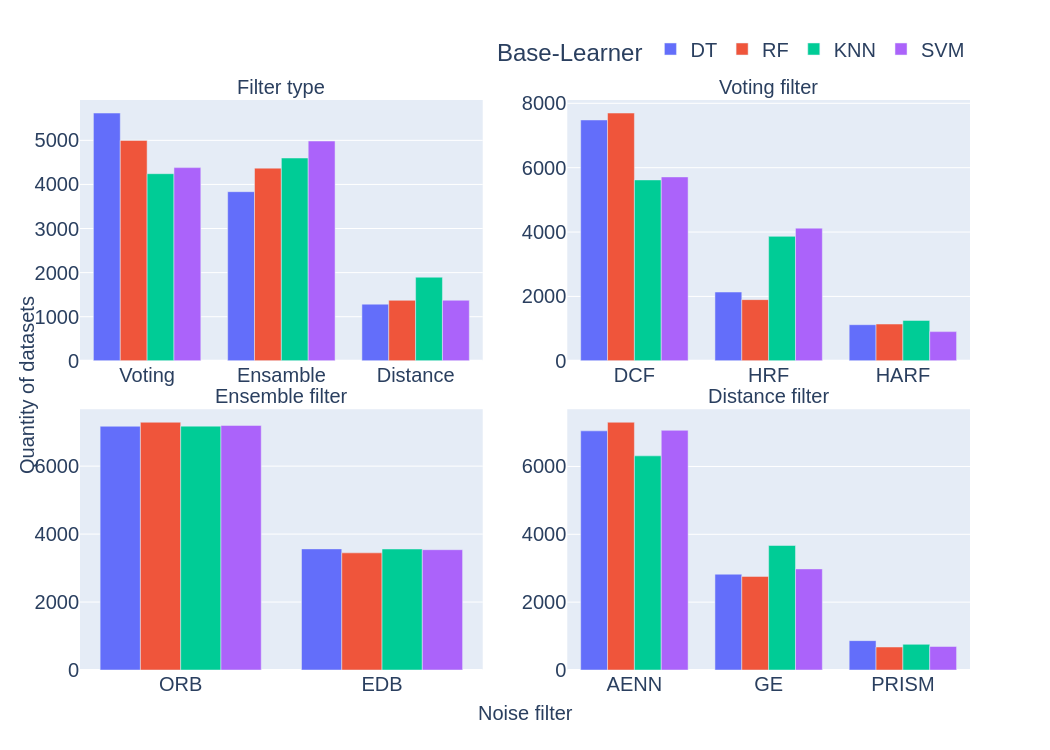

In [72]:
displayChartAlgoDistributionEnglish(metabasesMultipleClassNoHyper)

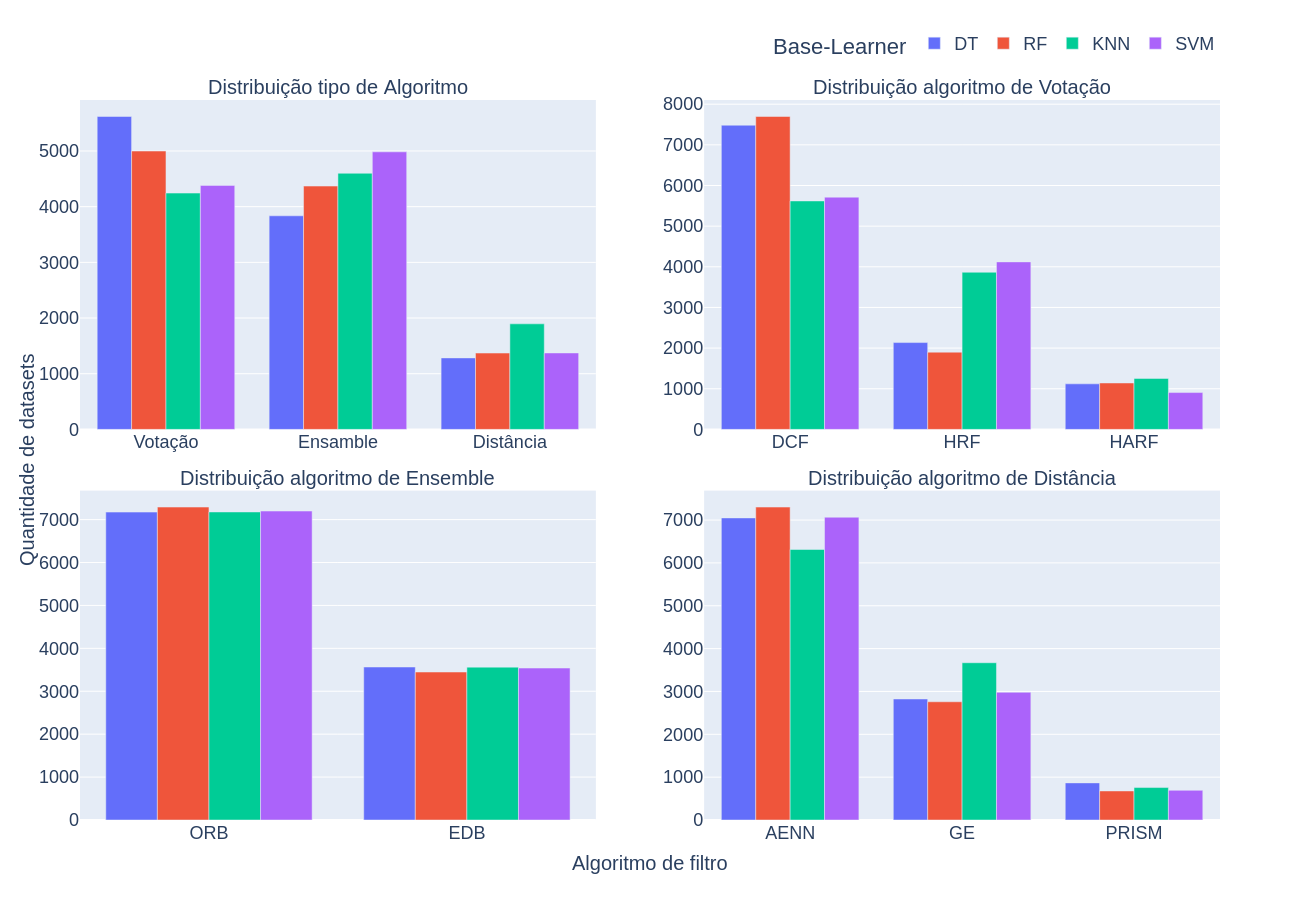

In [74]:
displayChartAlgoDistribution(metabasesMultipleClassNoHyper)

# Base Analysis

## Ranking

### With hyper parameters

In [39]:
# metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset') }
metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset') }
DTCols = metabasesRanking['DT'].iloc[:,97:].columns

cols = ['Edge5', 'Edge20', 'HARF85', 'Hybrid', 'Edge15', 'OR3', 'GE9', 'AENN7',
       'HARF75', 'OR19', 'AENN11', 'AENN9', 'OR11', 'PRISM', 'GE3', 'GE7',
       'OR15', 'Dynamic', 'Edge10', 'HARF80', 'AENN3', 'HARF90', 'OR7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
for i in metabasesRanking:
    metabasesRanking[i] = metabasesRanking[i][DTCols]
    metabasesRanking[i].columns = cols

for i in metabasesRanking:
    noFilterResults = pd.read_csv(f'Results/NoisyDatasets_results{i}.csv.zip', index_col='Unnamed: 0')
    noFilterResults = noFilterResults.rename(columns={'test_f1_macro_mean': 'noFilterResults'})
    noFilterResults.index.name='Dataset'
    metabasesRanking[i]['noFilterResults'] = noFilterResults['noFilterResults'].sort_index()

gain = {}
for i in metabasesRanking:
    gain[i] = metabasesRanking[i].sub(metabasesRanking[i]['noFilterResults'], axis=0)
    gain[i].drop('noFilterResults', axis = 1, inplace = True)

In [40]:
RFPredictRank = pd.read_csv('RankingResults/results_RF_f1-score-DT.csv.zip', index_col='Dataset')
# RFPredictRank.drop('test_f1_macro_mean_AENN', axis=1, inplace=True)

if os.path.isfile('PickleVars/08 - AnalyzeResults/rank2.p'):
    file = open('PickleVars/08 - AnalyzeResults/rank2.p', 'rb')
    rank2 = pickle.load(file)
    file.close()
else:
    rank2 = pd.DataFrame()
    for i, a in enumerate(RFPredictRank.index):
        rank2 = rank2.append(RFPredictRank.iloc[i].rank(method = 'dense', ascending = False))
    file = open('PickleVars/08 - AnalyzeResults/rank2.p', 'wb')
    pickle.dump(rank2, file)
    file.close()


# rank2 = pd.DataFrame()
# for i, a in enumerate(RFPredictRank.index):
#     rank2 = rank2.append(RFPredictRank.iloc[i].rank(method = 'dense', ascending = False))

meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
fixedCols = meta_data.columns
fixedCols2 = ['test_f1_macro_mean_AENN-5', 'test_f1_macro_mean_edgeBoostFilter-15','test_f1_macro_mean_PRISM', 'test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5', 'test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']

def computeMethodGain(predictRankResult, fixedCols, gaindf):
    rank = pd.DataFrame()
    df = predictRankResult[fixedCols]
    for i, a in enumerate(df.index):
        rank = rank.append(df.iloc[i].rank(method = 'dense', ascending = False))
    total = 0
    rank = rank[fixedCols]
    if len(fixedCols)>20:
        rank.columns = ['Edge5', 'Edge20', 'HARF85', 'Hybrid', 'Edge15', 'OR3', 'GE9', 'AENN7',
       'HARF75', 'OR19', 'AENN11', 'AENN9', 'OR11', 'PRISM', 'GE3', 'GE7',
       'OR15', 'Dynamic', 'Edge10', 'HARF80', 'AENN3', 'HARF90', 'OR7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
    else:
        rank.columns = [ 'AENN5', 'Edge15', 'PRISM', 'HARF70', 'GE5', 'Dynamic', 'Hybrid', 'OR11']
    for index, value  in enumerate(rank.idxmin(axis =1)):
        total += gaindf[value].iloc[index]
    return total

predictRankResult = pd.read_csv('RankingResults/results_RF_f1-score-RF.csv.zip', index_col='Dataset')
computeMethodGain(predictRankResult, fixedCols2, gain['RF'])


2373.223202884717

In [41]:
def getFolderFilesList(path):
    return [filename for filename in listdir(path) if isfile(join(path, filename))]
resultNameList = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('RankingResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)

resultNameList

gainMetabase = None
usedCols = None
MtLRankingGain = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLRankingGain.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingGain.p', 'rb')
    MtLRankingGain = pickle.load(file)
    file.close()
else:
    for i in resultNameList:
        for resultFileName in resultNameList[i]:
            predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLRankingGain[i][f'MtL-RF'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
            if '_GB'in resultFileName:
                MtLRankingGain[i][f'MtL-GB'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
            if '_KNN'in resultFileName:
                MtLRankingGain[i][f'MtL-KNN'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingGain.p', 'wb')
    pickle.dump(MtLRankingGain, file)
    file.close()
    MtLRankingGain

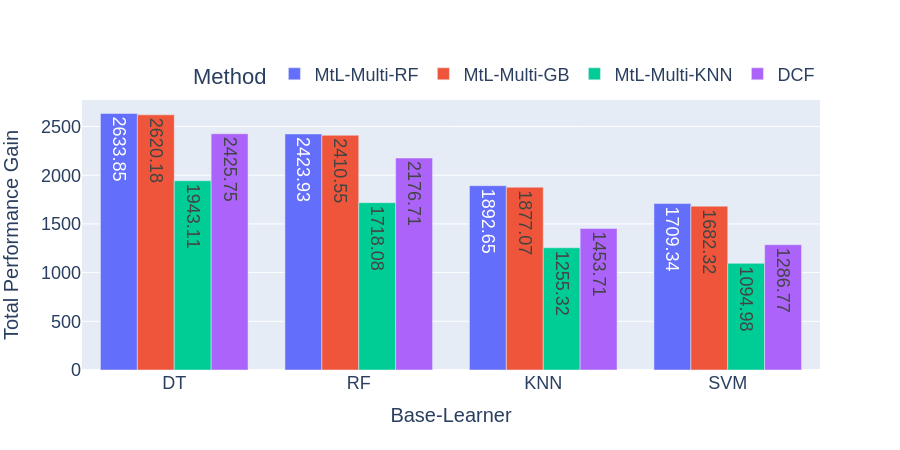

In [49]:
def plotMtLGain(MtLGain):
    df = pd.DataFrame()
    df0 = pd.DataFrame.from_dict(MtLGain['DT'])
    df1 = pd.DataFrame.from_dict(MtLGain['RF'])
    df2 = pd.DataFrame.from_dict(MtLGain['KNN'])
    df3 = pd.DataFrame.from_dict(MtLGain['SVM'])
    df0['Dynamic'] = gain['DT'].sum()['Dynamic']
    df1['Dynamic'] = gain['RF'].sum()['Dynamic']
    df2['Dynamic'] = gain['KNN'].sum()['Dynamic']
    df3['Dynamic'] = gain['SVM'].sum()['Dynamic']

    df0 = df0.T
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    df0['Baselearner'] = 'DT'
    df1['Baselearner'] = 'RF'
    df2['Baselearner'] = 'KNN'
    df3['Baselearner'] = 'SVM'

    df = pd.concat([df0, df1, df2, df3])
    df['type'] = df.index

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-RF'][0].values,
            x = df[df['type'] == 'MtL-RF']['Baselearner'].values,
            name= 'MtL-Multi-RF',
            text = np.around(df[df['type'] == 'MtL-RF'][0].values, 2),
        ))
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-GB'][0].values,
            x = df[df['type'] == 'MtL-GB']['Baselearner'].values,
            name= 'MtL-Multi-GB',
            text = np.around(df[df['type'] == 'MtL-GB'][0].values, 2),

        ))
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-KNN'][0].values,
            x = df[df['type'] == 'MtL-KNN']['Baselearner'].values,
            name= 'MtL-Multi-KNN',
            text = np.around(df[df['type'] == 'MtL-KNN'][0].values, 2),
            
        ))
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'Dynamic'][0].values,
            x = df[df['type'] == 'Dynamic']['Baselearner'].values,
            name= 'DCF',
            text = np.around(df[df['type'] == 'Dynamic'][0].values, 2),

        ))
    fig.update_layout(
        legend_title="Method",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
            ),
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Total Performance Gain",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Base-Learner",
            titlefont=dict(size=20),
        ),
        font=dict(
            size=18,
        )
    )

    fig.show(renderer="png", width=900,
                height=450)
plotMtLGain(MtLRankingGain)

### without Hyper Parameters

In [42]:
gainMetabase = None
usedCols = None
MtLRankingGainNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLRankingGainNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingGainNoHyper.p', 'rb')
    MtLRankingGainNoHyper = pickle.load(file)
    file.close()
else:

    for i in resultNameListNoHyper:
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-RF'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
            if '_GB'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-GB'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
            if '_KNN'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-KNN'] = [computeMethodGain(predictRankResult, usedCols, gain[i])]
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingGainNoHyper.p', 'wb')
    pickle.dump(MtLRankingGainNoHyper, file)
    file.close()
MtLRankingGainNoHyper

{'RF': {'MtL-GB': [2361.8595483327417],
  'MtL-RF': [2362.171903110022],
  'MtL-KNN': [1820.247839421508]},
 'DT': {'MtL-KNN': [2031.1826255222984],
  'MtL-GB': [2588.8118916914127],
  'MtL-RF': [2582.9961996735783]},
 'KNN': {'MtL-RF': [1766.0008249183604],
  'MtL-GB': [1724.0897895038706],
  'MtL-KNN': [1185.1068826712751]},
 'SVM': {'MtL-RF': [1625.2777944043228],
  'MtL-KNN': [1029.1960402986408],
  'MtL-GB': [1564.7323675584696]}}

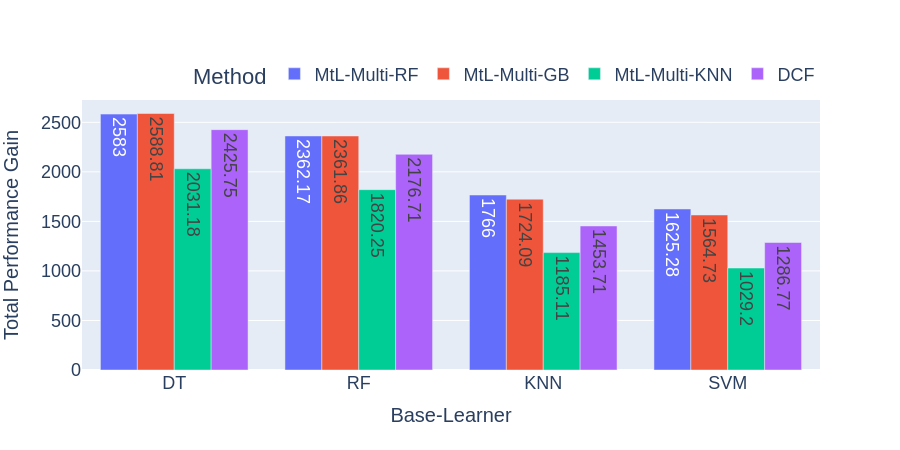

In [51]:
plotMtLGain(MtLRankingGainNoHyper)

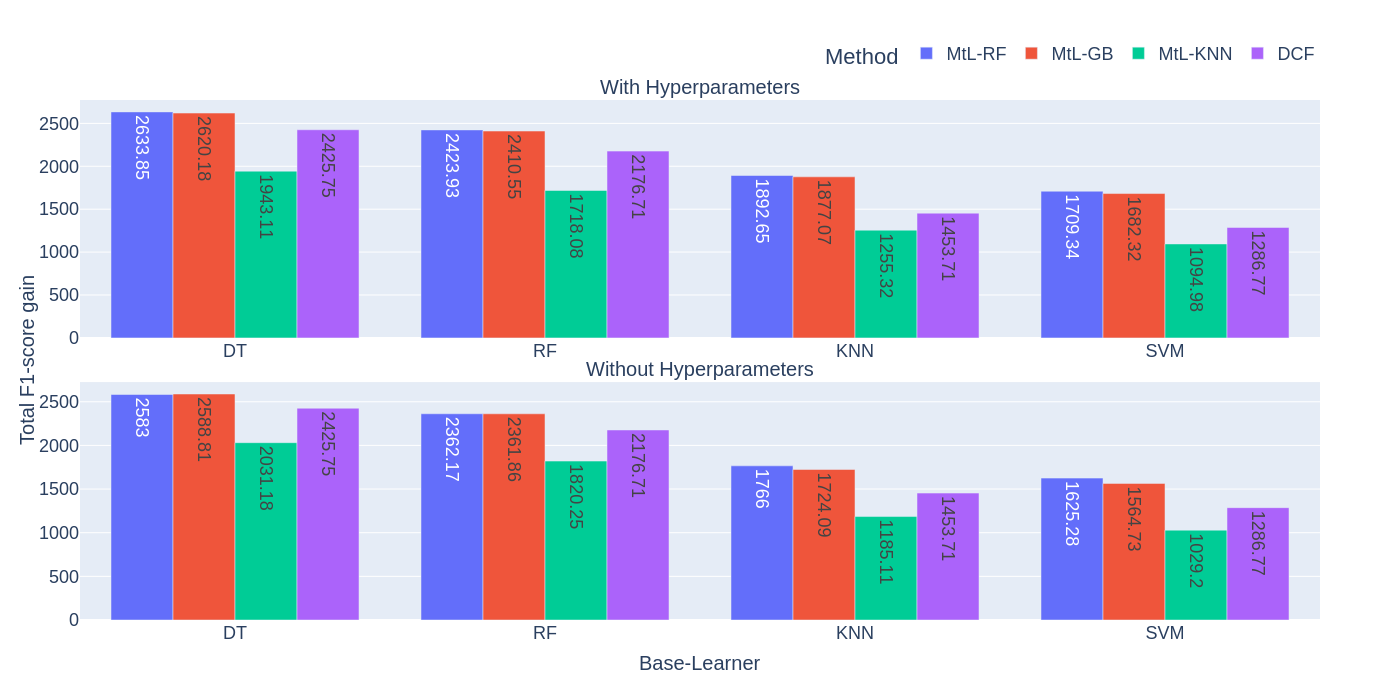

In [61]:
def subplotMtLGain(MtLGain, MtLGainNoHyper):
    df = pd.DataFrame()
    df0 = pd.DataFrame.from_dict(MtLGain['DT'])
    df1 = pd.DataFrame.from_dict(MtLGain['RF'])
    df2 = pd.DataFrame.from_dict(MtLGain['KNN'])
    df3 = pd.DataFrame.from_dict(MtLGain['SVM'])
    df0['Dynamic'] = gain['DT'].sum()['Dynamic']
    df1['Dynamic'] = gain['RF'].sum()['Dynamic']
    df2['Dynamic'] = gain['KNN'].sum()['Dynamic']
    df3['Dynamic'] = gain['SVM'].sum()['Dynamic']

    df0 = df0.T
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    df0['Baselearner'] = 'DT'
    df1['Baselearner'] = 'RF'
    df2['Baselearner'] = 'KNN'
    df3['Baselearner'] = 'SVM'

    df = pd.concat([df0, df1, df2, df3])
    df['type'] = df.index

    # fig = go.Figure()
    fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.085,
                    x_title='Base-Learner',
                    y_title='Total F1-score gain',
                    subplot_titles=('With Hyperparameters',  'Without Hyperparameters'))
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-RF'][0].values,
            x = df[df['type'] == 'MtL-RF']['Baselearner'].values,
            name= 'MtL-RF',
            text = np.around(df[df['type'] == 'MtL-RF'][0].values, 2),
        ),col =1, row=1)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-GB'][0].values,
            x = df[df['type'] == 'MtL-GB']['Baselearner'].values,
            name= 'MtL-GB',
            text = np.around(df[df['type'] == 'MtL-GB'][0].values, 2),

        ),col =1, row=1)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-KNN'][0].values,
            x = df[df['type'] == 'MtL-KNN']['Baselearner'].values,
            name= 'MtL-KNN',
            text = np.around(df[df['type'] == 'MtL-KNN'][0].values, 2),
            
        ),col =1, row=1)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'Dynamic'][0].values,
            x = df[df['type'] == 'Dynamic']['Baselearner'].values,
            name= 'DCF',
            text = np.around(df[df['type'] == 'Dynamic'][0].values, 2),

        ),col =1, row=1)


    df = pd.DataFrame()
    df0 = pd.DataFrame.from_dict(MtLGainNoHyper['DT'])
    df1 = pd.DataFrame.from_dict(MtLGainNoHyper['RF'])
    df2 = pd.DataFrame.from_dict(MtLGainNoHyper['KNN'])
    df3 = pd.DataFrame.from_dict(MtLGainNoHyper['SVM'])
    df0['Dynamic'] = gain['DT'].sum()['Dynamic']
    df1['Dynamic'] = gain['RF'].sum()['Dynamic']
    df2['Dynamic'] = gain['KNN'].sum()['Dynamic']
    df3['Dynamic'] = gain['SVM'].sum()['Dynamic']

    df0 = df0.T
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    df0['Baselearner'] = 'DT'
    df1['Baselearner'] = 'RF'
    df2['Baselearner'] = 'KNN'
    df3['Baselearner'] = 'SVM'

    df = pd.concat([df0, df1, df2, df3])
    df['type'] = df.index

    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-RF'][0].values,
            x = df[df['type'] == 'MtL-RF']['Baselearner'].values,
            name= 'MtL-RF',
            text = np.around(df[df['type'] == 'MtL-RF'][0].values, 2),
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[0]
        ),col =1, row=2)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-GB'][0].values,
            x = df[df['type'] == 'MtL-GB']['Baselearner'].values,
            name= 'MtL-GB',
            text = np.around(df[df['type'] == 'MtL-GB'][0].values, 2),
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[1]
        ),col =1, row=2)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'MtL-KNN'][0].values,
            x = df[df['type'] == 'MtL-KNN']['Baselearner'].values,
            name= 'MtL-KNN',
            text = np.around(df[df['type'] == 'MtL-KNN'][0].values, 2),
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[2]
        ),col =1, row=2)
    fig.add_trace(
        go.Bar(
            y = df[df['type'] == 'Dynamic'][0].values,
            x = df[df['type'] == 'Dynamic']['Baselearner'].values,
            name= 'DCF',
            text = np.around(df[df['type'] == 'Dynamic'][0].values, 2),
            showlegend=False,
            marker_color = plotly.colors.qualitative.Plotly[3]
        ),col =1, row=2)


    fig.update_layout(
    legend_title="Method",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=18,
        ),
        yaxis = dict(
            tickfont = dict(size=18)),
        xaxis = dict(
            tickfont = dict(size=18))
    )
    fig.update_traces(textangle=90)
    fig.show(renderer="png", width=1400,
                height=700)
subplotMtLGain(MtLRankingGain, MtLRankingGainNoHyper)

## Multi Class

In [90]:
def returnSelectedAlgorithms(df = None):
    best_algo ={}
    for index, row in df.iterrows():
        best_algo[index] = row[f'Best{row["BestType"]}Algo']
        if best_algo[index] == 'ORBoost':
            best_algo[index] = row['BestOR']
        if best_algo[index] == 'AENN':
            best_algo[index] = row['BestAenn']
        if best_algo[index] == 'GE':
            best_algo[index] = row['BestGE']
        if best_algo[index] == 'HARF':
            best_algo[index]= row['BestHARF']
        if best_algo[index] == 'Edge':
            best_algo[index] = row['BestEdge']
    return pd.DataFrame.from_dict(best_algo, orient= 'index', columns=["SelectedAlgo"])

def returnSelectedAlgorithmsNoHyper(df = None):
    best_algo ={}
    for index, row in df.iterrows():
        best_algo[index] = row[f'Best{row["BestType"]}Algo']
    return pd.DataFrame.from_dict(best_algo, orient= 'index', columns=["SelectedAlgo"])


def getBestAlgorithmsListNoHyper(metabase):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    meta_data.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15',  'OR3','GE9', 'AENN7',
        'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
        'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
        'GE5', 'AENN5','GE11']
    meta_data = meta_data[['GE5', 'AENN5', 'HARF70', 'Edge15', 'PRISM', 'Hybrid',  'OR11', 'Dynamic']]
    meta_data.columns = ['GE', 'AENN', 'HARF', 'Edge', 'PRISM', 'Hybrid',  'ORBoost', 'Dynamic']

    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    # rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
    #    'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
    #    'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
    #    'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row == 1].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

def getBestAlgorithmsList(metabase):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    
    rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
       'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
       'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
       'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row == 1].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

In [91]:
# df = pd.read_csv(f'MultipleClassifierResults/results_Multiple_RF_f1-score-DT-Hyper.csv.zip', index_col='Dataset')
df = pd.read_csv(f'MultipleClassifierResults/results_Multiple_RF_f1-score-DT-Hyper.csv.zip', index_col='Dataset')
display (df)
df0 = returnSelectedAlgorithms(df)
bestalgoList, bestalgoDict =  getBestAlgorithmsList("DT")
df0['Best'] = bestalgoList
df0

BestType BestEnsambleAlgo  \
Dataset                                                         
1004_synthetic_control_10_0.csv.gz  Ensamble          ORBoost   
1004_synthetic_control_10_1.csv.gz  Ensamble          ORBoost   
1004_synthetic_control_10_2.csv.gz  Ensamble          ORBoost   
1004_synthetic_control_10_3.csv.gz  Ensamble          ORBoost   
1004_synthetic_control_10_4.csv.gz  Ensamble          ORBoost   
...                                      ...              ...   
997_balance-scale_5_5.csv.gz        Ensamble          ORBoost   
997_balance-scale_5_6.csv.gz        Ensamble          ORBoost   
997_balance-scale_5_7.csv.gz        Ensamble          ORBoost   
997_balance-scale_5_8.csv.gz          Voting          ORBoost   
997_balance-scale_5_9.csv.gz          Voting          ORBoost   

                                   BestDistanceAlgo BestVotingAlgo BestAenn  \
Dataset                                                                       
1004_synthetic_control_10_0.csv.gz             AENN        Dynamic   AENN11   
1004_synthetic_control_10_1.csv.gz             AENN        Dynamic   AENN11   
1004_synthetic_control_10_2.csv.gz             AENN        Dynamic   AENN11   
1004_synthetic_control_10_3.csv.gz             AENN        Dynamic   AENN11   
1004_synthetic_control_10_4.csv.gz             AENN        Dynamic   AENN11   
...                                             ...            ...      ...   
997_balance-scale_5_5.csv.gz                   AENN        Dynamic    AENN9   
997_balance-scale_5_6.csv.gz                   AENN        Dynamic   AENN11   
997_balance-scale_5_7.csv.gz                   AENN        Dynamic   AENN11   
997_balance-scale_5_8.csv.gz                   AENN        Dynamic    AENN9   
997_balance-scale_5_9.csv.gz                   AENN        Dynamic    AENN9   

                                   BestGE BestOR BestEdge BestHARF  
Dataset                                                             
1004_synthetic_control_10_0.csv.gz    GE9    OR3   Edge20   HARF70  
1004_synthetic_control_10_1.csv.gz    GE9    OR3   Edge20   HARF70  
1004_synthetic_control_10_2.csv.gz   GE11    OR7   Edge15   HARF70  
1004_synthetic_control_10_3.csv.gz    GE9    OR3   Edge20   HARF70  
1004_synthetic_control_10_4.csv.gz    GE9    OR7   Edge15   HARF70  
...                                   ...    ...      ...      ...  
997_balance-scale_5_5.csv.gz         GE11    OR3   Edge20   HARF70  
997_balance-scale_5_6.csv.gz          GE9    OR3   Edge20   HARF70  
997_balance-scale_5_7.csv.gz         GE11    OR3   Edge20   HARF70  
997_balance-scale_5_8.csv.gz         GE11   OR19   Edge20   HARF70  
997_balance-scale_5_9.csv.gz         GE11    OR3   Edge20   HARF70  

[10740 rows x 9 columns]

SelectedAlgo      Best
1004_synthetic_control_10_0.csv.gz          OR3   [Edge5]
1004_synthetic_control_10_1.csv.gz          OR3  [HARF90]
1004_synthetic_control_10_2.csv.gz          OR7  [AENN11]
1004_synthetic_control_10_3.csv.gz          OR3    [GE11]
1004_synthetic_control_10_4.csv.gz          OR7     [GE7]
...                                         ...       ...
997_balance-scale_5_5.csv.gz                OR3  [HARF85]
997_balance-scale_5_6.csv.gz                OR3  [Edge20]
997_balance-scale_5_7.csv.gz                OR3  [Edge15]
997_balance-scale_5_8.csv.gz            Dynamic  [Edge15]
997_balance-scale_5_9.csv.gz            Dynamic  [Hybrid]

[10740 rows x 2 columns]

In [92]:
def getFolderFilesList(path):
    return [filename for filename in listdir(path) if isfile(join(path, filename))]
resultNameList = {'RF': [], 'DT': [], 'KNN': [],'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('MultipleClassifierResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)
resultNameList

{'RF': ['results_Multiple_KNN_f1-score-RF-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-RF.csv.zip',
  'results_Multiple_RF_f1-score-RF-Hyper.csv.zip'],
 'DT': ['results_Multiple_RF_f1-score-DT-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-DT.csv.zip',
  'results_Multiple_KNN_f1-score-DT-Hyper.csv.zip'],
 'KNN': ['results_Multiple_GB_f1-score-KNN.csv.zip',
  'results_Multiple_KNN_f1-score-KNN-Hyper.csv.zip',
  'results_Multiple_RF_f1-score-KNN-Hyper.csv.zip'],
 'SVM': ['results_Multiple_KNN_f1-score-SVM-Hyper.csv.zip',
  'results_Multiple_RF_f1-score-SVM-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-SVM.csv.zip']}

In [93]:
df0 [df0['SelectedAlgo'].isin(df0['Best'])]
arr = []
for index, row in df0.iterrows():
    arr.append(row['SelectedAlgo'] in row['Best'])
sum(arr)

391

In [94]:
gainMetabase = None
usedCols = None
MtLClassGain = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLClassGain.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLClassGain.p', 'rb')
    MtLClassGain = pickle.load(file)
    file.close()
else:
    for i in resultNameList:
        for resultFileName in resultNameList[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithms(predictRankResult)
            df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            
            total = 0
            for index, row in df0.iterrows():
                total += gain[i].loc[index][row['SelectedAlgo']]
            # df0['SelectedAlgo'].value_counts()
            total

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassGain[i][f'MtL-RF'] = [total]
            if '_GB'in resultFileName:
                MtLClassGain[i][f'MtL-GB'] = [total]
            if '_KNN'in resultFileName:
                MtLClassGain[i][f'MtL-KNN'] = [total]
    file = open('PickleVars/08 - AnalyzeResults/MtLClassGain.p', 'wb')
    pickle.dump(MtLClassGain, file)
    file.close()
display(MtLClassGain)

gainMetabase = None
usedCols = None
MtLClassGainNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLClassGainNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLClassGainNoHyper.p', 'rb')
    MtLClassGainNoHyper = pickle.load(file)
    file.close()
else:
    for i in resultNameListNoHyper:
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithmsNoHyper(predictRankResult)
            df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            
            total = 0
            for index, row in df0.iterrows():
                total += gain[i].loc[index][row['SelectedAlgo']]
            # df0['SelectedAlgo'].value_counts()
            total

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-RF'] = [total]
            if '_GB'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-GB'] = [total]
            if '_KNN'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-KNN'] = [total]
    file = open('PickleVars/08 - AnalyzeResults/MtLClassGainNoHyper.p', 'wb')
    pickle.dump(MtLClassGainNoHyper, file)
    file.close()
MtLClassGainNoHyper

{'RF': {'MtL-RF': [1810.103809518364],
  'MtL-GB': [1849.528740424411],
  'MtL-KNN': [1334.1792977707426]},
 'DT': {'MtL-GB': [2047.3863221321474],
  'MtL-KNN': [1607.3251987874048],
  'MtL-RF': [2055.260728683432]},
 'KNN': {'MtL-KNN': [1157.2155779344205],
  'MtL-RF': [1567.5885034668013],
  'MtL-GB': [1586.4150637031503]},
 'SVM': {'MtL-GB': [1340.9258081473918],
  'MtL-RF': [1393.8733892816456],
  'MtL-KNN': [1063.1776747975337]}}

{'RF': {'MtL-RF': [1961.254323054394],
  'MtL-GB': [1889.975437878757],
  'MtL-KNN': [1429.861632797424]},
 'DT': {'MtL-KNN': [1784.850209769302],
  'MtL-GB': [2250.4307876371236],
  'MtL-RF': [2371.4966130265425]},
 'KNN': {'MtL-GB': [1428.1816433734818],
  'MtL-RF': [1495.265303040549],
  'MtL-KNN': [1009.6576292201772]},
 'SVM': {'MtL-RF': [1209.3106370913886],
  'MtL-GB': [1175.4157631405187],
  'MtL-KNN': [820.4411860460517]}}

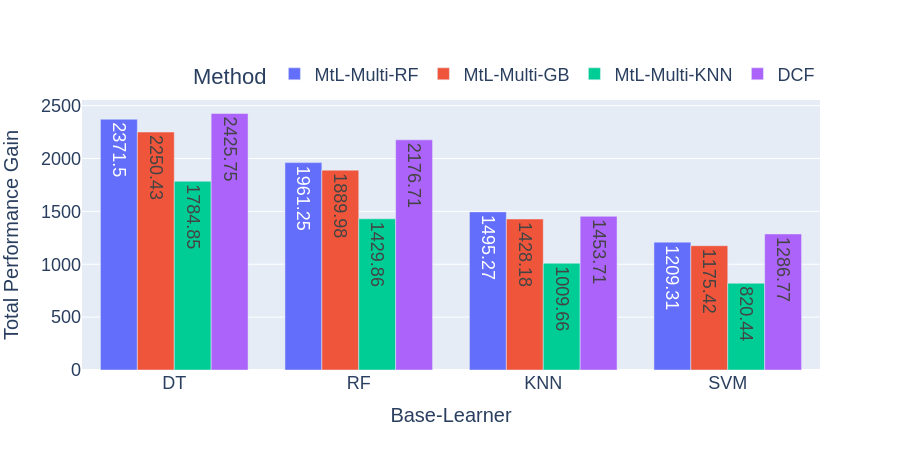

NameError: name 'subplotMtLGain' is not defined

In [97]:
# plotMtLGain(MtLClassGain)
plotMtLGain(MtLClassGainNoHyper)
subplotMtLGain(MtLClassGain, MtLClassGainNoHyper)

# Meta Analysis

## Ranking

In [32]:
if os.path.isfile('PickleVars/08 - AnalyzeResults/ranks.p'):
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'rb')
    ranks = pickle.load(file)
    file.close()
else:
    ranks = buildRanks(metabasesRanking)
    file = open('PickleVars/08 - AnalyzeResults/ranks.p', 'wb')
    pickle.dump(ranks, file)
    file.close()
    
ranks['DT']

AENN11  AENN3  AENN5  AENN7  AENN9   DCF  \
1004_synthetic_control_10_0.csv.gz     1.0   16.0   18.0   10.0    2.0   6.0   
1004_synthetic_control_10_1.csv.gz     5.0   22.0   19.0    6.0   18.0   1.0   
1004_synthetic_control_10_2.csv.gz     7.0   17.0   16.0   13.0   10.0   2.0   
1004_synthetic_control_10_3.csv.gz     3.0   16.0   18.0    3.0    4.0  10.0   
1004_synthetic_control_10_4.csv.gz     4.0   21.0   13.0   15.0   20.0   7.0   
...                                    ...    ...    ...    ...    ...   ...   
997_balance-scale_5_5.csv.gz           3.0    4.0    1.0    5.0    2.0   6.0   
997_balance-scale_5_6.csv.gz           4.0    1.0    5.0    3.0    2.0   8.0   
997_balance-scale_5_7.csv.gz           5.0    4.0    3.0    2.0    1.0   6.0   
997_balance-scale_5_8.csv.gz           3.0    5.0    4.0    2.0    1.0  19.0   
997_balance-scale_5_9.csv.gz           2.0    4.0    3.0    1.0    2.0  10.0   

                                    EDB10  EDB15  EDB20  EDB5  ...  HARF80  \
1004_synthetic_control_10_0.csv.gz   23.0   22.0   12.0  26.0  ...    19.0   
1004_synthetic_control_10_1.csv.gz   27.0   26.0    2.0  25.0  ...    17.0   
1004_synthetic_control_10_2.csv.gz   27.0   24.0   12.0  26.0  ...    20.0   
1004_synthetic_control_10_3.csv.gz   24.0   19.0   20.0  23.0  ...    15.0   
1004_synthetic_control_10_4.csv.gz   25.0   16.0   12.0  27.0  ...     5.0   
...                                   ...    ...    ...   ...  ...     ...   
997_balance-scale_5_5.csv.gz         25.0   27.0   22.0  26.0  ...    21.0   
997_balance-scale_5_6.csv.gz         27.0   25.0    6.0  26.0  ...    16.0   
997_balance-scale_5_7.csv.gz         26.0   25.0    7.0  27.0  ...    22.0   
997_balance-scale_5_8.csv.gz         24.0   23.0   26.0  27.0  ...     8.0   
997_balance-scale_5_9.csv.gz         22.0   21.0   19.0  24.0  ...    20.0   

                                    HARF85  HARF90   HRF  ORB11  ORB15  ORB19  \
1004_synthetic_control_10_0.csv.gz    20.0    27.0  11.0    5.0    3.0    7.0   
1004_synthetic_control_10_1.csv.gz    21.0    24.0  11.0   20.0    9.0   13.0   
1004_synthetic_control_10_2.csv.gz    23.0    25.0   9.0   11.0    4.0    8.0   
1004_synthetic_control_10_3.csv.gz    17.0    22.0   1.0    2.0   11.0   13.0   
1004_synthetic_control_10_4.csv.gz    24.0    26.0   8.0    1.0    2.0   10.0   
...                                    ...     ...   ...    ...    ...    ...   
997_balance-scale_5_5.csv.gz          18.0    24.0  16.0   10.0    9.0    7.0   
997_balance-scale_5_6.csv.gz          24.0    22.0  23.0   11.0   13.0   10.0   
997_balance-scale_5_7.csv.gz          23.0    24.0  17.0    9.0   12.0   15.0   
997_balance-scale_5_8.csv.gz          11.0    22.0  25.0   14.0   16.0   18.0   
997_balance-scale_5_9.csv.gz          18.0    23.0   7.0   13.0   11.0   14.0   

                                    ORB3  ORB7  PRISM  
1004_synthetic_control_10_0.csv.gz   4.0   8.0   25.0  
1004_synthetic_control_10_1.csv.gz   4.0  16.0   15.0  
1004_synthetic_control_10_2.csv.gz   5.0   6.0   22.0  
1004_synthetic_control_10_3.csv.gz   2.0   2.0    7.0  
1004_synthetic_control_10_4.csv.gz  22.0   6.0   18.0  
...                                  ...   ...    ...  
997_balance-scale_5_5.csv.gz        11.0   8.0   14.0  
997_balance-scale_5_6.csv.gz        12.0   9.0   20.0  
997_balance-scale_5_7.csv.gz        16.0  11.0   20.0  
997_balance-scale_5_8.csv.gz        17.0  12.0    9.0  
997_balance-scale_5_9.csv.gz        26.0  25.0   15.0  

[10740 rows x 27 columns]

In [33]:
def getTopKAlgorithmsList(metabase, K):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    
    rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
       'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
       'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
       'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row <= K].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

def getTopKAlgorithmsListNoHyper(metabase, K):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    rank = pd.DataFrame()
    meta_data.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15',  'OR3','GE9', 'AENN7',
        'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
        'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
        'GE5', 'AENN5','GE11']
    meta_data = meta_data[['GE5', 'AENN5', 'HARF70', 'Edge15', 'PRISM', 'Hybrid',  'OR11', 'Dynamic']]
    meta_data.columns = ['GE', 'AENN', 'HARF', 'Edge', 'PRISM', 'Hybrid',  'ORBoost', 'Dynamic']

    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row <= K].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

def returnTopKAccuracy(predictRankResult, Cols, bestAlgorithmsList):
    rank = pd.DataFrame()
    df = predictRankResult[Cols]
    for i, a in enumerate(df.index):
        rank = rank.append(df.iloc[i].rank(method = 'dense', ascending = False))
    total = 0
    rank = rank[Cols]
    if len(Cols)>20:
        rank.columns = ['Edge5', 'Edge20', 'HARF85', 'Hybrid', 'Edge15', 'OR3', 'GE9', 'AENN7',
       'HARF75', 'OR19', 'AENN11', 'AENN9', 'OR11', 'PRISM', 'GE3', 'GE7',
       'OR15', 'Dynamic', 'Edge10', 'HARF80', 'AENN3', 'HARF90', 'OR7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
    else:
        rank.columns = [ 'AENN', 'Edge', 'PRISM', 'HARF', 'GE', 'Dynamic', 'Hybrid', 'ORBoost']
    for index, value  in enumerate(rank.idxmin(axis =1)):
        total += ((value in bestAlgorithmsList[index])*1)
    return total

In [34]:
fixedCols2

['test_f1_macro_mean_AENN-5',
 'test_f1_macro_mean_edgeBoostFilter-15',
 'test_f1_macro_mean_PRISM',
 'test_f1_macro_mean_HARF-70',
 'test_f1_macro_mean_GE-5',
 'test_f1_macro_mean_dynamicCF',
 'test_f1_macro_mean_hybridRepairFilter',
 'test_f1_macro_mean_ORBoost-11']

In [35]:
# RFPredictRank = pd.read_csv('RankingResults/results_RF_f1-score-DT.csv.zip', index_col='Dataset')
bestAlgorithmsList, bestAlgorithmsDict = getTopKAlgorithmsList('DT', 1)
returnTopKAccuracy(RFPredictRank, fixedCols, bestAlgorithmsList)

NameError: name 'RFPredictRank' is not defined

In [ ]:
resultNameList = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('RankingResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)

resultNameList

NameError: name 'getFolderFilesList' is not defined

In [28]:

# gainMetabase = None
# usedCols = None
# MtLRankingAccuracy = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
# hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLRankingAccuracy.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingAccuracy.p', 'rb')
    MtLRankingAccuracy = pickle.load(file)
    file.close()
else:
  for i in resultNameList:
      bestAlgorithmsListT1, bestAlgorithmsDictT1 = getTopKAlgorithmsList(i, 1)
      bestAlgorithmsListT3, bestAlgorithmsDictT3 = getTopKAlgorithmsList(i, 3)
      for resultFileName in resultNameList[i]:
          predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
          if 'NoHyper' in resultFileName:
              usedCols = fixedCols2
              hypertype = '-NoHyper'
          else:
              usedCols = fixedCols
              hypertype = ''
          if '_RF'in resultFileName:
              MtLRankingAccuracy[i][f'MtL-RF'] = [returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT3)]
          if '_GB'in resultFileName:
              MtLRankingAccuracy[i][f'MtL-GB'] = [returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT3)]
          if '_KNN'in resultFileName:
              MtLRankingAccuracy[i][f'MtL-KNN'] = [returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, fixedCols, bestAlgorithmsListT3)]
  file = open('PickleVars/08 - AnalyzeResults/MtLRankingAccuracy.p', 'wb')
  pickle.dump(MtLRankingAccuracy, file)
  file.close()
MtLRankingAccuracy

# MtLRankingAccuracy = {'RF': {'MtL-GB': [2446, 5090],
#   'MtL-KNN': [2320, 4768],
#   'MtL-RF': [2784, 5558]},
#  'DT': {'MtL-GB': [2869, 5411],
#   'MtL-KNN': [2388, 4818],
#   'MtL-RF': [3062, 5719]},
#  'KNN': {'MtL-GB': [2532, 5463],
#   'MtL-KNN': [2136, 4542],
#   'MtL-RF': [2751, 5638]},
#  'SVM': {'MtL-KNN': [2571, 5306],
#   'MtL-RF': [3067, 5916],
#   'MtL-GB': [2770, 5549]}}

{'RF': {'MtL-GB': [2446, 5090],
  'MtL-KNN': [2320, 4768],
  'MtL-RF': [2784, 5558]},
 'DT': {'MtL-GB': [2869, 5411],
  'MtL-KNN': [2388, 4818],
  'MtL-RF': [3062, 5719]},
 'KNN': {'MtL-GB': [2532, 5463],
  'MtL-KNN': [2136, 4542],
  'MtL-RF': [2751, 5638]},
 'SVM': {'MtL-KNN': [2571, 5306],
  'MtL-RF': [3067, 5916],
  'MtL-GB': [2770, 5549]}}

In [29]:
gainMetabase = None
usedCols = None
MtLRankingAccuracyNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None
fixedCols2 = ['test_f1_macro_mean_AENN-5',
 'test_f1_macro_mean_edgeBoostFilter-15',
 'test_f1_macro_mean_PRISM',
 'test_f1_macro_mean_HARF-70',
 'test_f1_macro_mean_GE-5',
 'test_f1_macro_mean_dynamicCF',
 'test_f1_macro_mean_hybridRepairFilter',
 'test_f1_macro_mean_ORBoost-11']

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLRankingAccuracyNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingAccuracyNoHyper.p', 'rb')
    MtLRankingAccuracyNoHyper = pickle.load(file)
    file.close()
else:
    for i in resultNameListNoHyper:
        bestAlgorithmsListT1, bestAlgorithmsDictT1 = getTopKAlgorithmsListNoHyper(i, 1)
        bestAlgorithmsListT3, bestAlgorithmsDictT3 = getTopKAlgorithmsListNoHyper(i, 3)
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLRankingAccuracyNoHyper[i][f'MtL-RF'] = [returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT3)]
            if '_GB'in resultFileName:
                MtLRankingAccuracyNoHyper[i][f'MtL-GB'] = [returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT3)]
            if '_KNN'in resultFileName:
                MtLRankingAccuracyNoHyper[i][f'MtL-KNN'] = [returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT1), returnTopKAccuracy(predictRankResult, usedCols, bestAlgorithmsListT3)]
    file = open('PickleVars/08 - AnalyzeResults/MtLRankingAccuracyNoHyper.p', 'wb')
    pickle.dump(MtLRankingAccuracyNoHyper, file)
    file.close()
MtLRankingAccuracyNoHyper


# MtLRankingAccuracyNoHyper = {'RF': {'MtL-GB': [4042, 9061],
#   'MtL-RF': [4548, 9352],
#   'MtL-KNN': [3947, 8199]},
#  'DT': {'MtL-KNN': [4006, 8226],
#   'MtL-GB': [4371, 9162],
#   'MtL-RF': [4623, 9308]},
#  'KNN': {'MtL-RF': [3877, 8490],
#   'MtL-GB': [3690, 7885],
#   'MtL-KNN': [3028, 6925]},
#  'SVM': {'MtL-RF': [3977, 8598],
#   'MtL-KNN': [3468, 7428],
#   'MtL-GB': [3704, 7889]}}

{'RF': {'MtL-GB': [4042, 9061],
  'MtL-RF': [4548, 9352],
  'MtL-KNN': [3947, 8199]},
 'DT': {'MtL-KNN': [4006, 8226],
  'MtL-GB': [4371, 9162],
  'MtL-RF': [4623, 9308]},
 'KNN': {'MtL-RF': [3877, 8490],
  'MtL-GB': [3690, 7885],
  'MtL-KNN': [3028, 6925]},
 'SVM': {'MtL-RF': [3977, 8598],
  'MtL-KNN': [3468, 7428],
  'MtL-GB': [3704, 7889]}}

In [39]:
postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False)
# postionsRanks['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
# postionsRanks['DT'].sort_values(by=1, ascending=False).loc['ORB3'][1]

1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0
ORB    4429  1084   753   466   386   571  1369  1682
DCF    2554  2913  2019  1156  1071   563   331   133
HRF    1651  2231  1969  1864  1593   665   466   301
AENN    950  1993  2347  2431  1474   852   483   210
GE      893  1271  1664  2114  2241  1338   836   383
HARF    372   783  1167  1561  2162  2922  1328   445
EDB     359   468   579   739   976  1852  2452  3315
PRISM   192   265   359   496   977  2193  3526  2732

In [30]:
def plotMtLAccuracy(MtLGain, postionsRanks, MtLGainNoHyper, postionsRanksNoHyper):
    df = pd.DataFrame()
    df0 = pd.DataFrame.from_dict(MtLGain['DT'])
    df1 = pd.DataFrame.from_dict(MtLGain['RF'])
    df2 = pd.DataFrame.from_dict(MtLGain['KNN'])
    df3 = pd.DataFrame.from_dict(MtLGain['SVM'])

    dfnh = pd.DataFrame()
    df0nh = pd.DataFrame.from_dict(MtLGainNoHyper['DT'])
    df1nh = pd.DataFrame.from_dict(MtLGainNoHyper['RF'])
    df2nh = pd.DataFrame.from_dict(MtLGainNoHyper['KNN'])
    df3nh = pd.DataFrame.from_dict(MtLGainNoHyper['SVM'])
    
    # df0[postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[0].name] = postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[0][1]
    # df1[postionsRanks['RF'].sort_values(by=1, ascending=False).iloc[0].name] = postionsRanks['RF'].sort_values(by=1, ascending=False).iloc[0][1]
    # df2[postionsRanks['KNN'].sort_values(by=1, ascending=False).iloc[0].name] = postionsRanks['KNN'].sort_values(by=1, ascending=False).iloc[0][1]
    # df3[postionsRanks['SVM'].sort_values(by=1, ascending=False).iloc[0].name] = postionsRanks['SVM'].sort_values(by=1, ascending=False).iloc[0][1]
    
    # df0[postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[1].name] = postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[1][1]
    # df1[postionsRanks['RF'].sort_values(by=1, ascending=False).iloc[1].name] = postionsRanks['RF'].sort_values(by=1, ascending=False).iloc[1][1]
    # df2[postionsRanks['KNN'].sort_values(by=1, ascending=False).iloc[1].name] = postionsRanks['KNN'].sort_values(by=1, ascending=False).iloc[1][1]
    # df3[postionsRanks['SVM'].sort_values(by=1, ascending=False).iloc[1].name] = postionsRanks['SVM'].sort_values(by=1, ascending=False).iloc[1][1]
    
    df0['ORB'] = postionsRanks['DT'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df1['ORB'] = postionsRanks['RF'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df2['ORB'] = postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df3['ORB'] = postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    
    df0['DCF'] = postionsRanks['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1['DCF'] = postionsRanks['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2['DCF'] = postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3['DCF'] = postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]


    df0nh['ORB'] = postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df1nh['ORB'] = postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df2nh['ORB'] = postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df3nh['ORB'] = postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][1]
    
    df0nh['DCF'] = postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1nh['DCF'] = postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2nh['DCF'] = postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3nh['DCF'] = postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]  



    df0 = df0.T
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    df0['Baselearner'] = 'DT'
    df1['Baselearner'] = 'RF'
    df2['Baselearner'] = 'KNN'
    df3['Baselearner'] = 'SVM'
    df = pd.concat([df0, df1, df2, df3])
    df['type'] = df.index
    # display(df)
    # print(df['type'].unique())

    df0nh = df0nh.T
    df1nh = df1nh.T
    df2nh = df2nh.T
    df3nh = df3nh.T

    df0nh['Baselearner'] = 'DT'
    df1nh['Baselearner'] = 'RF'
    df2nh['Baselearner'] = 'KNN'
    df3nh['Baselearner'] = 'SVM'
    dfnh = pd.concat([df0nh, df1nh, df2nh, df3nh])
    dfnh['type'] = dfnh.index
    
    fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.085,
                    x_title='Base-Learner',
                    y_title='Accuracy',
                    subplot_titles=('With Hyperparameters',  'Without Hyperparameters'))

    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        
        fig.add_trace(
            go.Bar(
                y = df[df['type'] == i][0].values /10740,
                x = df[df['type'] == i]['Baselearner'].values,
                name= i,
                text = np.around(df[df['type'] == i][0].values /10740, 2),
            ), row = 1, col=1)
    count = 0
    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        
        fig.add_trace(
            go.Bar(
                y = dfnh[dfnh['type'] == i][0].values /10740,
                x = dfnh[dfnh['type'] == i]['Baselearner'].values,
                name= i,
                showlegend=False,
                text = np.around(dfnh[dfnh['type'] == i][0].values /10740, 2),
                marker_color = plotly.colors.qualitative.Plotly[count],
            ), row = 2, col=1)
        count +=1 
    
    fig.update_layout(
    legend_title="Method",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        ),
        yaxis = dict(
            tickfont = dict(size=18)),
        xaxis = dict(
            tickfont = dict(size=18))
    )
    fig.show(renderer="png", width=1400,
                height=700)

def plotMtLAccuracytop3(MtLGain, postionsRanks, MtLGainNoHyper, postionsRanksNoHyper):
    df = pd.DataFrame()
    df0 = pd.DataFrame.from_dict(MtLGain['DT'])
    df1 = pd.DataFrame.from_dict(MtLGain['RF'])
    df2 = pd.DataFrame.from_dict(MtLGain['KNN'])
    df3 = pd.DataFrame.from_dict(MtLGain['SVM'])
    
    df0['ORB'] =  postionsRanks['DT'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df0['ORB'] += postionsRanks['DT'].sort_values(by=1, ascending=False).loc['ORB3'][2]
    df0['ORB'] += postionsRanks['DT'].sort_values(by=1, ascending=False).loc['ORB3'][3]

    df1['ORB'] =  postionsRanks['RF'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df1['ORB'] += postionsRanks['RF'].sort_values(by=1, ascending=False).loc['ORB3'][2]
    df1['ORB'] += postionsRanks['RF'].sort_values(by=1, ascending=False).loc['ORB3'][3]
    
    df2['ORB'] =  postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df2['ORB'] += postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['ORB3'][2]
    df2['ORB'] += postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['ORB3'][3]
    
    df3['ORB'] =  postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['ORB3'][1]
    df3['ORB'] += postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['ORB3'][2]
    df3['ORB'] += postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['ORB3'][3]

    df0['DCF'] =  postionsRanks['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df0['DCF'] += postionsRanks['DT'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df0['DCF'] += postionsRanks['DT'].sort_values(by=1, ascending=False).loc['DCF'][3]

    df1['DCF'] =  postionsRanks['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1['DCF'] += postionsRanks['RF'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df1['DCF'] += postionsRanks['RF'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df2['DCF'] =  postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2['DCF'] += postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df2['DCF'] += postionsRanks['KNN'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df3['DCF'] =  postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3['DCF'] += postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df3['DCF'] += postionsRanks['SVM'].sort_values(by=1, ascending=False).loc['DCF'][3]


    dfnh = pd.DataFrame()
    df0nh = pd.DataFrame.from_dict(MtLGainNoHyper['DT'])
    df1nh = pd.DataFrame.from_dict(MtLGainNoHyper['RF'])
    df2nh = pd.DataFrame.from_dict(MtLGainNoHyper['KNN'])
    df3nh = pd.DataFrame.from_dict(MtLGainNoHyper['SVM'])
    
    df0nh['ORB'] =  postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df0nh['ORB'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df0nh['ORB'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][3]

    df1nh['ORB'] =  postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df1nh['ORB'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df1nh['ORB'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][3]
    
    df2nh['ORB'] =  postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df2nh['ORB'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df2nh['ORB'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][3]
    
    df3nh['ORB'] =  postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df3nh['ORB'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df3nh['ORB'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][3]

    df0nh['DCF'] =  postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df0nh['DCF'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df0nh['DCF'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][3]

    df1nh['DCF'] =  postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1nh['DCF'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df1nh['DCF'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df2nh['DCF'] =  postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2nh['DCF'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df2nh['DCF'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df3nh['DCF'] =  postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3nh['DCF'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df3nh['DCF'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    
    



    df0 = df0.T
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    df0nh = df0nh.T
    df1nh = df1nh.T
    df2nh = df2nh.T
    df3nh = df3nh.T


    df0['Baselearner'] = 'DT'
    df1['Baselearner'] = 'RF'
    df2['Baselearner'] = 'KNN'
    df3['Baselearner'] = 'SVM'
    df = pd.concat([df0, df1, df2, df3])
    df['type'] = df.index
    # display(df) ['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', ORB3]

    df0nh['Baselearner'] = 'DT'
    df1nh['Baselearner'] = 'RF'
    df2nh['Baselearner'] = 'KNN'
    df3nh['Baselearner'] = 'SVM'
    dfnh = pd.concat([df0nh, df1nh, df2nh, df3nh])
    dfnh['type'] = dfnh.index
    # display(df)

    fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.085,
                    x_title='Base-Learner',
                    y_title='Accuracy',
                    subplot_titles=('With Hyperparameters',  'Without Hyperparameters'))



    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        
        fig.add_trace(
            go.Bar(
                y = df[df['type'] == i][1].values /10740,
                x = df[df['type'] == i]['Baselearner'].values,
                name= i,
                text = np.around(df[df['type'] == i][1].values /10740, 2),
            ), row = 1, col=1)
    count = 0
    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        
        fig.add_trace(
            go.Bar(
                y = dfnh[dfnh['type'] == i][1].values /10740,
                x = dfnh[dfnh['type'] == i]['Baselearner'].values,
                name= i,
                showlegend=False,
                text = np.around(dfnh[dfnh['type'] == i][1].values /10740, 2),
                marker_color = plotly.colors.qualitative.Plotly[count],
            ), row = 2, col=1)
        count +=1 
    
    fig.update_layout(
    legend_title="Method",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=20,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        ),
        yaxis = dict(
            tickfont = dict(size=18)),
        xaxis = dict(
            tickfont = dict(size=18))
    )
    fig.show(renderer="png", width=1400,
                height=700)


In [127]:
def plotMtLAccuracySingleEnglishNoHyper(MtLGainNoHyper, postionsRanksNoHyper):


    dfnh = pd.DataFrame()
    df0nh = pd.DataFrame.from_dict(MtLGainNoHyper['DT'])
    df1nh = pd.DataFrame.from_dict(MtLGainNoHyper['RF'])
    df2nh = pd.DataFrame.from_dict(MtLGainNoHyper['KNN'])
    df3nh = pd.DataFrame.from_dict(MtLGainNoHyper['SVM'])
    



    df0nh['ORB'] = postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df1nh['ORB'] = postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df2nh['ORB'] = postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df3nh['ORB'] = postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][1]
    
    df0nh['DCF'] = postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1nh['DCF'] = postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2nh['DCF'] = postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3nh['DCF'] = postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]  






    df0nh = df0nh.T
    df1nh = df1nh.T
    df2nh = df2nh.T
    df3nh = df3nh.T

    df0nh['Baselearner'] = 'DT'
    df1nh['Baselearner'] = 'RF'
    df2nh['Baselearner'] = 'KNN'
    df3nh['Baselearner'] = 'SVM'
    dfnh = pd.concat([df0nh, df1nh, df2nh, df3nh])
    dfnh['type'] = dfnh.index
    

    fig = go.Figure()

    count = 0
    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        arr = ['MtL-Multi-RF', 'MtL-Multi-GB', 'MtL-Multi-KNN', 'DCF', 'ORB']
        fig.add_trace(
            go.Bar(
                y = dfnh[dfnh['type'] == i][0].values /10740,
                x = dfnh[dfnh['type'] == i]['Baselearner'].values,
                name= arr[ind],
                # showlegend=False,
                text = np.around(dfnh[dfnh['type'] == i][0].values /10740, 2),
                marker_color = plotly.colors.qualitative.Plotly[count],
            ))
        count +=1 
    
    fig.update_layout(
        legend_title="Method",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
            ),
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Accuracy",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Base-Learner",
            titlefont=dict(size=20),
        ),
        font=dict(
            size=20,
        )
    )
    fig.show(renderer="png", width=950,
                height=400)

def plotMtLAccuracySingleEnglishtop3NoHyper(MtLGainNoHyper, postionsRanksNoHyper):



    dfnh = pd.DataFrame()
    df0nh = pd.DataFrame.from_dict(MtLGainNoHyper['DT'])
    df1nh = pd.DataFrame.from_dict(MtLGainNoHyper['RF'])
    df2nh = pd.DataFrame.from_dict(MtLGainNoHyper['KNN'])
    df3nh = pd.DataFrame.from_dict(MtLGainNoHyper['SVM'])
    
    df0nh['ORB'] =  postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df0nh['ORB'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df0nh['ORB'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['ORB'][3]

    df1nh['ORB'] =  postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df1nh['ORB'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df1nh['ORB'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['ORB'][3]
    
    df2nh['ORB'] =  postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df2nh['ORB'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df2nh['ORB'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['ORB'][3]
    
    df3nh['ORB'] =  postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][1]
    df3nh['ORB'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][2]
    df3nh['ORB'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['ORB'][3]

    df0nh['DCF'] =  postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df0nh['DCF'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df0nh['DCF'] += postionsRanksNoHyper['DT'].sort_values(by=1, ascending=False).loc['DCF'][3]

    df1nh['DCF'] =  postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df1nh['DCF'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df1nh['DCF'] += postionsRanksNoHyper['RF'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df2nh['DCF'] =  postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df2nh['DCF'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df2nh['DCF'] += postionsRanksNoHyper['KNN'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    df3nh['DCF'] =  postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][1]
    df3nh['DCF'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][2]
    df3nh['DCF'] += postionsRanksNoHyper['SVM'].sort_values(by=1, ascending=False).loc['DCF'][3]
    
    
    





    df0nh = df0nh.T
    df1nh = df1nh.T
    df2nh = df2nh.T
    df3nh = df3nh.T



    df0nh['Baselearner'] = 'DT'
    df1nh['Baselearner'] = 'RF'
    df2nh['Baselearner'] = 'KNN'
    df3nh['Baselearner'] = 'SVM'
    dfnh = pd.concat([df0nh, df1nh, df2nh, df3nh])
    dfnh['type'] = dfnh.index
    # display(df)

    # fig = make_subplots(rows=2, cols=1,
    #                 vertical_spacing=0.085,
    #                 horizontal_spacing=0.085,
    #                 x_title='Base-Learner',
    #                 y_title='Acurácia',
    #                 subplot_titles=('Com Hiperparâmetros',  'Sem Hiperparâmetros'))
    fig = go.Figure()


    count = 0
    for ind, i in enumerate(['MtL-RF', 'MtL-GB', 'MtL-KNN', 'DCF', 'ORB']):
        arr = ['MtL-Rank-RF', 'MtL-Rank-GB', 'MtL-Rank-KNN', 'DCF', 'ORB']
        fig.add_trace(
            go.Bar(
                y = dfnh[dfnh['type'] == i][1].values /10740,
                x = dfnh[dfnh['type'] == i]['Baselearner'].values,
                name= arr[ind],
                # showlegend=False,
                text = np.around(dfnh[dfnh['type'] == i][1].values /10740, 2),
                marker_color = plotly.colors.qualitative.Plotly[count],
            ), )
        count +=1 
    
    fig.update_layout(
        legend_title="Method",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
            ),
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Accuracy",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Base-Learner",
            titlefont=dict(size=20),
        ),
        font=dict(
            size=20,
        )
    )
    fig.show(renderer="png", width=950,
                height=400)

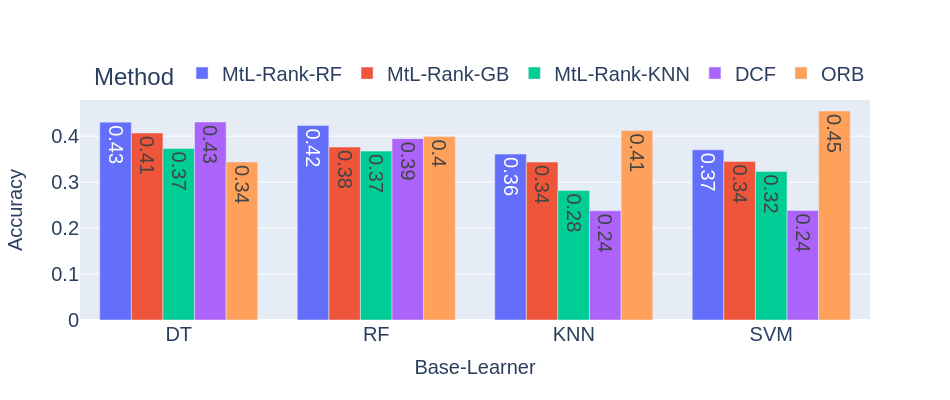

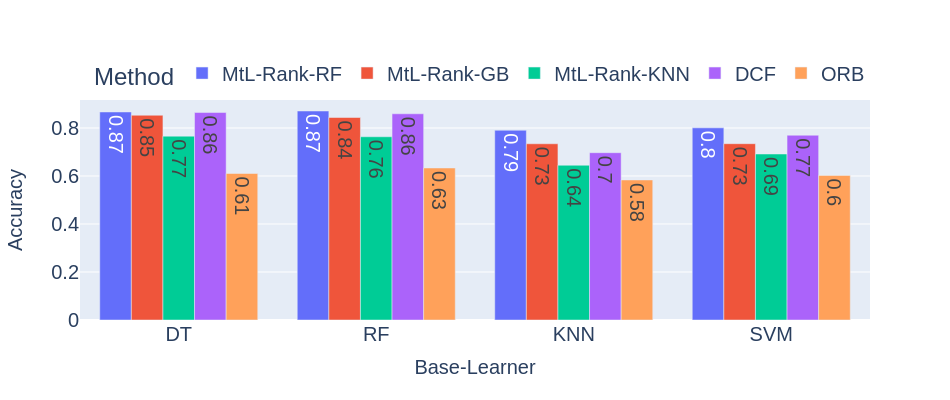

In [120]:
plotMtLAccuracySingleEnglishNoHyper(MtLRankingAccuracyNoHyper, postionsRanksNoHyper)
plotMtLAccuracySingleEnglishtop3NoHyper(MtLRankingAccuracyNoHyper, postionsRanksNoHyper)

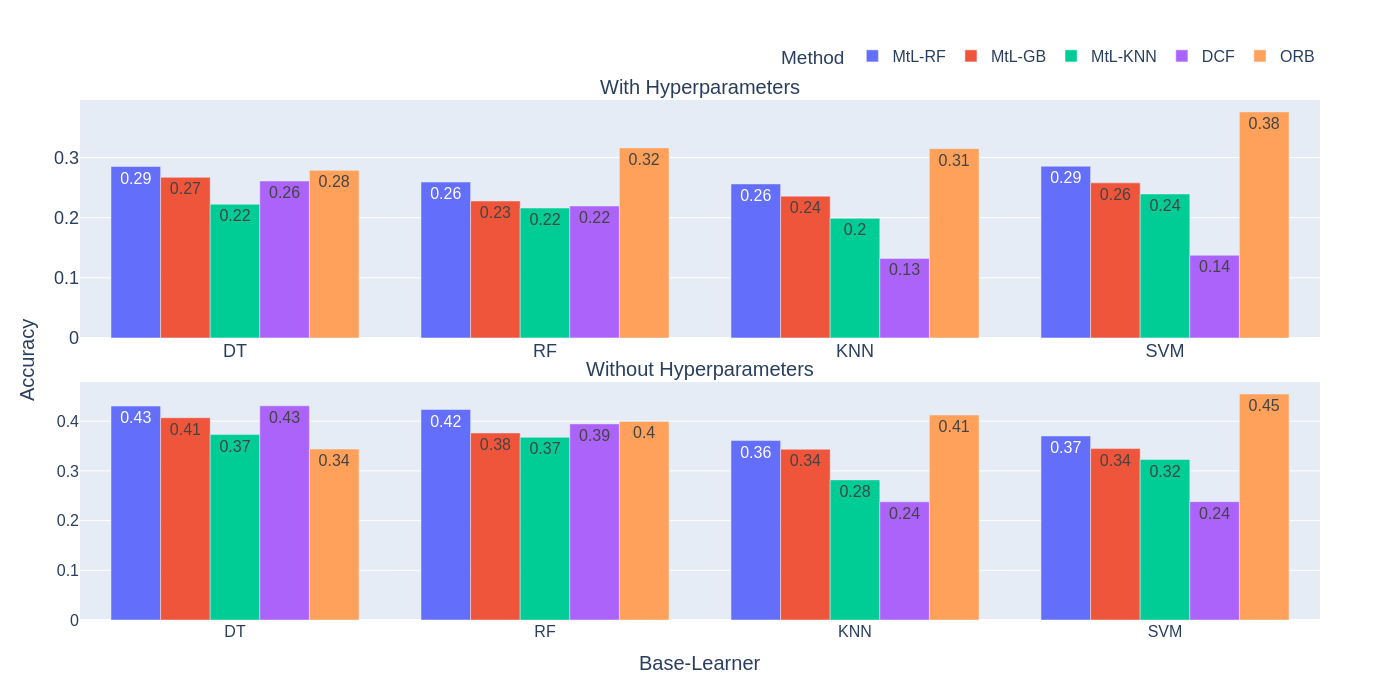

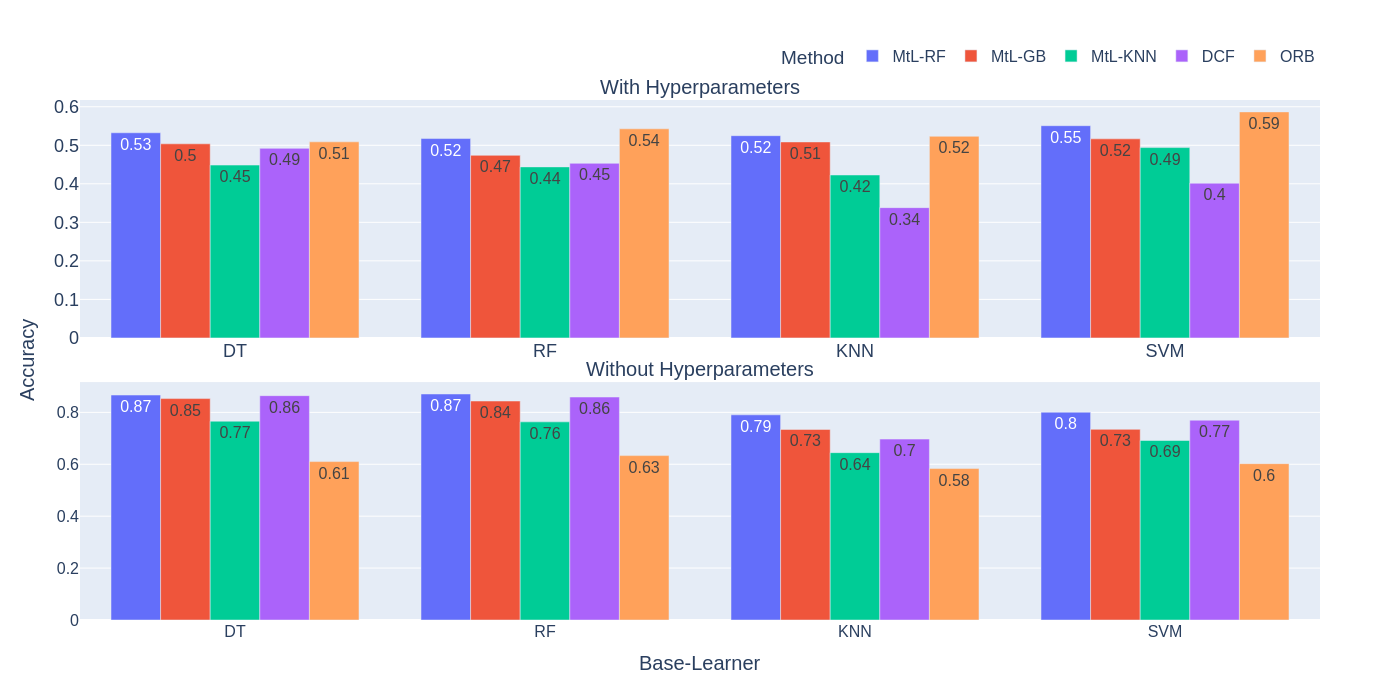

In [38]:
# ranks = buildRanks(metabasesRanking)
# postionsRanks = ranksToPositionRanks(ranks)
# ranksNoHyper = buildRanks(metabasesRankingNoHyper)
# postionsRanksNoHyper = ranksToPositionRanks(ranksNoHyper)
# display(postionsRanks)
plotMtLAccuracy(MtLRankingAccuracy, postionsRanks, MtLRankingAccuracyNoHyper, postionsRanksNoHyper)
# plotMtLAccuracy(MtLRankingAccuracyNoHyper, postionsRanksNoHyper)
plotMtLAccuracytop3(MtLRankingAccuracy, postionsRanks, MtLRankingAccuracyNoHyper, postionsRanksNoHyper)
# plotMtLAccuracytop3(MtLRankingAccuracyNoHyper, postionsRanksNoHyper)



## Multiple Classifier

In [121]:
def getBestAlgorithmsListNoHyper(metabase):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    meta_data.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15',  'OR3','GE9', 'AENN7',
        'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
        'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
        'GE5', 'AENN5','GE11']
    meta_data = meta_data[['GE5', 'AENN5', 'HARF70', 'Edge15', 'PRISM', 'Hybrid',  'OR11', 'Dynamic']]
    meta_data.columns = ['GE', 'AENN', 'HARF', 'Edge', 'PRISM', 'Hybrid',  'ORBoost', 'Dynamic']

    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    # rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
    #    'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
    #    'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
    #    'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row == 1].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict


In [122]:
resultNameList = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('MultipleClassifierResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)

resultNameList

meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
fixedCols = meta_data.columns
fixedCols2 = ['test_f1_macro_mean_AENN-5', 'test_f1_macro_mean_edgeBoostFilter-15','test_f1_macro_mean_PRISM', 'test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5', 'test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']

gainMetabase = None
usedCols = None
MtLClassAccuracy = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None


if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLClassAccuracy.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLClassAccuracy.p', 'rb')
    MtLClassAccuracy = pickle.load(file)
    file.close()
else:
    for i in resultNameList:
        for resultFileName in resultNameList[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithms(predictRankResult)
            # df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            bestalgoList, bestalgoDict =  getBestAlgorithmsList(i)
            df0['Best'] = bestalgoList
            # df0
            arr = []
            for index, row in df0.iterrows():
                arr.append(row['SelectedAlgo'] in row['Best'])
            total = sum(arr)

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassAccuracy[i][f'MtL-RF'] = [total]
            if '_GB'in resultFileName:
                MtLClassAccuracy[i][f'MtL-GB'] = [total]
            if '_KNN'in resultFileName:
                MtLClassAccuracy[i][f'MtL-KNN'] = [total]
    file = open('PickleVars/08 - AnalyzeResults/MtLClassAccuracy.p', 'wb')
    pickle.dump(MtLClassAccuracy, file)
    file.close()

display(MtLClassAccuracy)

gainMetabase = None
usedCols = None
MtLClassAccuracyNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/08 - AnalyzeResults/MtLClassAccuracyNoHyper.p'):
    file = open('PickleVars/08 - AnalyzeResults/MtLClassAccuracyNoHyper.p', 'rb')
    MtLClassAccuracyNoHyper = pickle.load(file)
    file.close()
else:
    for i in resultNameListNoHyper:
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithmsNoHyper(predictRankResult)
            # df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            bestalgoList, bestalgoDict =  getBestAlgorithmsListNoHyper(i)
            df0['Best'] = bestalgoList
            
            # df0
            arr = []
            for index, row in df0.iterrows():
                arr.append(row['SelectedAlgo'] in row['Best'])
            total = sum(arr)
            
            # df0['SelectedAlgo'].value_counts()

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassAccuracyNoHyper[i][f'MtL-RF'] = [total]
            if '_GB'in resultFileName:
                MtLClassAccuracyNoHyper[i][f'MtL-GB'] = [total]
            if '_KNN'in resultFileName:
                MtLClassAccuracyNoHyper[i][f'MtL-KNN'] = [total]
    file = open('PickleVars/08 - AnalyzeResults/MtLClassAccuracyNoHyper.p', 'wb')
    pickle.dump(MtLClassAccuracyNoHyper, file)
    file.close()
MtLClassAccuracyNoHyper

{'RF': {'MtL-RF': [3519], 'MtL-GB': [3502], 'MtL-KNN': [2635]},
 'DT': {'MtL-GB': [3343], 'MtL-KNN': [2439], 'MtL-RF': [3444]},
 'KNN': {'MtL-KNN': [2589], 'MtL-RF': [3732], 'MtL-GB': [3687]},
 'SVM': {'MtL-GB': [4139], 'MtL-RF': [4145], 'MtL-KNN': [3262]}}

{'RF': {'MtL-RF': [5213], 'MtL-GB': [4967], 'MtL-KNN': [4017]},
 'DT': {'MtL-KNN': [4054], 'MtL-GB': [5003], 'MtL-RF': [5246]},
 'KNN': {'MtL-GB': [4960], 'MtL-RF': [5029], 'MtL-KNN': [3616]},
 'SVM': {'MtL-RF': [5270], 'MtL-GB': [5287], 'MtL-KNN': [3984]}}

In [123]:
# ranks = buildRanks(metabasesRanking)
# postionsRanks = ranksToPositionRanks(ranks)
postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[0].name
postionsRanks['DT'].sort_values(by=1, ascending=False).iloc[0][1]


2994

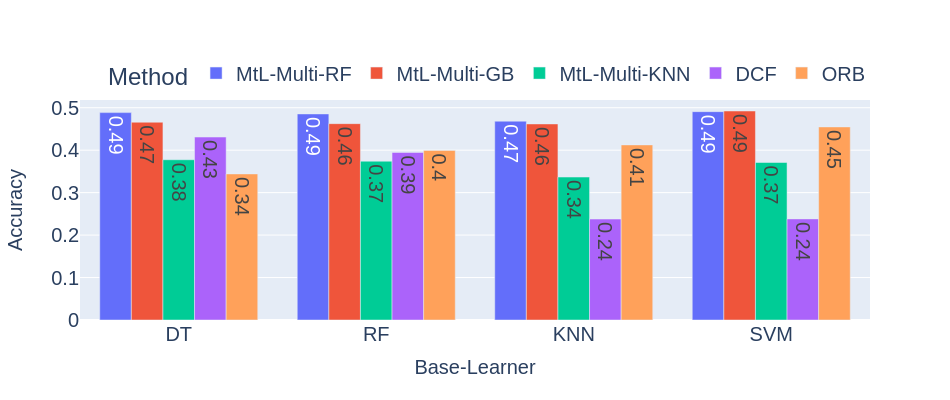

In [128]:
plotMtLAccuracySingleEnglishNoHyper(MtLClassAccuracyNoHyper, postionsRanksNoHyper)


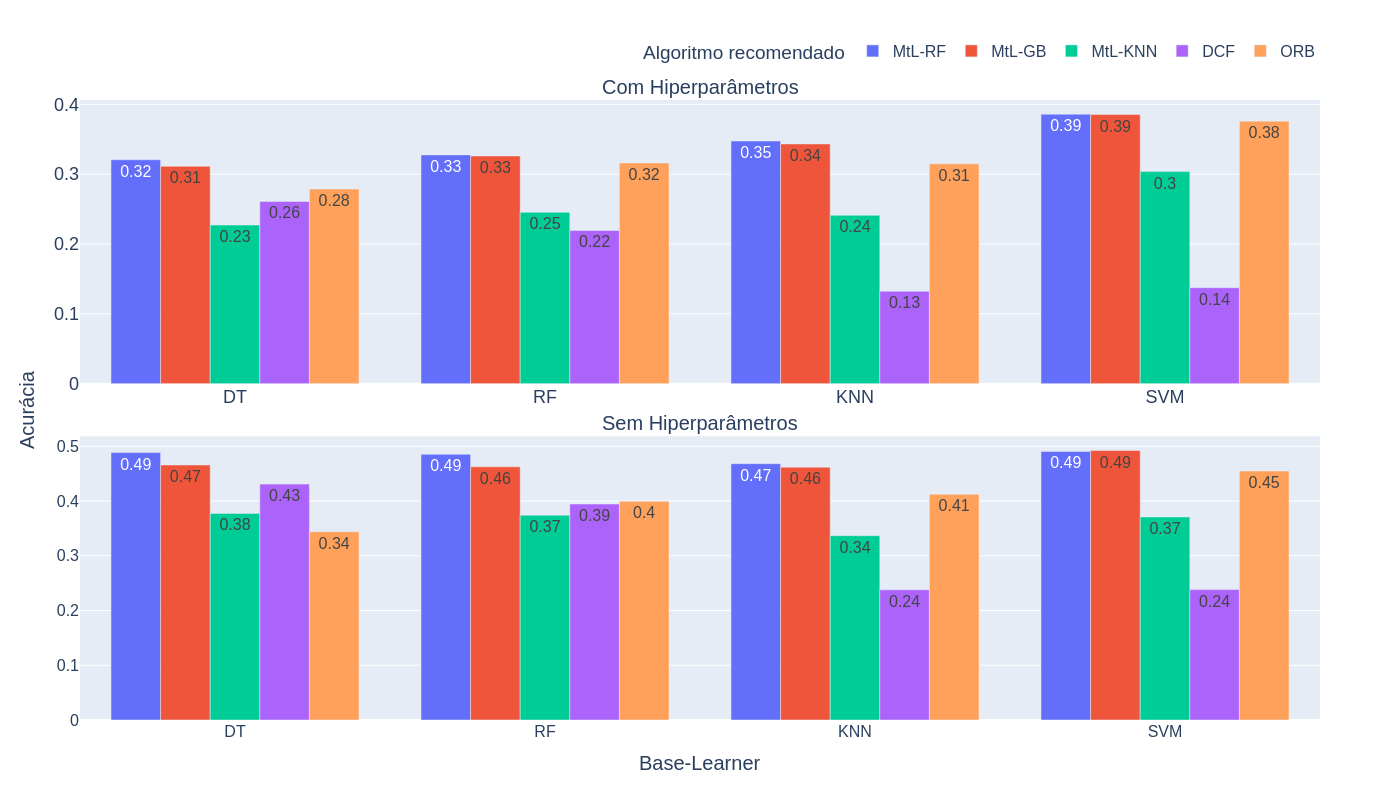

In [119]:
# ranks = buildRanks(metabasesRanking)
# postionsRanks = ranksToPositionRanks(ranks)
# ranksNoHyper = buildRanks(metabasesRankingNoHyper)
# postionsRanksNoHyper = ranksToPositionRanks(ranksNoHyper)
plotMtLAccuracy(MtLClassAccuracy, postionsRanks, MtLClassAccuracyNoHyper, postionsRanksNoHyper)
# plotMtLAccuracy(MtLClassAccuracyNoHyper, postionsRanksNoHyper)

## Ferature imporatance

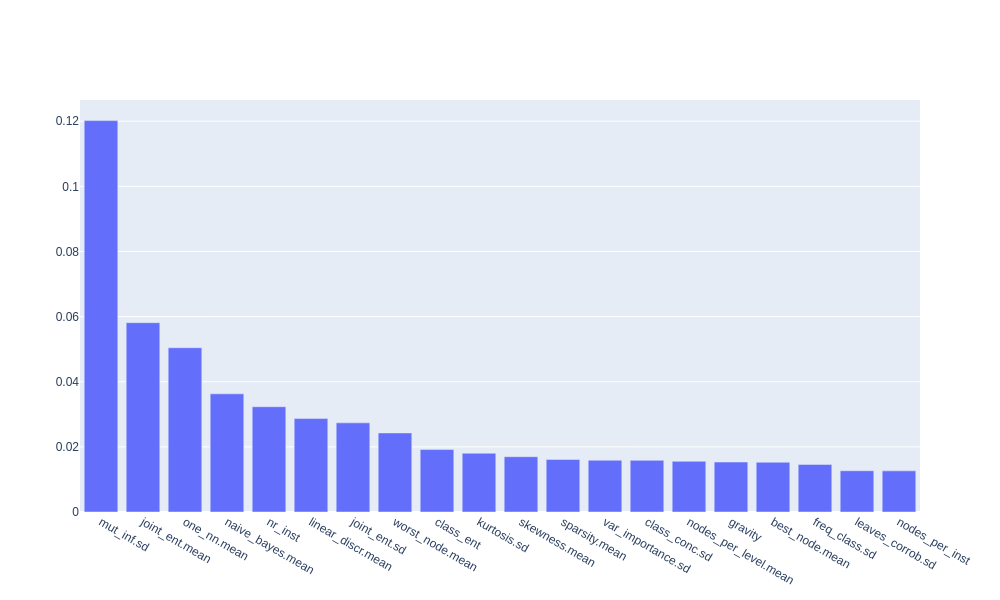

In [18]:
import pickle

file = open("RankingResults/features_RF_f1-score-DT.p",'rb')
rankingImportance = pickle.load(file)
file.close()
rankingImportance
df = pd.DataFrame()
metabasesRanking['DT'].columns
meanImportance = np.mean(rankingImportance, axis=0)
df['Importância'] = meanImportance
df['Característica'] = pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset').columns[0:97]
df = df.sort_values(by= 'Importância', ascending = False).head(20)

# fig = make_subplots(rows=4, cols=1,
#                     vertical_spacing=0.085,
#                     horizontal_spacing=0.085,
#                     x_title='MFe',
#                     y_title='Importância',
#                     subplot_titles=('a',  'Sem Hiperparâmetros'))

#         fig.add_trace(
#             go.Bar(
#                 y = df[df['type'] == i][0].values /10740,
#                 x = df[df['type'] == i]['Baselearner'].values,
#                 name= i,
#                 text = np.around(df[df['type'] == i][0].values /10740, 2),
#             ), row = 1, col=1)
fig = go.Figure()
fig.add_trace(go.Bar(
    y = df['Importância'].values,
    x = df['Característica'].values,
    name = 'DT'
))
# fig = px.bar(df.sort_values(by= 'Importância', ascending = False).head(20), x='Característica', y='Importância')
fig.show(renderer="png", width=1000,
                height=600)

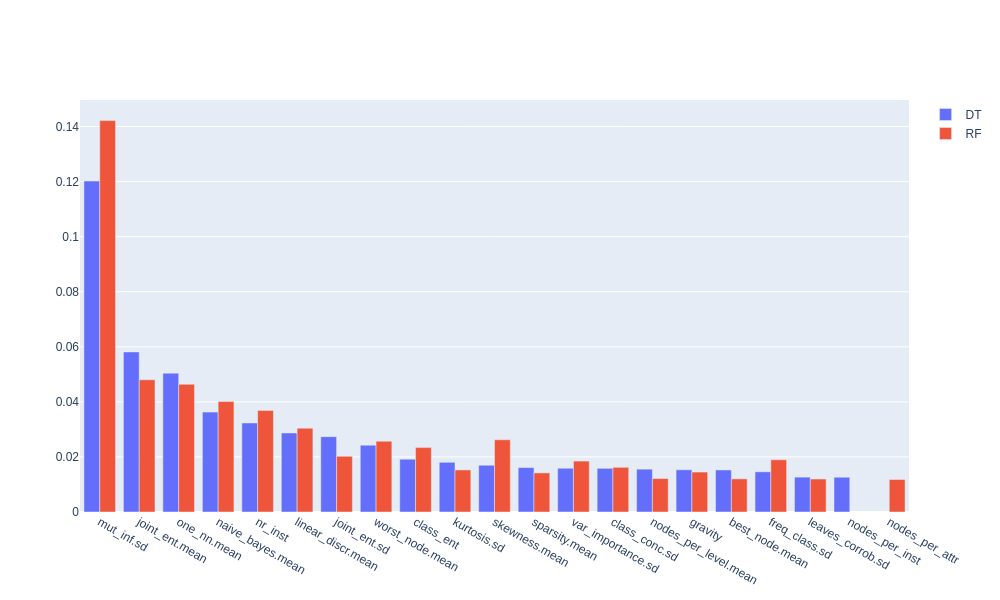

In [19]:
file = open("RankingResults/features_RF_f1-score-RF.p",'rb')
rankingImportance = pickle.load(file)
file.close()
rankingImportance
df = pd.DataFrame()
metabasesRanking['DT'].columns
meanImportance = np.mean(rankingImportance, axis=0)
df['Importância'] = meanImportance
df['Característica'] = pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset').columns[0:97]
df = df.sort_values(by= 'Importância', ascending = False).head(20)
fig.add_trace(go.Bar(
    y = df['Importância'].values,
    x = df['Característica'].values,
    name = 'RF'
))
# fig = px.bar(df.sort_values(by= 'Importância', ascending = False).head(20), x='Característica', y='Importância')
fig.show(renderer="png", width=1000,
                height=600)

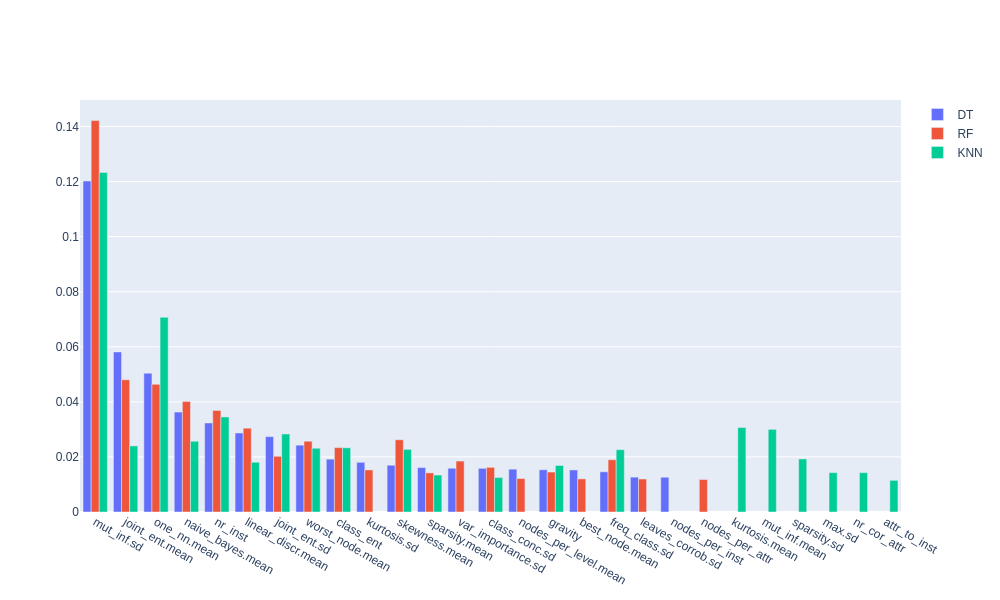

In [20]:
file = open("RankingResults/features_RF_f1-score-KNN.p",'rb')
rankingImportance = pickle.load(file)
file.close()
rankingImportance
df = pd.DataFrame()
metabasesRanking['DT'].columns
meanImportance = np.mean(rankingImportance, axis=0)
df['Importância'] = meanImportance
df['Característica'] = pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset').columns[0:97]
df = df.sort_values(by= 'Importância', ascending = False).head(20)
fig.add_trace(go.Bar(
    y = df['Importância'].values,
    x = df['Característica'].values,
    name = 'KNN'
))
fig.show(renderer="png", width=1000,
                height=600)

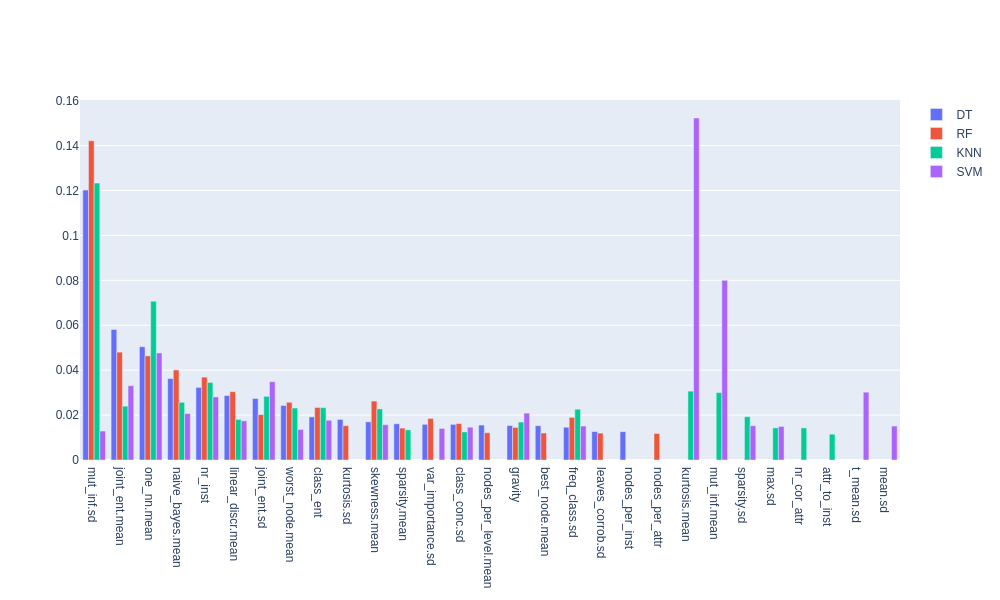

In [21]:
file = open("RankingResults/features_RF_f1-score-SVM.p",'rb')
rankingImportance = pickle.load(file)
file.close()
rankingImportance
df = pd.DataFrame()
metabasesRanking['DT'].columns
meanImportance = np.mean(rankingImportance, axis=0)
df['Importância'] = meanImportance
df['Característica'] = pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset').columns[0:97]
df = df.sort_values(by= 'Importância', ascending = False).head(20)
fig.add_trace(go.Bar(
    y = df['Importância'].values,
    x = df['Característica'].values,
    name = 'SVM'
))
fig.show(renderer="png", width=1000,
                height=600)

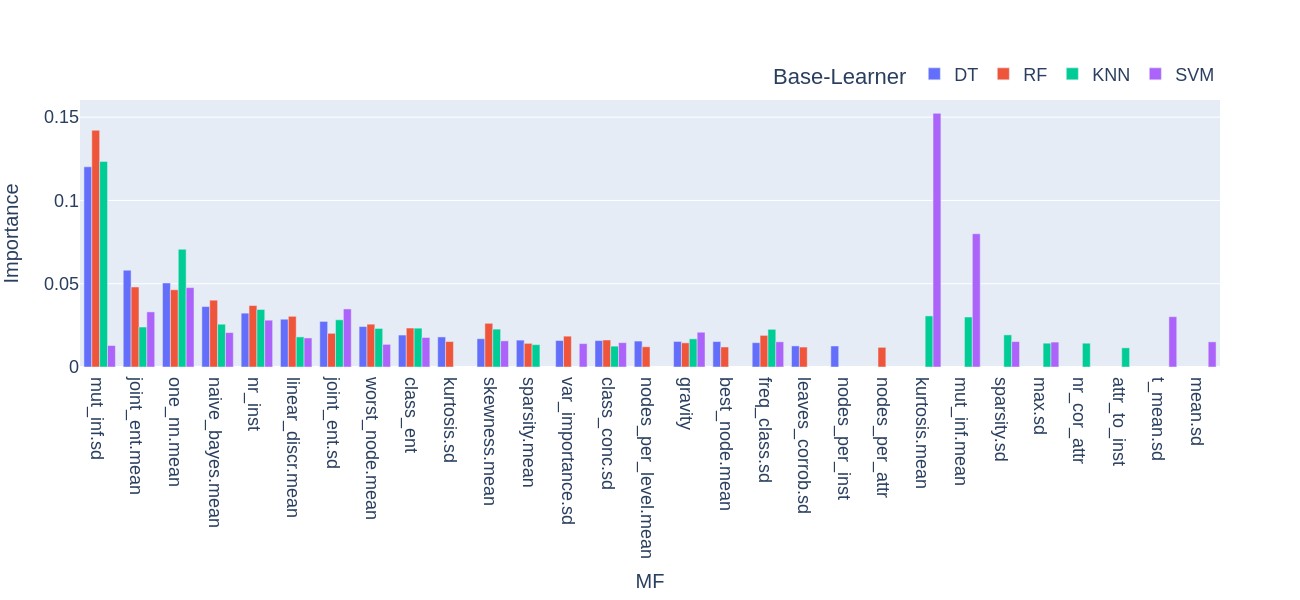

In [25]:
fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
    legend_title="Base-Learner",
    yaxis=dict(
        title_text="Importance",
        titlefont=dict(size=20),
    ),
    xaxis=dict(
        title_text="MF",
        titlefont=dict(size=20),
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ),
    font=dict(
        size=18,
    )
    # showlegend=False
)
fig.show(renderer="png", width=1300,
                height=600)

## Correlação

In [48]:
# def spermanRankCorr(df1, df2):
#     corr = []
#     df1Cols = df1.columns
#     df2Cols = df2.columns
#     m = len(df1Cols)
#     for index in range(len(df1)):
#         delta = [(df1.iloc[index][df1Cols[i[0]]] - df2.iloc[index][df2Cols[i[0]]])**2 for i in enumerate(df1)]
# #         print(delta)
#         r = 1 - ((6* sum(delta))/ (m**3 - m))
#         corr.append(r)
#     return corr

from scipy import stats
# import scipy.stats

def spermanRankCorr(df1, df2):
    corr = []
    df1Cols = df1.columns
    df2Cols = df2.columns
    m = len(df1Cols)
    for index in range(len(df1)):
#         delta = [(df1.iloc[index][df1Cols[i[0]]] - df2.iloc[index][df2Cols[i[0]]])**2 for i in enumerate(df1)]
# #         print(delta)
#         r = 1 - ((6* sum(delta))/ (m**3 - m))
        res = stats.spearmanr(df1.iloc[index].values, df2.iloc[index].values)
        corr.append(res.correlation)
    return corr

In [11]:
ranks['DT']

EDB5  EDB20  HARF85   HRF  EDB15  ORB3  \
1004_synthetic_control_10_0.csv.gz  26.0   12.0    20.0  11.0   22.0   4.0   
1004_synthetic_control_10_1.csv.gz  25.0    2.0    21.0  11.0   26.0   4.0   
1004_synthetic_control_10_2.csv.gz  26.0   12.0    23.0   9.0   24.0   5.0   
1004_synthetic_control_10_3.csv.gz  23.0   20.0    17.0   1.0   19.0   2.0   
1004_synthetic_control_10_4.csv.gz  27.0   12.0    24.0   8.0   16.0  22.0   
...                                  ...    ...     ...   ...    ...   ...   
997_balance-scale_5_5.csv.gz        26.0   22.0    18.0  16.0   27.0  11.0   
997_balance-scale_5_6.csv.gz        26.0    6.0    24.0  23.0   25.0  12.0   
997_balance-scale_5_7.csv.gz        27.0    7.0    23.0  17.0   25.0  16.0   
997_balance-scale_5_8.csv.gz        27.0   26.0    11.0  25.0   23.0  17.0   
997_balance-scale_5_9.csv.gz        24.0   19.0    18.0   7.0   21.0  26.0   

                                     GE9  AENN7  HARF75  ORB19  ...   DCF  \
1004_synthetic_control_10_0.csv.gz  14.0   10.0    13.0    7.0  ...   6.0   
1004_synthetic_control_10_1.csv.gz   8.0    6.0     3.0   13.0  ...   1.0   
1004_synthetic_control_10_2.csv.gz  15.0   13.0     3.0    8.0  ...   2.0   
1004_synthetic_control_10_3.csv.gz   5.0    3.0     8.0   13.0  ...  10.0   
1004_synthetic_control_10_4.csv.gz   9.0   15.0    14.0   10.0  ...   7.0   
...                                  ...    ...     ...    ...  ...   ...   
997_balance-scale_5_5.csv.gz        15.0    5.0    19.0    7.0  ...   6.0   
997_balance-scale_5_6.csv.gz        21.0    3.0    18.0   10.0  ...   8.0   
997_balance-scale_5_7.csv.gz        10.0    2.0    14.0   15.0  ...   6.0   
997_balance-scale_5_8.csv.gz        13.0    2.0     7.0   18.0  ...  19.0   
997_balance-scale_5_9.csv.gz        12.0    1.0     5.0   14.0  ...  10.0   

                                    EDB10  HARF80  AENN3  HARF90  ORB7  \
1004_synthetic_control_10_0.csv.gz   23.0    19.0   16.0    27.0   8.0   
1004_synthetic_control_10_1.csv.gz   27.0    17.0   22.0    24.0  16.0   
1004_synthetic_control_10_2.csv.gz   27.0    20.0   17.0    25.0   6.0   
1004_synthetic_control_10_3.csv.gz   24.0    15.0   16.0    22.0   2.0   
1004_synthetic_control_10_4.csv.gz   25.0     5.0   21.0    26.0   6.0   
...                                   ...     ...    ...     ...   ...   
997_balance-scale_5_5.csv.gz         25.0    21.0    4.0    24.0   8.0   
997_balance-scale_5_6.csv.gz         27.0    16.0    1.0    22.0   9.0   
997_balance-scale_5_7.csv.gz         26.0    22.0    4.0    24.0  11.0   
997_balance-scale_5_8.csv.gz         24.0     8.0    5.0    22.0  12.0   
997_balance-scale_5_9.csv.gz         22.0    20.0    4.0    23.0  25.0   

                                    HARF70   GE5  AENN5  GE11  
1004_synthetic_control_10_0.csv.gz     9.0  21.0   18.0  17.0  
1004_synthetic_control_10_1.csv.gz    10.0  12.0   19.0   7.0  
1004_synthetic_control_10_2.csv.gz     1.0  19.0   16.0  14.0  
1004_synthetic_control_10_3.csv.gz    12.0  14.0   18.0   9.0  
1004_synthetic_control_10_4.csv.gz    11.0  17.0   13.0  19.0  
...                                    ...   ...    ...   ...  
997_balance-scale_5_5.csv.gz          20.0  17.0    1.0  12.0  
997_balance-scale_5_6.csv.gz          15.0  17.0    5.0  14.0  
997_balance-scale_5_7.csv.gz          18.0  19.0    3.0  13.0  
997_balance-scale_5_8.csv.gz           6.0  21.0    4.0  20.0  
997_balance-scale_5_9.csv.gz           9.0  16.0    3.0  17.0  

[10740 rows x 27 columns]

In [12]:
a = pd.read_csv(f'RankingResults/results_RF_f1-score-DT.csv.zip', index_col='Dataset')

In [84]:
def returnrank(predictRankResult, Cols):
    rank = pd.DataFrame()
    df = predictRankResult[Cols]
    for i, a in enumerate(df.index):
        rank = rank.append(df.iloc[i].rank(method = 'dense', ascending = False))
    total = 0
    rank = rank[Cols]
    if len(Cols)>20:
        rank.columns = ['EDB5', 'EDB20', 'HARF85', 'HRF', 'EDB15', 'ORB3', 'GE9', 'AENN7',
       'HARF75', 'ORB19', 'AENN11', 'AENN9', 'ORB11', 'PRISM', 'GE3', 'GE7',
       'ORB15', 'DCF', 'EDB10', 'HARF80', 'AENN3', 'HARF90', 'ORB7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
    else:
        rank.columns = [ 'AENN', 'EDB', 'PRISM', 'HARF', 'GE', 'DCF', 'HRF', 'ORB']
        rank = rank[['GE', 'AENN', 'HARF', 'EDB', 'PRISM', 'HRF', 'ORB', 'DCF']]
    return rank

In [54]:
def getFolderFilesList(path):
    return [filename for filename in listdir(path) if isfile(join(path, filename))]

resultNameList = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('RankingResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)

resultNameList

meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
fixedCols = meta_data.columns
fixedCols2 = ['test_f1_macro_mean_AENN-5', 'test_f1_macro_mean_edgeBoostFilter-15','test_f1_macro_mean_PRISM', 'test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5', 'test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']

In [55]:
resultNameList

{'RF': ['results_GB_f1-score-RF.csv.zip',
  'results_KNN_f1-score-RF.csv.zip',
  'results_RF_f1-score-RF.csv.zip'],
 'DT': ['results_GB_f1-score-DT.csv.zip',
  'results_KNN_f1-score-DT.csv.zip',
  'results_RF_f1-score-DT.csv.zip'],
 'KNN': ['results_GB_f1-score-KNN.csv.zip',
  'results_KNN_f1-score-KNN.csv.zip',
  'results_RF_f1-score-KNN.csv.zip'],
 'SVM': ['results_KNN_f1-score-SVM.csv.zip',
  'results_RF_f1-score-SVM.csv.zip',
  'results_GB_f1-score-SVM.csv.zip']}

In [87]:
def getCorr(ran, resultNameList, Cols):
    correlation = {}
    for i in resultNameList:
        for j in resultNameList[i]:
            rankType = None
            a = pd.read_csv(f'RankingResults/{j}', index_col='Dataset')
            if '-RF'in j:
                rankType = 'RF'
            if '-DT'in j:
                rankType = 'DT'
            if '-KNN'in j:
                rankType = 'KNN'
            if '-SVM'in j:
                rankType = 'SVM'
            corr = spermanRankCorr(ran[rankType], returnrank(a, Cols))
            corr = np.array(corr)
            corr = np.nan_to_num(corr)
            correlation[j] = [np.mean(corr), np.std(corr)]
    return correlation


In [47]:
value = spermanRankCorr(ranks['KNN'], returnrank(a, fixedCols))
value = np.array(value)
value = np.nan_to_num(value)
np.mean(value)

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



0.0008051101617365203

In [85]:
a = pd.read_csv(f'RankingResults/results_GB_f1-score-RF.csv.zip', index_col='Dataset')
returnrank(a, fixedCols2)


GE  AENN  HARF  EDB  PRISM  HRF  ORB  DCF
1004_synthetic_control_10_0.csv.gz  3.0   5.0   2.0  7.0    6.0  4.0  8.0  1.0
1004_synthetic_control_10_1.csv.gz  4.0   5.0   2.0  7.0    6.0  3.0  8.0  1.0
1004_synthetic_control_10_2.csv.gz  4.0   5.0   3.0  7.0    6.0  2.0  8.0  1.0
1004_synthetic_control_10_3.csv.gz  3.0   6.0   2.0  5.0    7.0  4.0  8.0  1.0
1004_synthetic_control_10_4.csv.gz  4.0   5.0   3.0  7.0    6.0  2.0  8.0  1.0
...                                 ...   ...   ...  ...    ...  ...  ...  ...
997_balance-scale_5_5.csv.gz        7.0   4.0   5.0  8.0    6.0  2.0  3.0  1.0
997_balance-scale_5_6.csv.gz        7.0   4.0   3.0  8.0    6.0  1.0  5.0  2.0
997_balance-scale_5_7.csv.gz        6.0   3.0   4.0  8.0    7.0  2.0  5.0  1.0
997_balance-scale_5_8.csv.gz        7.0   4.0   3.0  8.0    6.0  2.0  5.0  1.0
997_balance-scale_5_9.csv.gz        7.0   4.0   3.0  8.0    6.0  2.0  5.0  1.0

[10740 rows x 8 columns]

In [86]:
ranksNoHyper['DT']

GE  AENN  HARF  EDB  PRISM  HRF  ORB  DCF
1004_synthetic_control_10_0.csv.gz  6.0   5.0   3.0  7.0    8.0  4.0  1.0  2.0
1004_synthetic_control_10_1.csv.gz  4.0   6.0   2.0  8.0    5.0  3.0  7.0  1.0
1004_synthetic_control_10_2.csv.gz  6.0   5.0   1.0  8.0    7.0  3.0  4.0  2.0
1004_synthetic_control_10_3.csv.gz  6.0   7.0   5.0  8.0    3.0  1.0  2.0  4.0
1004_synthetic_control_10_4.csv.gz  7.0   5.0   4.0  6.0    8.0  3.0  1.0  2.0
...                                 ...   ...   ...  ...    ...  ...  ...  ...
997_balance-scale_5_5.csv.gz        6.0   1.0   7.0  8.0    4.0  5.0  3.0  2.0
997_balance-scale_5_6.csv.gz        5.0   1.0   4.0  8.0    6.0  7.0  3.0  2.0
997_balance-scale_5_7.csv.gz        6.0   1.0   5.0  8.0    7.0  4.0  3.0  2.0
997_balance-scale_5_8.csv.gz        6.0   1.0   2.0  7.0    3.0  8.0  4.0  5.0
997_balance-scale_5_9.csv.gz        7.0   1.0   3.0  8.0    6.0  2.0  5.0  4.0

[10740 rows x 8 columns]

In [88]:

getCorr(ranksNoHyper, resultNameListNoHyper, fixedCols2)

# {'results_GB_f1-score-RF-NoHyper.csv.zip': [0.5658154907021125,
#   0.3310523619725264],
#  'results_RF_f1-score-RF-NoHyper.csv.zip': [0.5833141702231858,
#   0.3343915908074073],
#  'results_KNN_f1-score-RF-NoHyper.csv.zip': [0.44501604325991106,
#   0.37357654147723796],
#  'results_KNN_f1-score-DT-NoHyper.csv.zip': [0.43647510984854127,
#   0.37503173247954136],
#  'results_GB_f1-score-DT-NoHyper.csv.zip': [0.5665086411724048,
#   0.3293279405070172],
#  'results_RF_f1-score-DT-NoHyper.csv.zip': [0.5758663808099833,
#   0.3360529202800683],
#  'results_RF_f1-score-KNN-NoHyper.csv.zip': [0.5573325013312044,
#   0.350263558383915],
#  'results_GB_f1-score-KNN-NoHyper.csv.zip': [0.5198527985563476,
#   0.3659778665296071],
#  'results_KNN_f1-score-KNN-NoHyper.csv.zip': [0.4051590082814461,
#   0.4004796977306648],
#  'results_RF_f1-score-SVM-NoHyper.csv.zip': [0.5298794803375921,
#   0.37311306929111493],
#  'results_KNN_f1-score-SVM-NoHyper.csv.zip': [0.40907005445395894,
#   0.4049093120707288],
#  'results_GB_f1-score-SVM-NoHyper.csv.zip': [0.47903959446885735,
#   0.3776574649972178]}

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

{'results_GB_f1-score-RF-NoHyper.csv.zip': [0.5658154907021125,
  0.3310523619725264],
 'results_RF_f1-score-RF-NoHyper.csv.zip': [0.5833141702231858,
  0.3343915908074073],
 'results_KNN_f1-score-RF-NoHyper.csv.zip': [0.44501604325991106,
  0.37357654147723796],
 'results_KNN_f1-score-DT-NoHyper.csv.zip': [0.43647510984854127,
  0.37503173247954136],
 'results_GB_f1-score-DT-NoHyper.csv.zip': [0.5665086411724048,
  0.3293279405070172],
 'results_RF_f1-score-DT-NoHyper.csv.zip': [0.5758663808099833,
  0.3360529202800683],
 'results_RF_f1-score-KNN-NoHyper.csv.zip': [0.5573325013312044,
  0.350263558383915],
 'results_GB_f1-score-KNN-NoHyper.csv.zip': [0.5198527985563476,
  0.3659778665296071],
 'results_KNN_f1-score-KNN-NoHyper.csv.zip': [0.4051590082814461,
  0.4004796977306648],
 'results_RF_f1-score-SVM-NoHyper.csv.zip': [0.5298794803375921,
  0.37311306929111493],
 'results_KNN_f1-score-SVM-NoHyper.csv.zip': [0.40907005445395894,
  0.4049093120707288],
 'results_GB_f1-score-SVM-NoH

In [58]:
getCorr(ranks, resultNameList, fixedCols)
# {'results_GB_f1-score-RF.csv.zip': [0.5551517044413364, 0.30243247218765246],
#  'results_KNN_f1-score-RF.csv.zip': [0.40944042849592766, 0.33803337727444654],
#  'results_RF_f1-score-RF.csv.zip': [0.5696017402815052, 0.3143149816139779],
#  'results_GB_f1-score-DT.csv.zip': [0.5528810752630331, 0.29852951346134343],
#  'results_KNN_f1-score-DT.csv.zip': [0.39715345670405555, 0.3353535895066657],
#  'results_RF_f1-score-DT.csv.zip': [0.5627358131339185, 0.31010087499805117],
#  'results_GB_f1-score-KNN.csv.zip': [0.520494911953475, 0.3359645707606835],
#  'results_KNN_f1-score-KNN.csv.zip': [0.3939333408584321, 0.36672947484474194],
#  'results_RF_f1-score-KNN.csv.zip': [0.541756332172148, 0.3340044176083973],
#  'results_KNN_f1-score-SVM.csv.zip': [0.3913100056666285, 0.3677148266710422],
#  'results_RF_f1-score-SVM.csv.zip': [0.513191854136184, 0.3527247696318381],
#  'results_GB_f1-score-SVM.csv.zip': [0.4729357446867612, 0.3525389675643163]}


/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/lpfgarcia/pedropio/NoiseSelection/NoiseEnvPy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning:

{'results_GB_f1-score-RF.csv.zip': [0.5551517044413364, 0.30243247218765246],
 'results_KNN_f1-score-RF.csv.zip': [0.40944042849592766, 0.33803337727444654],
 'results_RF_f1-score-RF.csv.zip': [0.5696017402815052, 0.3143149816139779],
 'results_GB_f1-score-DT.csv.zip': [0.5528810752630331, 0.29852951346134343],
 'results_KNN_f1-score-DT.csv.zip': [0.39715345670405555, 0.3353535895066657],
 'results_RF_f1-score-DT.csv.zip': [0.5627358131339185, 0.31010087499805117],
 'results_GB_f1-score-KNN.csv.zip': [0.520494911953475, 0.3359645707606835],
 'results_KNN_f1-score-KNN.csv.zip': [0.3939333408584321, 0.36672947484474194],
 'results_RF_f1-score-KNN.csv.zip': [0.541756332172148, 0.3340044176083973],
 'results_KNN_f1-score-SVM.csv.zip': [0.3913100056666285, 0.3677148266710422],
 'results_RF_f1-score-SVM.csv.zip': [0.513191854136184, 0.3527247696318381],
 'results_GB_f1-score-SVM.csv.zip': [0.4729357446867612, 0.3525389675643163]}

In [45]:
# value = np.array(value)
value = np.nan_to_num(value)
np.mean(value)

0.49929604095361685